## Comienzo

### Comprensión del problema

#### Objetivo general

Desarrollar un sistema inteligente capaz de detectar y proponer soluciones a errores en datos de cronometraje deportivo, aprendiendo de la corecciones (issues) realizadas manualmente por cronometradores en distintas carreras y de los tiempos que estos mismos atletas hacen durante la carrera. 

#### Objetivo del análisis actual

Realizar un análisis descriptivo y exploratorio de los datasets históricos (athletes.json e issues.json) provenientes de diferentes competiciones (deportes como ciclismo o running) para comprender la estructura de los datos, su calidad, las relaciones entre variables y los patrones asociados a los errores detectados.

#### Datos disponibles

Se tienen datos de distintas carreras, para cada carrera obtenemos un total de dos json. 

- athletes: Contiene la info. de los atletas, sus tiempos, etapas, posiciones, estados... 

- issues: registra los errores detectados durante el cronometraje y las correcciones aplicadas manualmente.

Tenemos datos de distintas carreras con distinto número de atletas, etapas y deportes.

En pasos siguientes analizaremos la estructura de cada uno de los json

#### Variables importantes

Como variables importantes las tenemos en varios grupos:

- Temporales: tiempos por etapa, timestamp de detección/corrección, duración entre controles.

- Categóricas: tipo de error, estado del atleta, deporte, categoría de edad, sexo.

- Numéricas: tiempos totales, diferencias entre splits, número de issues por atleta.

- Relacionales: vinculación entre el atleta afectado y el issue correspondiente.

#### Resultados esperados

- Comprender la estructura jerárquica y variabilidad entre carreras.

- Cuantificar la calidad de los datos y los tipos de errores más frecuentes.

- Detectar patrones espaciales o temporales en los issues.

- Evaluar la posibilidad de reconstruir el “antes y después” de una corrección.

- Generar una base sólida para la creación futura de modelos predictivos.

## Análisis descriptivo y carga de datos

### Carga y comprobaciones iniciales

Como primera parte vamos a cargar los datos necesarios que vamos a reescructurar y analizar. Son datos de la conocida media maratón de Barcelona, organizados en archivos json como antes adelantábamos, en athletes e issues. Por ahora solo se va analizar una carrera, ya que la mayoría tienen una estructura similar y nos va a servir para tener una visión general de las variables y datos almacenados en las carreras.

In [4]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data_dir = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos"

In [ ]:
import json
import glob
import os

athletes_files = glob.glob(os.path.join(data_dir, "*.athletes.json"))
issues_files = glob.glob(os.path.join(data_dir, "*.issues.json"))

all_athletes = {}
all_issues = {}

def get_race_id(filepath):
    filename = os.path.basename(filepath)
    return filename.split(".")[0]

for a_file in athletes_files:
    race_id = get_race_id(a_file)
    with open(a_file, "r", encoding="utf-8") as f:
        all_athletes[race_id] = json.load(f)

for i_file in issues_files:
    race_id = get_race_id(i_file)
    with open(i_file, "r", encoding="utf-8") as f:
        all_issues[race_id] = json.load(f)

print("Carreras cargadas:", list(all_athletes.keys()))
print("Ejemplo atletas primera carrera:", all_athletes[list(all_athletes.keys())[0]][:3])
print("Ejemplo issues primera carrera:", all_issues[list(all_issues.keys())[0]][:3])

Carreras cargadas: ['edreams-mitja-marato-barcelona-2025-by-brooks']
Ejemplo atletas primera carrera: [{'id': 31, 'name': 'Abdezaliz', 'surname': 'Merzougui', 'nationality': 'es', 'gender': 'male', 'birthdate': '1991-08-30', 'TIEMPO ESTIMADO': None, 'events': [{'event': 'Mitja', 'dorsal': 31, 'chip': [31, 40031], 'team': '', 'team_type': [], 'category': 'Senior M', 'attributes': {}, 'gunTime': '2025-02-16T07:31:06.000Z', 'gunTimeMode': 'wave', 'gunTimeModeConfig': {'wave': '8:30'}, 'auto_category': True, 'auto_chip': True, 'status': 'retired', 'realStatus': 'running', 'startTime': 2560, 'startRawTime': 1739691068560, 'startNetTime': 2560, 'distance': 5000, 'leader_weight': 0, 'maxConsecutiveSplitsMissing': 0, 'splitsMissing': 0, 'issuesCount': {'data': 6, 'times': 0}, 'splitsSeen': 2, 'last_split_seen': '5K', 'times': {'Salida': {'time': 2560, 'split': 'Salida', 'order': 1, 'raw': {'created': 1739691074435, 'chip': '31', 'location': 'Salida', 'device': 'TS2P4 191', 'time': '2025-02-16T

Como vimos anteriormente, solo analizamos una sola carrera. 

Para poder ver la estructura de los json ejecutamos los siguientes codigos.

In [ ]:
import os
import glob
import json
from collections import defaultdict


def merge_structures(base, new, max_unique=0):

    if isinstance(base, dict) and isinstance(new, dict):
        # si ambos son diccionarios, combinar claves recursivamente
        merged = dict(base)
        for key, val in new.items():
            if key in merged:
                merged[key] = merge_structures(merged[key], val, max_unique)
            else:
                merged[key] = val
        return merged

    elif isinstance(base, set) and isinstance(new, set):
        # si ambos son conjuntos, unir y limitar tamaño si es necesario
        merged_set = base | new
        if len(merged_set) > max_unique:
            return "*"
        return merged_set

    elif isinstance(base, set):
        # caso mixto: base es un set y new no
        if isinstance(new, (dict, list)):
            return "*|dict_or_list"
        return merge_structures(base, {new}, max_unique)

    elif isinstance(new, set):
        # caso mixto inverso: new es set y base no
        if isinstance(base, (dict, list)):
            return "*|dict_or_list"
        return merge_structures({base}, new, max_unique)

    else:
        # caso base: ambos son valores escalares (int, str, etc.)
        if isinstance(base, (dict, list)) or isinstance(new, (dict, list)):
            return "*|dict_or_list"
        return {base, new}


def extract_structure_unique(data):
    
    if isinstance(data, dict):
        return {k: extract_structure_unique(v) for k, v in data.items()}

    elif isinstance(data, list):
        if not data:
            return {"[]": {}}  # lista vacía, estructura vacía
        # empezamos con la estructura del primer elemento
        struct = extract_structure_unique(data[0])
        # combinamos estructuras del resto de elementos
        for item in data[1:]:
            struct = merge_structures(struct, extract_structure_unique(item))
        return {"[]": struct}

    else:
        # valor escalar (str, int, bool, None, etc.)
        return {data}


def sets_to_lists(obj):
    
    if isinstance(obj, dict):
        return {k: sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, set):
        return [sets_to_lists(v) for v in obj]
    elif isinstance(obj, list):
        return [sets_to_lists(v) for v in obj]
    else:
        return obj



athletes_files = glob.glob(os.path.join(data_dir, "*.athletes.json"))

output_dir = os.path.join(data_dir, "estructuras")
os.makedirs(output_dir, exist_ok=True)

def get_race_id(filepath):
    """Extrae el ID de carrera a partir del nombre del archivo."""
    return os.path.basename(filepath).split(".")[0]


for a_file in athletes_files:
    race_id = get_race_id(a_file)
    print(f"\nProcesando carrera: {race_id}")

    # procesamiento de ATHLETES
    with open(a_file, "r", encoding="utf-8") as f:
        athletes = json.load(f)

    structure = {}
    # fusionar estructuras de todos los registros
    for record in athletes:
        structure = merge_structures(structure, extract_structure_unique(record))

    structure_serializable = sets_to_lists(structure)

    # guardar estructura en archivo JSON
    output_path_ath = os.path.join(output_dir, f"{race_id}_structure_athletes.json")
    with open(output_path_ath, "w", encoding="utf-8") as f:
        json.dump(structure_serializable, f, indent=4, ensure_ascii=False)
    print(f"Estructura ATHLETES guardada en: {output_path_ath}")

    # procesamiento de issues
    i_file = a_file.replace(".athletes.json", ".issues.json")

    if os.path.exists(i_file):
        with open(i_file, "r", encoding="utf-8") as f:
            issues = json.load(f)

        structure_issues = {}
        for record in issues:
            structure_issues = merge_structures(structure_issues, extract_structure_unique(record))

        structure_issues_serializable = sets_to_lists(structure_issues)

        output_path_iss = os.path.join(output_dir, f"{race_id}_structure_issues.json")
        with open(output_path_iss, "w", encoding="utf-8") as f:
            json.dump(structure_issues_serializable, f, indent=4, ensure_ascii=False)

        print(f"Estructura ISSUES guardada en: {output_path_iss}")
    else:
        print("No se encontró archivo ISSUES para esta carrera.")



Procesando carrera: edreams-mitja-marato-barcelona-2025-by-brooks
Estructura ATHLETES guardada en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos\estructuras\edreams-mitja-marato-barcelona-2025-by-brooks_structure_athletes.json
Estructura ISSUES guardada en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos\estructuras\edreams-mitja-marato-barcelona-2025-by-brooks_structure_issues.json


Podemos sacar tambien atletas y problemas únicos de cada json

In [ ]:
## CAMBIARLO PARA QUE SE UED HACER POR CARRERA TAMBIEN

import json
import os
import glob

ATHLETE_ID = 'L6554352'  # cambia por el ID del atleta que quieras

# obtener archivos
athletes_files = glob.glob(os.path.join(data_dir, "*.athletes.json"))
issues_files = glob.glob(os.path.join(data_dir, "*.issues.json"))

if not athletes_files:
    raise FileNotFoundError("No se encontró ningún archivo de atletas en el directorio.")
if not issues_files:
    raise FileNotFoundError("No se encontró ningún archivo de issues en el directorio.")

# carga de datos
for fpath in athletes_files:
    with open(fpath, "r", encoding="utf-8") as f:
        athletes_data.extend(json.load(f))  # agregamos todos los atletas de cada archivo

issues_data = []
for fpath in issues_files:
    with open(fpath, "r", encoding="utf-8") as f:
        issues_data.extend(json.load(f))  # agregamos todas las listas de issues

#buscarlo
athlete = next((a for a in athletes_data if str(a.get("id")) == str(ATHLETE_ID)), None)
if athlete is None:
    raise ValueError(f"No se encontró ningún atleta con id {ATHLETE_ID}")

#busar issues
for issue_list in issues_data:
    # cada issue_list puede ser una lista de issues
    if isinstance(issue_list, list):
        for issue in issue_list:
            if str(issue.get("athlete_id")) == str(ATHLETE_ID) or issue.get("athlete_id") == athlete.get("id"):
                athlete_issues.append(issue)
    elif isinstance(issue_list, dict):
        # si algún archivo tiene un dict en lugar de lista
        if str(issue_list.get("athlete_id")) == str(ATHLETE_ID):
            athlete_issues.append(issue_list)

output_athlete = os.path.join(data_dir, f"athlete_{ATHLETE_ID}.json")
output_issues = os.path.join(data_dir, f"athlete_{ATHLETE_ID}_issues.json")

with open(output_athlete, "w", encoding="utf-8") as f:
    json.dump(athlete, f, ensure_ascii=False, indent=4)

with open(output_issues, "w", encoding="utf-8") as f:
    json.dump(athlete_issues, f, ensure_ascii=False, indent=4)

print(f"Archivos guardados:\n - {output_athlete}\n - {output_issues}")

✅ Archivos guardados:
 - C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos\athlete_L6554352.json
 - C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos\athlete_L6554352_issues.json


En esta fase se van a tratar varios puntos importantes referentes a la estructura de los datos y a homogeneizarlos para poder estudiarlos de una forma más sencilla

#### Análisis estructural

Los datos que vamos a estudiar vienen dados en dos archivos json por carrera como comentábamos antes, uno para los datos de atletas (athletes) y otro para los problemas que ocurren en carrera (issues). Estos archivos están compùestos estructuralmente de maneras distintas, tanto cadauno por separado como para cada carrera, teniendo campos distintos en algunos casos. Vamos a definir de forma ganeral lo que se encuentra dentro de cada uno. 

- athletes (list[dict]): Es el archivo que tiene la información de los atletas y viene ordenados en dos niveles principales.

- - Nivel 1: La estructura principal es una lista (list) de diccionarios (dict), donde cada diccionario representa un atleta. Cada diccionario contiene campos simples como id (int | str), name (str), surname (str), gender (str), nationality (str), birthdate (str | None), user_id (int | None), importID (str | None), featured (bool | None) y otros campos administrativos o personales (str | int | bool | None).

- - Nivel 2: Dentro de cada diccionario de atleta, el campo events es un diccionario (dict) que funciona como una lista implícita, donde cada clave representa un evento distinto en el que participa el atleta. Cada valor es un diccionario (dict) que contiene información detallada sobre ese evento.

- - Nivel 3: Dentro de cada evento, encontramos varios bloques funcionales: campos de identificación y metadatos (event (str), dorsal (int | str), chip (list[str]), team (str), team_type (list | dict), category (str), attributes (dict[str, str | list[str]])), tiempos principales (gunTime (float | None), startTime (float | None), netTime (float | None), rawTime (float | None)), información de control (issuesCount (dict[str, int]), splitsMissing (int)), y bloques complejos como times (dict[str, dict]), rankings (dict[str, dict]), leader (dict[str, float | str]), calculatedTimes (dict[str, dict[str, float]]), commentatorTimes (dict[str, float | None]), backups (dict[str, dict[str, float | str]]), custom-rankings (list[dict]), commentator (dict[str, str | float | int]) y penalties (list[dict]).

- - Nivel 4: Dentro del bloque times, cada punto de control como "Salida", "5K", "10K", "15K", "19K" y "Meta" es un diccionario (dict) con campos simples (time (float | None), split (int | None), order (int | None), raw (dict), average (float | None), weight (float | None), incidence (bool | None), isBackup (bool | None), offset (float | None) y location (str | None)).

- - Nivel 5: Dentro de raw (subdiccionario de cada punto de control), se guardan los datos originales del dispositivo (chip (str), device (str), time (float | str), valid (bool), manual (bool | list[bool]), times (dict[str, float | None]), offset (float | None), type (str), originalTime (float | None), rawTime (float | None), id (str | int), isBackup (bool | None), backupOffset (float | None) y otros metadatos).

- issues: Es un archivo más simple (es una lista de elementos) y además suele ser más homogéneo entre carreras, ya que el software para crearlo es el mismo. También contiene varios niveles

- - Nivel 1: La estructura principal es una lista (list) de diccionarios (dict), donde cada diccionario representa un registro asociado a un atleta. Cada registro contiene campos simples como id (int | str), type (str), time (float | str | None), athlete_id (int), priority (int | None), collection (str) y event (str).

- - Nivel 2: Dentro de cada registro, el campo data es un diccionario (dict) que contiene información detallada del atleta y su participación. Aquí encontramos datos planos como document (str), Licencia (str | None), statusNote (str | None), birthdate (str | None), club (str | None), TIEMPO ESTIMADO (float | str | None), name (str), surname (str) y gender (str), además de la lista nationality (list[str]).

- - Nivel 3: Dentro de data, el campo events es un diccionario (dict) que funciona como lista implícita ("[]"), donde cada elemento representa un evento o participación específica del atleta. Cada evento es un diccionario (dict) con campos como gunTimeModeConfig (dict con wave (str | int)), gunTime (float | None), status (str), auto_category (bool | None), category (str), dorsal (int | str), chip (list[str]), auto_chip (bool | None) y attributes (dict[str, bool]).

- - Nivel 3: Dentro de data, el campo events es un diccionario (dict) que funciona como lista implícita ("[]"), donde cada elemento representa un evento o participación específica del atleta. Cada evento es un diccionario (dict) con campos como gunTimeModeConfig (dict con wave (str | int)), gunTime (float | None), status (str), auto_category (bool | None), category (str), dorsal (int | str), chip (list[str]), auto_chip (bool | None) y attributes (dict[str, bool]).

- - Los subniveles más internos incluyen configuraciones específicas (gunTimeModeConfig) y atributos especiales (attributes), que son diccionarios (dict) con valores simples (bool | str | int). Esta estructura organiza jerárquicamente los datos del atleta, sus eventos y los tiempos registrados, con una profundidad de aproximadamente cuatro a cinco niveles

Para más información se puede consultar el glosario de términos

#### Normalización estructural

Ok, una vez conocemos los datos de los que disponemos y su estructura, pasamos a normalizar los datos con un opbejtico firme: **Transformar los datos en crudo a dataframes** para poder estudiarlos de mejor forma

El modelo propuesto es un modelo de tablas relacionales extraídas de athletes e issues, que tendrán claves y relaciones entre sí para poder estudiarlas de forma conjunta. Se usarán para cada tabla todas las carreras que se tengan disponibles. 

Explicamos el modelo de tablas relacionales:

- *athletes_df*: **Datos generales de los atletas**. En esta tabla se almacenan los datos personales y fijos de cada atleta, como nombre, apellidos, género, club, nacionalidad o fecha de nacimiento. (PK: athlete_id, Relaciones: [1:N] con athletes_events_df)

- *athletes_events_df*: **Datos de los eventos en los que participa el atleta**. Contiene la información específica del atleta en un evento concreto: dorsal, chip, categoría, estado, tipo de carrera, oleada, etc. (PK: event_id*, FK: athlete_id [N:1], Relaciones: [1:N] con athletes_time_df, athletes_rankings_df, athletes_commentator_df y athletes_backups_df)

- *athletes_time_df*: **Datos de tiempos y splits en cada evento**. Registra los tiempos cronometrados de cada atleta en los diferentes puntos de control (splits) de la carrera, como 5K, 10K, 15K o Meta. Incluye tiempos oficiales, netos, brutos y promedios. (PK: time_id*, FK: athlete_id [N:1], event_id [N:1], Relaciones: [1:1] con athletes_rankings_df, [1:N] con athletes_backups_df y [1:0..1] con athletes_commentator_df)

- *athletes_rankings_df*: **Datos de clasificación o ranking del atleta**. Contiene las posiciones obtenidas por el atleta en cada split, tanto generales como por categoría. Se calculan a partir de los tiempos de la tabla de tiempos. (PK: ranking_id*, FK: athlete_id [N:1], event_id [N:1], Relaciones: [1:1] con athletes_time_df)

- *athletes_commentator_df*: **Información de los comentaristas de la carrera**. Almacena los datos observados o comunicados por los comentaristas, incluyendo nombre del comentarista, tiempo registrado manualmente, posición general y posición por categoría del atleta. (PK: commentator_id*, FK: athlete_id [N:1], event_id [N:1], Relaciones: [0..1:1] con athletes_time_df)

- *athletes_backups_df*: **Datos de respaldo de tiempos (backups)**. Contiene los registros alternativos o backups físicos tomados desde dispositivos secundarios. Permite contrastar los tiempos oficiales y reconstruir resultados en caso de fallos. (PK: backup_id*, FK: athlete_id [N:1], event_id [N:1], Relaciones: [N:1] con athletes_time_df)

- *athletes_locations_df*: **Datos geoespaciales o puntos de control de cronometraje**. Registra la información de localización de los puntos de medición: coordenadas GPS, nombre del punto, tipo de control o distancia asociada. Permite mapear los tiempos con ubicaciones físicas.
(PK: location_id, FK: event_id [N:1], Relaciones: [N:1] con athletes_time_df)*

- *athletes_event_chips_df*: **Asociación entre atleta y chips utilizados en el evento**. Registra los identificadores de chips electrónicos asignados a cada atleta (uno o varios por evento), lo que permite vincular los registros de tiempo con los dispositivos.
(PK: chip_id, FK: athlete_id [N:1], event_id [N:1])*

- *athletes_custom_rankings_df*: **Clasificaciones personalizadas**. Contiene rankings adicionales definidos por la organización o personalizados para grupos concretos (por ejemplo, equipos, género, categoría o club). Puede incluir nombres y valores de ranking específicos.
(PK: custom_ranking_id, FK: athlete_id [N:1], event_id [N:1])*

- *athletes_penalties_df*: **Penalizaciones o sanciones aplicadas a los atletas**. Registra información sobre penalizaciones impuestas durante el evento, incluyendo tiempo añadido, motivos, juez responsable o tipo de sanción.
(PK: penalty_id, FK: athlete_id [N:1], event_id [N:1])*

- *athletes_team_type_df*: **Información del tipo de equipo o modalidad del atleta**. Define si el atleta participa como parte de un equipo, en modalidad individual, en relevos o en otro formato definido por la organización.
(PK: team_type_id, FK: athlete_id [N:1], event_id [N:1])*

- *issues_df*: **Datos generales de los issues**. Contiene información básica de cada issue, como tipo, timestamp, prioridad y colección. (PK: issue_id, FK: athlete_id [N:1] a athletes_df, Relaciones: [1:N] con issues_events_df, issues_times_df, issues_attributes_df y issues_chips_df)

- *issues_data_df*: **Datos de las modificaciones de datos descriptivos del atleta**. 

- *issues_events_df*: **Eventos asociados a cada issue**. Contiene los eventos afectados por un issue, incluyendo gunTime, wave y demás campos propios del evento. (PK: issue_id + event_index, FK: issue_id [N:1] a issues_df, athlete_id [N:1] a athletes_df, Relaciones: [1:N] con issues_times_df, issues_attributes_df y issues_chips_df)

- *issues_times_df*: **Tiempos y splits registrados dentro de un evento de un issue**. Guarda los tiempos en cada punto de control (splits) afectados por el issue. (PK: issue_id + event_index + split, FK: issue_id [N:1] a issues_df, athlete_id [N:1] a athletes_df, event_index [N:1] a issues_events_df, Relaciones: [0..N:1] con issues_events_df)

- *issues_attributes_df*: **Atributos específicos de un evento dentro de un issue**. Contiene atributos como “Discapacitado visual”, “Sillas” o “Discapacitado intelectual” y sus valores, asociados a un evento afectado por el issue. (PK: issue_id + event_index + attribute, FK: issue_id [N:1] a issues_df, athlete_id [N:1] a athletes_df, event_index [N:1] a issues_events_df, Relaciones: [0..N:1] con issues_events_df)

- *issues_chips_df*: **Chips asociados a un evento dentro de un issue**. Guarda los chips afectados por un issue en cada evento. (PK: issue_id + event_index + chip, FK: issue_id [N:1] a issues_df, athlete_id [N:1] a athletes_df, event_index [N:1] a issues_events_df, Relaciones: [0..N:1] con issues_events_df)

#### Esquema

#### Estructura de Datos de Carreras y Atletas

El sistema de datos está organizado jerárquicamente para reflejar carreras, atletas, eventos y los distintos registros asociados. Se describe a continuación de forma detallada:

1. `races`
- Tabla principal que contiene información de cada carrera.
- **PK:** `race_id`
- Relaciona con los atletas y sus issues.
- Otros campos planos: metadatos de la carrera.

2. `athletes_df` (1:N desde `races`)
- Contiene los atletas inscritos en cada carrera.
- **PK:** `athlete_id`
- **FK:** `race_id` → `races.race_id`
- Sub-tablas relacionadas:

2.1 `athletes_events_df` (1:N desde `athletes_df`)
- Registra los eventos de cada atleta dentro de la carrera.
- **PK:** `event_id`
- **FK:** `athlete_id` → `athletes_df.athlete_id`, `race_id` → `races.race_id`
- Sub-tablas relacionadas:

2.1.1 `athletes_time_df` (1:N desde `athletes_events_df`)
- Tiempos de cada atleta por split.
- **FK:** `athlete_id`, `event_id`
- **PK parcial:** `split`

2.1.2 `athletes_rankings_df` (1:N)
- Clasificaciones por split.
- **FK:** `athlete_id`, `event_id`
- **PK parcial:** `split`

2.1.3 `athletes_commentator_df` (0..N:1)
- Tiempos usados por el comentarista.
- **FK:** `athlete_id`, `event_id`
- **PK parcial:** `split`

2.1.4 `athletes_backups_df` (1:N)
- Backups de tiempos por split.
- **FK:** `athlete_id`, `event_id`
- **PK parcial:** `split`

2.1.5 `athletes_locations_df` (1:N)
- Ubicaciones del atleta por split.
- **FK:** `athlete_id`, `event_id`

2.1.6 `athletes_event_chips_df` (1:N)
- Chips asignados a cada evento del atleta.
- **FK:** `athlete_id`, `event_id`
- Campos: `chip`

2.1.7 `athletes_custom_rankings_df` (1:N)
- Rankings personalizados por evento.
- **FK:** `athlete_id`, `event_id`
- Campos: `ranking_name`, `ranking_value`

2.1.8 `athletes_penalties_df` (0..N:1)
- Penalizaciones asociadas al atleta por evento.
- **FK:** `athlete_id`, `event_id`

2.1.9 `athletes_team_type_df` (0..N:1)
- Tipo de equipo del atleta en cada evento.
- **FK:** `athlete_id`, `event_id`
- Campos: `team_type`

3. `issues_df` (1:N desde `athletes_df`)
- Problemas o ajustes registrados por cronometradores.
- **PK:** `issue_id`
- **FK:** `athlete_id` → `athletes_df.athlete_id`, `race_id` → `races.race_id`
- Sub-tablas relacionadas:

3.1 `issues_data_df` (1:N desde issues_df)
- Contiene los datos generales del atleta asociados al issue (todo lo que está dentro del campo "data" excepto "events").
- **FK**: issue_id → issues_df.issue_id, athlete_id → athletes_df.athlete_id, race_id → races.race_id
- Campos: prefijados con data_ (por ejemplo data_bib, data_gender, data_category, etc.)
- Sirve para comparar el estado de los datos del atleta al momento del issue.

3.2 `issues_events_df` (1:N)
- Eventos afectados por un issue.
- **FK:** `issue_id`, `athlete_id`, `race_id`
- **PK parcial:** `event_index`
- **FK:** `event_id` → `athletes_events_df.event_id`
- Sub-tablas:

3.2.1 `issues_times_df` (0..N:1)
- Ajustes de tiempo por split.
- **FK:** `issue_id`, `athlete_id`, `race_id`, `event_index`, `event_id`
- **PK parcial:** `split`

3.2.2 `issues_attributes_df` (0..N:1)
- Atributos modificados por el issue.
- **FK:** `issue_id`, `athlete_id`, `race_id`, `event_index`, `event_id`
- Campos: `attribute`, `value`

3.2.3 `issues_chips_df` (0..N:1)
- Chips asociados al issue.
- **FK:** `issue_id`, `athlete_id`, `race_id`, `event_index`, `event_id`
- Campos: `chip`

- Otros campos planos del issue: información adicional de contexto o metadatos.



#### Justificación de la Separación de DataFrames

**Complejidad del JSON**

El JSON de atletas es jerárquico y muy anidado y contiene información de cada atleta, eventos, splits, rankings, backups y otros datos complementarios.  
Si tratáramos de aplanarlo en una sola tabla, generaríamos muchísima duplicación de datos (el mismo atleta repetido por cada split o evento) y un número enorme de columnas, difícil de manejar y propenso a errores.


**Normalización de la información**

Se decidió aplicar un principio de normalización, similar al de bases de datos relacionales, separando cada tipo de entidad en su propio df:


**Ventajas**

1. **Evita duplicación de datos:**
2. **Escalable:** soporta múltiples atletas, eventos y carreras sin cambiar la estructura.  
3. **Modulable:** La información se procesa de forma conjunta o separada  
4. Los cambios pueden más fácil de aplicar  
5. Se pueden realizar joins/consultas de manera sencilla.


Ahora que ya sabemos las tablas que vamos a usar pasamos a transformar los datos que tenemos en formato .json en dataframes que poder estudiar y analizar

In [ ]:
import json
import pandas as pd
from pathlib import Path
import uuid

def flatten_dict(d, parent_key='', sep='_'):
    
    items = []  # se guardan las tuplas (clave, valor)
    for k, v in d.items():  # Iteramos sobre cada clave y valor del diccionario
        # si hay clave padre, se concatena; si no, se usa la clave tal cual
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):  # si el valor es otro diccionario
            # llamada recursiva aplanar el hijo
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            # si no es diccionario, lo agregamos a la lista
            items.append((new_key, v))
    return dict(items)


def parse_athletes_json(data):
    
    athletes_rows, events_rows, times_rows = [], [], []
    rankings_rows, commentator_rows, backups_rows = [], [], []
    locations_rows, chips_rows, custom_rankings_rows = [], [], []
    penalties_rows, team_type_rows = [], []

    # iteramos sobre cada atleta
    for athlete in data:
        athlete_id = athlete.get("id")

        # aplanamos el diccionario del atleta, excluyendo "events" por que la tratamos mas tarde
        athlete_flat = flatten_dict({k: v for k, v in athlete.items() if k != "events"})
        athlete_flat["athlete_id"] = athlete_id  # id para referencia
        athletes_rows.append(athlete_flat)  #lo añadimos

        # ahora iteramos eventos
        for event in athlete.get("events", []):
            # id para evento
            event_id = event.get("event") or event.get("id") or f"{athlete_id}_{len(events_rows)}"
            
            # aplanamos los datos de eventos y evadimos subentidades complejas 
            event_flat = flatten_dict({
                k: v for k, v in event.items()
                if k not in ["times", "rankings", "commentator", "backups",
                             "locations", "chip", "custom-rankings",
                             "penalties", "team_type"]
            })
            # añadimos referencias al atleta y al evento
            event_flat.update({"athlete_id": athlete_id, "event_id": event_id})
            events_rows.append(event_flat)

            # splits
            for split_name, split_data in event.get("times", {}).items():
                time_flat = flatten_dict(split_data)  #aplnamos splits
                # mismo de antes
                time_flat.update({"athlete_id": athlete_id, "event_id": event_id, "split": split_name})
                times_rows.append(time_flat)

            # rankings
            for split_name, ranking_data in event.get("rankings", {}).items():
                rank_flat = flatten_dict(ranking_data)
                rank_flat.update({"athlete_id": athlete_id, "event_id": event_id, "split": split_name})
                rankings_rows.append(rank_flat)

            # commentator
            for key, value in event.get("commentator", {}).items():
                if "_" in key:  # separa el split del nombre del campo
                    split, field = key.split("_", 1)
                    commentator_rows.append({
                        "athlete_id": athlete_id,
                        "event_id": event_id,
                        "split": split,
                        field: value
                    })

            # backups
            for split_name, backup_data in event.get("backups", {}).items():
                backup_flat = flatten_dict(backup_data)
                backup_flat.update({"athlete_id": athlete_id, "event_id": event_id, "split": split_name})
                backups_rows.append(backup_flat)

            # localizaciones
            for loc in event.get("locations", []):
                loc_flat = flatten_dict(loc)
                loc_flat.update({"athlete_id": athlete_id, "event_id": event_id})
                locations_rows.append(loc_flat)

            # chips
            for chip in event.get("chip", []):
                chips_rows.append({"athlete_id": athlete_id, "event_id": event_id, "chip": chip})

            # rankings
            custom_rankings = event.get("custom-rankings", {})
            if isinstance(custom_rankings, dict):
                for key, val in custom_rankings.items():
                    custom_rankings_rows.append({
                        "athlete_id": athlete_id,
                        "event_id": event_id,
                        "ranking_name": key,
                        "ranking_value": val
                    })
            elif isinstance(custom_rankings, list):
                for item in custom_rankings:
                    if isinstance(item, dict):
                        custom_rankings_rows.append({
                            "athlete_id": athlete_id,
                            "event_id": event_id,
                            **flatten_dict(item)
                        })
                    else:
                        custom_rankings_rows.append({
                            "athlete_id": athlete_id,
                            "event_id": event_id,
                            "ranking_value": item
                        })

            # penalizaciones
            for pen in event.get("penalties", []):
                pen_flat = flatten_dict(pen)
                pen_flat.update({"athlete_id": athlete_id, "event_id": event_id})
                penalties_rows.append(pen_flat)

            # tipos de equipo
            for t in event.get("team_type", []):
                team_type_rows.append({"athlete_id": athlete_id, "event_id": event_id, "team_type": t})

    return {
        "athletes_df": pd.DataFrame(athletes_rows),
        "athletes_events_df": pd.DataFrame(events_rows),
        "athletes_time_df": pd.DataFrame(times_rows),
        "athletes_rankings_df": pd.DataFrame(rankings_rows),
        "athletes_commentator_df": pd.DataFrame(commentator_rows),
        "athletes_backups_df": pd.DataFrame(backups_rows),
        "athletes_locations_df": pd.DataFrame(locations_rows),
        "athletes_event_chips_df": pd.DataFrame(chips_rows),
        "athletes_custom_rankings_df": pd.DataFrame(custom_rankings_rows),
        "athletes_penalties_df": pd.DataFrame(penalties_rows),
        "athletes_team_type_df": pd.DataFrame(team_type_rows)
    }


def parse_issues_json_flat(data):
    issues_rows, issues_data_rows, events_rows, times_rows, attributes_rows, chips_rows = [], [], [], [], [], []

    flat_issues = []
    for sublist in data:
        if isinstance(sublist, list):
            flat_issues.extend(sublist)
        else:
            flat_issues.append(sublist)

    # Recopilar keys de eventos
    all_event_keys = set()
    for issue in flat_issues:
        athlete_data = issue.get("data", {})
        for idx, event_val in enumerate(athlete_data.get("events", [])):
            event_flat = flatten_dict(event_val)
            event_flat = {f"data_events_{k}" if not k.startswith("data_") else k: v for k, v in event_flat.items()}
            all_event_keys.update(event_flat.keys())

    for issue in flat_issues:
        if not isinstance(issue, dict):
            continue
        issue_id = issue.get("id")
        athlete_data = issue.get("data", {})
        athlete_id = issue.get("athlete_id") or athlete_data.get("id")

        # --- 1. Datos fuera de data van a issues_df ---
        general_issue = {k: v for k, v in issue.items() if k != "data"}
        general_issue.update({"issue_id": issue_id, "athlete_id": athlete_id})
        issues_rows.append(general_issue)

        # --- 2. Datos dentro de data (excepto events) van a issues_data_df ---
        data_general = {k: v for k, v in athlete_data.items() if k != "events"}
        data_general = {f"data_{k}" if not k.startswith("data_") else k: v for k, v in data_general.items()}
        data_general.update({"issue_id": issue_id, "athlete_id": athlete_id})
        issues_data_rows.append(data_general)

        # --- 3. Iterar eventos ---
        for idx, event_val in enumerate(athlete_data.get("events", [])):
            event_flat = flatten_dict(event_val)
            event_flat = {f"data_events_{k}" if not k.startswith("data_") else k: v for k, v in event_flat.items()}
            complete_event = {k: event_flat.get(k, "") for k in all_event_keys}
            complete_event.update({"issue_id": issue_id, "athlete_id": athlete_id, "event_index": idx})
            events_rows.append(complete_event)

            # --- times ---
            for split_name, split_data in event_val.get("times", {}).items():
                time_flat = flatten_dict(split_data)
                time_flat.update({
                    "issue_id": issue_id,
                    "athlete_id": athlete_id,
                    "event_index": idx,
                    "split": split_name
                })
                times_rows.append(time_flat)

            # --- attributes ---
            for attr_key, attr_val in event_val.get("attributes", {}).items():
                attributes_rows.append({
                    "issue_id": issue_id,
                    "athlete_id": athlete_id,
                    "event_index": idx,
                    "attribute": attr_key,
                    "value": attr_val
                })

            # --- chips ---
            for chip in event_val.get("chip", []):
                chips_rows.append({
                    "issue_id": issue_id,
                    "athlete_id": athlete_id,
                    "event_index": idx,
                    "chip": chip
                })

    return {
        "issues_df": pd.DataFrame(issues_rows),
        "issues_data_df": pd.DataFrame(issues_data_rows),
        "issues_events_df": pd.DataFrame(events_rows),
        "issues_times_df": pd.DataFrame(times_rows),
        "issues_attributes_df": pd.DataFrame(attributes_rows),
        "issues_chips_df": pd.DataFrame(chips_rows)
    }




def load_all_json(folder_path):
    folder = Path(folder_path)
    races_file = Path(r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\races\races.json")
    races_file.parent.mkdir(parents=True, exist_ok=True)

    # si hay archivo de races, se carga
    races = []
    if races_file.exists():
        with open(races_file, "r", encoding="utf-8") as f:
            races = json.load(f)

    # creamos un mapa de nombre de carrera -> race_id
    race_map = {r["race_name"].lower(): r["race_id"] for r in races}

    combined = {
        "athletes_df": [], "athletes_events_df": [], "athletes_time_df": [],
        "athletes_rankings_df": [], "athletes_commentator_df": [], "athletes_backups_df": [],
        "athletes_locations_df": [], "athletes_event_chips_df": [],
        "athletes_custom_rankings_df": [], "athletes_penalties_df": [], "athletes_team_type_df": [],
        "issues_df": [], "issues_data_df": [], "issues_events_df": [], "issues_times_df": [],
        "issues_attributes_df": [], "issues_chips_df": []
    }

    # --- Procesar archivos de atletas ---
    for file in folder.glob("*athletes*.json"):
        race_name = file.stem.replace("athletes_", "").replace(".athletes", "").replace(".issues", "").lower()
        if race_name not in race_map:
            race_id = str(uuid.uuid4())
            race_map[race_name] = race_id
            races.append({"race_id": race_id, "race_name": race_name})
        else:
            race_id = race_map[race_name]

        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        dfs = parse_athletes_json(data)
        for name, df in dfs.items():
            if not df.empty:
                df["race_id"] = race_id
            combined[name].append(df)

    # --- Procesar archivos de issues ---
    for file in folder.glob("*issues*.json"):
        race_name = file.stem.replace("issues_", "").replace(".athletes", "").replace(".issues", "").lower()
        race_id = race_map.get(race_name)
        if race_id is None:
            print(f"No se encontró race_id para {race_name}, saltando...")
            continue

        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        dfs = parse_issues_json_flat(data)
        for name, df in dfs.items():
            if not df.empty:
                df["race_id"] = race_id
            combined[name].append(df)

    # actualizar races.json
    with open(races_file, "w", encoding="utf-8") as f:
        json.dump(races, f, indent=4, ensure_ascii=False)

    # concatenar y limpiar columnas complejas
    result = {}
    for name, dfs_list in combined.items():
        if dfs_list:
            df_concat = pd.concat(dfs_list, ignore_index=True, sort=True)
            
            complex_cols = [col for col in df_concat.columns if df_concat[col].apply(lambda x: isinstance(x, (dict, list))).any()]
            if complex_cols:
                print(f"\nCampos complejos detectados en {name}: {complex_cols}")
                for col in complex_cols:
                    sample_vals = df_concat[col].dropna().head(5).tolist()
                    print(f"  Columna '{col}' valores de ejemplo: {sample_vals}")

            df_clean = df_concat.drop(columns=complex_cols, errors='ignore')
            result[name] = df_clean
        else:
            result[name] = pd.DataFrame()

    print(f"Se procesaron {len(races)} carreras. races.json actualizado en {races_file}")
    return result, pd.DataFrame(races)


que significan raw:chip, raw_device y raw_importID
que significan estas? (son parecidas a otras): raw_times_real, raw_times_official. 
que son incidence y raw_rewind? es lo mismo que issues o esta relacionado? 
de que variables se calcula el average? distance y time? 
starttime y startnettime eson lo mismo?
en los valores raw hay muchas variables que creo que significan lo mismo: raw_times_rawtime, raw_rawtime, rawtime
que quiere representar officialtime?
cuales son los significados de raw_backupOffset, raw_offset, offset? offset entiendo que es la diferencia aplicada a un tiempo si se ha cogido su tiempo de backup
porque me salen que casi todos los valores temporales como True en raw_manual en la media maraton de Barcelona?
todo esta en milisegundos?

In [2]:
# Cargar todos los JSON
dfs, races_df = load_all_json(data_dir)
copia = dfs.copy()

NameError: name 'data_dir' is not defined

### Comprobación datos de tiempo

Queremos comprobar la escala de los datos temporales, ya que será clave para la conversión de los mismos para su tratamiento y análisis

In [115]:
athlete_events_df = dfs['athletes_events_df']
athlete_times_df = dfs['athletes_time_df']

In [117]:
import pandas as pd
import numpy as np

def calcular_longitudes(df):
    # Seleccionar columnas numéricas o tipo objeto (por si hay strings numéricos)
    numericos = df.select_dtypes(include=[np.number, 'object'])
    
    longitudes = {}
    for col in numericos.columns:
        # Intentar convertir a numérico, NaN si falla
        serie_num = pd.to_numeric(numericos[col], errors='coerce')
        # Tomar parte entera absoluta
        serie_entera = serie_num.abs().fillna(0).astype(np.int64)
        # Calcular longitud media de los dígitos
        longitudes[col] = serie_entera.astype(str).str.len().mean()
    
    return longitudes


# --- Calcular por separado ---
longitudes_athletes_events = calcular_longitudes(athletes_events_df)
longitudes_athletes_time = calcular_longitudes(athletes_time_df)

# --- Mostrar resultados ---
print("📊 Longitudes promedio - athletes_events_df:")
for k, v in longitudes_athletes_events.items():
    print(f"  {k}: {v:.2f}")

print("\n⏱️ Longitudes promedio - athletes_time_df:")
for k, v in longitudes_athletes_time.items():
    print(f"  {k}: {v:.2f}")

📊 Longitudes promedio - athletes_events_df:
  athlete_id: 1.00
  attributes_Discapacitado intelectual: 1.00
  attributes_Discapacitado visual: 1.00
  attributes_Sillas: 1.00
  calculatedTimes_10K_net: 6.10
  calculatedTimes_10K_official: 6.10
  calculatedTimes_15K_net: 6.05
  calculatedTimes_15K_official: 6.05
  calculatedTimes_20K_net: 6.06
  calculatedTimes_20K_official: 6.06
  calculatedTimes_5K_net: 6.07
  calculatedTimes_5K_official: 6.07
  calculatedTimes_Meta_net: 6.11
  calculatedTimes_Meta_official: 6.12
  category: 1.00
  distance: 4.47
  dorsal: 4.66
  event: 1.00
  event_id: 1.00
  gunTimeMode: 1.00
  gunTimeModeConfig_wave: 1.00
  issuesCount_data: 1.01
  issuesCount_times: 1.00
  last_split_seen: 1.00
  leader_average: 1.00
  leader_location: 1.00
  leader_split: 1.00
  leader_time: 6.24
  leader_weight: 1.00
  maxConsecutiveSplitsMissing: 1.00
  race_id: 1.00
  realStatus: 1.00
  splitsMissing: 1.00
  splitsSeen: 1.00
  startNetTime: 4.84
  startTime: 4.83
  status: 1.00

Podemos ver que los valores más altos para el tiempo no pasan de 14/15 dígitos, por lo que sospechamos que su timestamp se expresa en milisegundos

In [ ]:
import pandas as pd

# valor máximo ejemplo de 14 digitos
max_val = 1739706127200 # sustituir con tu valor real máximo

# convertir a datetime en milisegundos desde 1970-01-01
fecha_hora = pd.to_datetime(max_val, unit='ms')
print(fecha_hora)

2025-02-16 11:42:07.200000


Vemos que justo esta en el año en el que empiez la carrera, todo se pasa a milisegundos. Probablemente sea algo típico en todas las carreras.

También sospechamos que algunas variables son la misma o con valores muy similares

In [118]:
athletes_time_df = dfs['athletes_time_df']

import pandas as pd
import numpy as np

numeric_pairs = [
    ("netTime", "time"),
    ("originalTime", "raw_times_official"),
    ("originalTime", "raw_times_real"),
    ("raw_backupOffset", "offset"),
    ("raw_times_official", "raw_times_real"),
    ("raw_times_rawTime", "raw_rawTime"),
]

for col1, col2 in numeric_pairs:
    df_pair = athletes_time_df[[col1, col2]].dropna()
    exact_match = (df_pair[col1] == df_pair[col2]).all()
    diff_mean = (df_pair[col1] - df_pair[col2]).abs().mean()
    print(f"{col1} vs {col2}: Exact match? {exact_match}, Mean absolute difference: {diff_mean}")

datetime_pairs = [
    ("rawTime", "raw_rawTime"),
    ("raw_originalTime", "raw_times_rawTime"),
]

for col1, col2 in datetime_pairs:
    df_pair = athletes_time_df[[col1, col2]].dropna()
    exact_match = (df_pair[col1] == df_pair[col2]).all()
    diff_mean = (df_pair[col1] - df_pair[col2]).abs().mean()
    print(f"{col1} vs {col2}: Exact match? {exact_match}, Mean absolute difference: {diff_mean}")



netTime vs time: Exact match? False, Mean absolute difference: 120188.3033678868
originalTime vs raw_times_official: Exact match? True, Mean absolute difference: 0.0
originalTime vs raw_times_real: Exact match? True, Mean absolute difference: 0.0
raw_backupOffset vs offset: Exact match? True, Mean absolute difference: 0.0
raw_times_official vs raw_times_real: Exact match? False, Mean absolute difference: 36.24453079846038
raw_times_rawTime vs raw_rawTime: Exact match? True, Mean absolute difference: 0 days 00:00:00
rawTime vs raw_rawTime: Exact match? True, Mean absolute difference: 0 days 00:00:00
raw_originalTime vs raw_times_rawTime: Exact match? True, Mean absolute difference: 0 days 00:00:00


#### Variables iguales en teoría

| Columna 1         | Columna 2          
| ----------------- | ------------------ 
| originalTime      | raw_times_official
| originalTime      | raw_times_real     
| raw_backupOffset  | offset             
| raw_times_rawTime | raw_rawTime      
| rawTime           | raw_rawTime        
| raw_originalTime  | raw_times_rawTime  

Esto nos ayudará a detectar variables redundantes

### Resumen detallado de todo el flujo de limpieza y análisis de DataFrames


Aquí detallaremos la limpieza de los datos a realizar para poder para poder pasa al descriptivo y al AED



#### 1. Revisión de columnas con datos complejos
- Se itera sobre cada DataFrame dentro de un diccionario de DataFrames.
- Si un DataFrame está vacío:
  - Se indica que está vacío y se pasa al siguiente.
- Para cada columna del DataFrame:
  - Se toma la primera fila no nula como muestra representativa.
  - Si el valor es una lista o un diccionario:
    - Se considera que la columna contiene datos complejos.
- Al finalizar cada DataFrame:
  - Se imprime un listado de columnas complejas si existen.
  - Si no hay columnas complejas, se indica que todos los campos son simples.

---

#### 2. Resumen numérico básico de los datos
- Se verifica la existencia de los DataFrames relevantes (por ejemplo, atletas e issues).
- Se cuentan elementos únicos importantes:
  - Número de carreras únicas. 
  - Número de atletas únicos. (por carrera)
  - Número de issues únicos. (por carrera)
- Si algún DataFrame está vacío, el conteo para ese conjunto se establece en cero.

---

#### 3. Conversión de columnas temporales y de duración
- Se define un conjunto de patrones de columnas que probablemente contienen información temporal.
- Se identifican formatos de fechas y datetime estándar con expresiones regulares.
- Para cada DataFrame:
  - Se ignoran los vacíos.
  - Para cada columna:
    - Se convierte automáticamente cualquier columna explícita de fecha de nacimiento a datetime.
    - Se procesan solo columnas cuyos nombres contengan los patrones definidos.
    - Se procesan únicamente columnas de tipo numérico o texto.
    - Si la columna es texto:
      - Se detectan strings con formato ISO de fecha o datetime.
      - Se convierten a `datetime`.
    - Si la columna es numérica:
      - Se calcula el valor medio absoluto para inferir si representa milisegundos desde 1970 o duraciones.
      - Según el rango del valor:
        - Milisegundos 1970 → convertir a `datetime` con unidad ms.
        - Duraciones → convertir a `timedelta` con unidad ms. Se crea nueva columna con _td
  - Se procesan columnas especiales y sus columnas asociadas de tipo:
    - Se extraen horas y minutos de la columna `wave`.
    - Se suman al día indicado por `gunTime` para generar un datetime completo.
  - Se reasignan los DataFrames procesados en el diccionario original.

---

#### 4. Identificación y visualización de valores faltantes
- Para cada DataFrame y carrera:
  - Se genera un heatmap de valores nulos usando colores para identificar su ubicación.
  - Se imprime por consola la cantidad de valores nulos por columna.
  - Si el DataFrame está vacío, se indica que no se puede generar el heatmap.

---

#### 5. Descripción detallada de cada columna
- Para cada DataFrame y cada columna:
  - Se detectan todos los tipos de datos presentes.
  - Se cuentan los valores nulos.
  - Se cuentan los strings vacíos si la columna es de tipo texto.
  - Se muestran ejemplos generales de valores (hasta un límite definido).
  - Se generan ejemplos por tipo de dato, limitados por tipo.
- Esto permite conocer la composición exacta y variabilidad de cada columna antes de aplicar transformaciones.

---

#### 6. Homogeneización de columnas con tipos mixtos
- Se identifican columnas clave que no deben modificarse (por ejemplo, `_id` o `_index` presentes en más de un DataFrame).
- Para cada columna de cada DataFrame:
  - Se detectan los tipos de datos presentes: numérico, string, vacío, nulo, u otros.
  - Se aplica una regla especial para el ID de atletas:
    - Todos los valores se convierten a string.
  - Se protegen columnas clave o con tipos no permitidos (`otro`) para no modificarlas. (las temporales sobre todo)
  - Si la columna contiene más de un tipo de dato permitido, se aplica homogeneización según la combinación detectada:
    - Números + strings → convertir todos a strings.
    - Vacíos → convertir a NaN.
    - Nulos → convertir a strings vacíos.
    - Combinaciones mixtas → aplicar reglas combinadas de los anteriores.
  - Se genera un reporte con:
    - Columnas modificadas y la acción aplicada.
    - Columnas no modificadas y la razón de no modificación.
  - Se propaga la armonización a columnas clave en otros DataFrames si corresponde.
- Se devuelve un diccionario con:
  - DataFrames armonizados.
  - Reporte de cambios.
  - Tipos detectados por columna.

---

#### 7. Detección de duplicados
- Para cada DataFrame:
  - Si se trata de la tabla de atletas:
    - Se detectan duplicados basados en el ID de atleta.
  - Para otros DataFrames:
    - Se detectan duplicados exactos en todas las columnas.
- Se guarda información sobre:
  - Número de duplicados encontrados.
  - DataFrame con los registros duplicados.
- Se imprime un resumen del número de duplicados por DataFrame.

---

Podemos comprobar varios valores, como por ejemplo si todos los campos tienen valores complejos

In [5]:
import pandas as pd

def check_complex_fields(result):
    # iteramos almacenado en el diccionario
    for name, df in result.items():
        # si el DataFrame está vacío, lo indicamos y seguimos con el siguiente
        if df.empty:
            print(f"{name}: está vacía.")
            continue

        complex_cols = [] 

        # iteramos sobre cada columna del DataFrame
        for col in df.columns:
            # tomamos la primera fila no nula de la columna para analizar su tipo
            sample = df[col].dropna().head(1)
            
            # comprobamos que haya algún valor no nulo
            if not sample.empty:
                val = sample.iloc[0]
                
                # si el valor es un diccionario o lista, lo consideramos complejo
                if isinstance(val, (list, dict)):
                    complex_cols.append(col)

        # informamos si se encontraron columnas complejas o si todos los campos son simples
        if complex_cols:
            print(f"{name}: contiene campos complejos -> {complex_cols}")
        else:
            print(f"{name}: todos los campos son simples.")

# llamamos a la función para revisar los DataFrames contenidos en 'dfs'
check_complex_fields(dfs)


athletes_df: todos los campos son simples.
athletes_events_df: todos los campos son simples.
athletes_time_df: todos los campos son simples.
athletes_rankings_df: todos los campos son simples.
athletes_commentator_df: todos los campos son simples.
athletes_backups_df: todos los campos son simples.
athletes_locations_df: está vacía.
athletes_event_chips_df: todos los campos son simples.
athletes_custom_rankings_df: está vacía.
athletes_penalties_df: está vacía.
athletes_team_type_df: está vacía.
issues_df: todos los campos son simples.
issues_data_df: todos los campos son simples.
issues_events_df: todos los campos son simples.
issues_times_df: todos los campos son simples.
issues_attributes_df: todos los campos son simples.
issues_chips_df: todos los campos son simples.


No vemos valores complejos en los dfs

In [119]:
def resumen_basico(dfs):
    num_carreras = dfs['athletes_df']['race_id'].nunique() if not dfs['athletes_df'].empty else 0
    num_atletas = dfs['athletes_df']['athlete_id'].nunique() if not dfs['athletes_df'].empty else 0
    num_issues = dfs['issues_df']['issue_id'].nunique() if not dfs['issues_df'].empty else 0

    print(f"Número de carreras analizadas: {num_carreras}")
    print(f"Número total de atletas: {num_atletas}")
    print(f"Número total de issues: {num_issues}")

resumen_basico(dfs)

Número de carreras analizadas: 1
Número total de atletas: 31683
Número total de issues: 402


Podemos ver como en esta carrera podemso ver un número elevado de atletas, cerca de 30k personas. Por otro lado, podemos ver un número no muy alto de problemas en carrera, cerca de 400. 

In [83]:
def campos_resumen(df, df_name="DataFrame"):
    resumen = []

    for col in df.columns:
        sample = df[col].dropna().head(1)
        # si existe algún valor, lo usamos como ejemplo, si no, ponemos None
        ejemplo = sample.iloc[0] if not sample.empty else None
        # obtenemos el nombre del tipo de dato del ejemplo, o 'NaN' si no hay valor
        tipo = type(ejemplo).__name__ if ejemplo is not None else "NaN"
        #cardinalidad (número de valores únicos) de la columna
        cardinalidad = df[col].nunique()
        missing_pct = df[col].isna().mean() * 100

        resumen.append({
            "campo": col,
            "tipo": tipo,
            "ejemplo": ejemplo,
            "cardinalidad": cardinalidad,
            "% missing": missing_pct
        })

    resumen_df = pd.DataFrame(resumen)
    display(resumen_df)
    return resumen_df


In [84]:
for name, df in dfs.items():
    print(f"\n=== {name} ===")
    try:
        campos_resumen(df, name)
    except Exception as e:
        print(f"Error en campos_resumen para {name}: {e}")


=== athletes_df ===


campo   tipo                               ejemplo  \
0          Licencia    str                                         
1   TIEMPO ESTIMADO    str                     Entre 1h35 y 1h40   
2        athlete_id    int                                    31   
3         birthdate    str                            1991-08-30   
4              club    str          ASOCIACION ATLETICA TORRIJOS   
5             color    str                                03a678   
6          featured  bool_                                 False   
7          fullName    str                   Abdezaliz Merzougui   
8            gender    str                                  male   
9                id    int                                    31   
10         importId    str  aae3f350-e853-11ef-8d89-09ba8cee1a95   
11             name    str                             Abdezaliz   
12      nationality    str                                    es   
13          race_id    str  1a83229e-2547-42a3-b5b4-36c7425c4d8f   
14       statusNote    str                              RT 55.10   
15          surname    str                             Merzougui   
16          user_id  int64                                     0   

    cardinalidad  % missing  
0           1246   0.438721  
1             13   0.132563  
2          31683   0.000000  
3          12827   0.110469  
4           3351   4.687056  
5             10   0.000000  
6              1   0.000000  
7          31629   0.000000  
8              3   0.000000  
9          31683   0.000000  
10            15   0.003156  
11          8057   0.000000  
12            98   0.104157  
13             1   0.000000  
14             2  99.318246  
15         27127   0.104157  
16             1   0.000000


=== athletes_events_df ===


campo     tipo  \
0                             athlete_id      int   
1   attributes_Discapacitado intelectual      str   
2        attributes_Discapacitado visual      str   
3                      attributes_Sillas      str   
4                          auto_category    bool_   
5                              auto_chip    bool_   
6                calculatedTimes_10K_net  float64   
7           calculatedTimes_10K_official  float64   
8                calculatedTimes_15K_net  float64   
9           calculatedTimes_15K_official  float64   
10               calculatedTimes_20K_net  float64   
11          calculatedTimes_20K_official  float64   
12                calculatedTimes_5K_net  float64   
13           calculatedTimes_5K_official  float64   
14              calculatedTimes_Meta_net  float64   
15         calculatedTimes_Meta_official  float64   
16                              category      str   
17                  commentatorTimes_10K  float64   
18                  commentatorTimes_15K  float64   
19                  commentatorTimes_20K  float64   
20                   commentatorTimes_5K  float64   
21                 commentatorTimes_Meta  float64   
22               commentatorTimes_Salida  float64   
23                              distance    int64   
24                                dorsal      int   
25                                 event      str   
26                              event_id      str   
27                               gunTime      str   
28                           gunTimeMode      str   
29                gunTimeModeConfig_wave      str   
30                      issuesCount_data    int64   
31                     issuesCount_times    int64   
32                       last_split_seen      str   
33                        leader_average  float64   
34                       leader_location      str   
35                        leader_rawTime  float64   
36                          leader_split      str   
37                           leader_time  float64   
38                         leader_weight  float64   
39           maxConsecutiveSplitsMissing    int64   
40                               race_id      str   
41                            realStatus      str   
42                         splitsMissing    int64   
43                            splitsSeen    int64   
44                          startNetTime  float64   
45                          startRawTime  float64   
46                             startTime  float64   
47                                status      str   
48                                  team      str   

                                 ejemplo  cardinalidad  % missing  
0                                     31         31683   0.000000  
1                               Femenino             2  99.968437  
2                              Masculino             3  99.924250  
3                                     HB             1  99.987375  
4                                   True             2   0.000000  
5                                   True             2   0.000000  
6                              2156349.0         26708  14.963861  
7                              2163339.0         26735  14.963861  
8                              3231805.0         26545  15.771865  
9                              3238795.0         26568  15.771865  
10                             4319789.0         26582  15.721365  
11                             4326779.0         26610  15.721365  
12                             1081165.0         26379  15.383644  
13                             1088155.0         26471  15.383644  
14                             4543889.0         26852  14.903892  
15                             4550879.0         26863  14.903892  
16                              Senior M            26   0.000000  
17                       1739693229339.0         26872  14.963861  
18                       1739694304795.0         26633  15.771865  
19                      


=== athletes_time_df ===


campo     tipo                               ejemplo  \
0           athlete_id      int                                    31   
1              average  float64                                   0.0   
2             distance    int64                                     0   
3             event_id      str                                 Mitja   
4            incidence     bool                                  True   
5             isBackup     bool                                  True   
6             location      str                                  Meta   
7              netTime    int64                                     0   
8               offset  float64                               -2000.0   
9                order    int64                                     1   
10        originalTime  float64                             4550879.0   
11             race_id      str  1a83229e-2547-42a3-b5b4-36c7425c4d8f   
12             rawTime    int64                         1739691068560   
13    raw_backupOffset  float64                               -2000.0   
14            raw_chip      str                                    31   
15         raw_created  float64                       1739691074435.0   
16          raw_device      str                             TS2P4 191   
17              raw_id      int                                    31   
18          raw_import     bool                                 False   
19        raw_importId      NaN                                  None   
20        raw_isBackup     bool                                  True   
21        raw_location      str                                Salida   
22          raw_manual     bool                                 False   
23          raw_offset  float64                                   0.0   
24    raw_originalTime  float64                       1739691068560.0   
25         raw_rawTime    int64                         1739691068560   
26          raw_rewind     bool                                 False   
27        raw_rewindId      str  590f03ea-e8ba-4f6f-891e-2a2313e56936   
28            raw_time      str              2025-02-16T07:31:08.560Z   
29  raw_times_official  float64                                2560.0   
30   raw_times_rawTime  float64                       1739691068560.0   
31      raw_times_real  float64                                2560.0   
32            raw_type      int                                     2   
33           raw_valid     bool                                  True   
34               split      str                                Salida   
35                time    int64                                  2560   
36              weight  float64                                   2.0   

    cardinalidad   % missing  
0          27600    0.000000  
1          26864    0.000000  
2              6    0.000000  
3              1    0.000000  
4              1   99.935481  
5              2   99.907216  
6              6   99.963747  
7         133834    0.000000  
8              2   99.907216  
9              6    0.000000  
10         27060   83.311110  
11             1    0.000000  
12        161311    0.000000  
13             1   99.943469  
14         27684    0.064519  
15         43851    0.064519  
16            14    0.064519  
17         27581    0.064519  
18             1    0.064519  
19             0  100.000000  
20             1   99.943469  
21             7    0.000000  
22             1   99.935481  
23             1    0.064519  
24        161247    0.064519  
25        161311    0.000000  
26             2    0.064519  
27             2   99.942240  
28        161247    0.064519  
29        157928    0.064519  
30        161247    0.064519  
31        157956    0.064519  
32             2    0.064519  
33             1    0.064519  
34             6    0.000000  
35        157981    0.000000  
36        158458    0.000000


=== athletes_rankings_df ===


campo     tipo                               ejemplo  cardinalidad  \
0  athlete_id      int                                    31         27541   
1     average  float64                               0.17876         26863   
2  averageNet  float64                               0.17825         25621   
3    event_id      str                                 Mitja             1   
4    location      str                                    5K             5   
5         net    int64                                891230        133833   
6     race_id      str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   
7     rawTime    int64                         1739691959790        134340   
8       split      str                                    5K             5   
9        time    int64                                893790        133937   

   % missing  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0  
6        0.0  
7        0.0  
8        0.0  
9        0.0


=== athletes_commentator_df ===


campo     tipo                               ejemplo  cardinalidad  \
0  athlete_id      int                                    31         31683   
1    event_id      str                                 Mitja             2   
2        name      str                                    5K             5   
3         pos      str                  @(rankings.[5K].pos)             5   
4      posCat      str               @(rankings.[5K].posCat)             5   
5      posGen      str               @(rankings.[5K].posGen)             5   
6     race_id      str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   
7       split      str                                    5K             5   
8        time  float64                              893790.0        133937   

   % missing  
0   0.000000  
1   0.000000  
2  82.920683  
3  82.920683  
4  82.920683  
5  82.920683  
6   0.000000  
7   0.000000  
8  82.920683


=== athletes_backups_df ===


campo   tipo                               ejemplo  \
0        athlete_id    int                                    31   
1          event_id    str                                 Mitja   
2            offset  int64                                 -2000   
3  physicalLocation    str                         Backup Salida   
4           race_id    str  1a83229e-2547-42a3-b5b4-36c7425c4d8f   
5             split    str                                Salida   
6              time  int64                                     0   

   cardinalidad  % missing  
0         27508        0.0  
1             1        0.0  
2             2        0.0  
3             2        0.0  
4             1        0.0  
5             2        0.0  
6         52650        0.0


=== athletes_locations_df ===


Empty DataFrame
Columns: []
Index: []


=== athletes_event_chips_df ===


campo tipo                               ejemplo  cardinalidad  \
0  athlete_id  int                                    31         31681   
1        chip  int                                    31         31855   
2    event_id  str                                 Mitja             2   
3     race_id  str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   

   % missing  
0        0.0  
1        0.0  
2        0.0  
3        0.0


=== athletes_custom_rankings_df ===


Empty DataFrame
Columns: []
Index: []


=== athletes_penalties_df ===


Empty DataFrame
Columns: []
Index: []


=== athletes_team_type_df ===


Empty DataFrame
Columns: []
Index: []


=== issues_df ===


campo     tipo                               ejemplo  cardinalidad  \
0  athlete_id      str                              L6554352         31683   
1  collection      str                               athlete             2   
2          id      str  af4215f0-e856-11ef-aee0-f3683f511a40           402   
3    issue_id      str  af4215f0-e856-11ef-aee0-f3683f511a40           402   
4    priority  float64                                   2.0             1   
5     race_id      str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   
6        time    int64                         1739264447695          4425   
7        type      str                         changeRanking             6   

   % missing  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4  66.518676  
5   0.000000  
6   0.000000  
7   0.000000


=== issues_data_df ===


campo tipo                               ejemplo  \
0             athlete_id  str                              L6554352   
1          data_Licencia  str                                         
2   data_TIEMPO ESTIMADO  str                     Entre 1h45 y 1h50   
3         data_birthdate  str                            1996-11-10   
4              data_club  str                         Independiente   
5          data_document  str                             03888423C   
6            data_gender  str                                  male   
7              data_name  str                                ALBERT   
8       data_nationality  str                                España   
9        data_statusNote  str                              RT 55.10   
10          data_surname  str                        BARBERA BARTRA   
11              issue_id  str  af4215f0-e856-11ef-aee0-f3683f511a40   
12               race_id  str  1a83229e-2547-42a3-b5b4-36c7425c4d8f   

    cardinalidad  % missing  
0          31683   0.000000  
1           1243  82.040557  
2             12  99.692019  
3            377  99.781157  
4             21  99.978858  
5          31189  82.038843  
6              2  99.964574  
7            110  99.930290  
8            188  64.629652  
9              3  99.824011  
10           119  99.930861  
11           402   0.000000  
12             1   0.000000


=== issues_events_df ===


campo   tipo  \
0                                         athlete_id    str   
1   data_events_attributes_Discapacitado intelectual    str   
2        data_events_attributes_Discapacitado visual    str   
3                      data_events_attributes_Sillas    str   
4                          data_events_auto_category    str   
5                              data_events_auto_chip    str   
6                               data_events_category    str   
7                                 data_events_dorsal    str   
8                                data_events_gunTime    str   
9                 data_events_gunTimeModeConfig_wave    str   
10                                data_events_status    str   
11                        data_events_times_10K_time    str   
12                        data_events_times_15K_time    str   
13                        data_events_times_20K_time    str   
14                         data_events_times_5K_time    str   
15                       data_events_times_Meta_time    str   
16                     data_events_times_Salida_time    str   
17                                       event_index  int64   
18                                          issue_id    str   
19                                           race_id    str   

                                 ejemplo  cardinalidad  % missing  
0                               L6554352         31683        0.0  
1                                                    3        0.0  
2                                                    3        0.0  
3                                                    2        0.0  
4                                                    2        0.0  
5                                                    3        0.0  
6                                                   26        0.0  
7                                                   54        0.0  
8               2025-02-16T07:40:00.000Z            22        0.0  
9                                   8:40             9        0.0  
10                                                   4        0.0  
11                                                   8        0.0  
12                                                  11        0.0  
13                                                  11        0.0  
14                                                   5        0.0  
15                                                  40        0.0  
16                                                  12        0.0  
17                                     0             1        0.0  
18  af4215f0-e856-11ef-aee0-f3683f511a40           385        0.0  
19  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1        0.0


=== issues_times_df ===


campo   tipo                               ejemplo  cardinalidad  \
0   athlete_id    str                              FB39347C            70   
1  event_index  int64                                     0             1   
2     issue_id    str  255c8590-ec3f-11ef-a9ce-21a37501454e            79   
3      race_id    str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   
4        split    str                                   15K             6   
5         time  int64                               2387000            81   

   % missing  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0


=== issues_attributes_df ===


campo   tipo                               ejemplo  cardinalidad  \
0   athlete_id    str                              Z6FC76FY            35   
1    attribute    str                  Discapacitado visual             3   
2  event_index  int64                                     0             1   
3     issue_id    str  30bf65a0-e867-11ef-a2f8-8fc2c235f062             8   
4      race_id    str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   
5        value    str                             Masculino             4   

   % missing  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0


=== issues_chips_df ===


campo   tipo                               ejemplo  cardinalidad  \
0   athlete_id    str                              4CC3C12Y           259   
1         chip    int                                 32416           464   
2  event_index  int64                                     0             1   
3     issue_id    str  c581b2d0-ebee-11ef-951e-993cb79cdde0            61   
4      race_id    str  1a83229e-2547-42a3-b5b4-36c7425c4d8f             1   

   % missing  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

De esta parte se pueden sacar algunas cosas en claro. 

Podemos ver que en la parte de la información de los atletas más general, vemos que cada uno de los campos esta más o menos establecido de manera ordenada, podemos ver como la mayoría de campos de tipo string, indicando que la mayoría de estos datos van a tratarse en forma de cadena, incluso siendo algunos id, pero que contienen letras y números. 

También vemos como en la cardinalidad hay datos básicos como que hay un número igual de atletas a los registros del dataframe, lo cual es lógico. En el lado de los datos perdidos vemos como la mayoría de los elementos no tienen muchos, pero destacan algunos como statusNote (alguna nota referente al estado del atleta). Posteriormente veremos como solucionar el problema de los missings.

Vemos como en los datos de cada evento de cada atleta hay algunas variables que también tiene muchos valores perdidos: [attributes_Discapacitado intelectual, attributes_Discapacitado visual, attributes_Sillas...], y también vemos como algunas variable podrían necesitar un cambio de tipo (gunTime a datetime, gunTimeModeConfig_wave a Tiempo tipo mm:ss, conviene transformar a segundos o timedelta) 

En el caso del dataframe de los tiempos, también vamos bastantes como casi perdidas completamente: [incidence, isbackup, location, offset, originalTime, raw_backupOffset y algunos raw mas...], además de que también vemos algunas variables con tipos a cambiar (raw_time, raw_created, raw_originaltime…). 

En resumen aprendemos de estos dataframes que hay variables que tendremos que cambiar de tipo y también columnas con muchos valores perdidos que deberemos tratar posteriormente.

### Estudio de tiempo


**athletes_df**

- **birthdate**
  - Tipo actual: str ("1979-07-23")
  - Conversión recomendada: datetime (`pd.to_datetime`)
  - Significado: Fecha de nacimiento del atleta. Útil para calcular edad.

---

**athletes_events_df**

- **gunTime**
  - Tipo actual: str
  - Conversión recomendada: datetime (`pd.to_datetime`)
  - Significado: Hora de salida de la carrera (pistola).

- **commentatorTimes_\***
  - Tipo actual: int (ms)
  - Conversión recomendada: datetime (`pd.to_datetime(..., unit='ms')`)
  - Significado: Hora de los splits registrados para comentarista.

- **calculatedTimes_\*_net**
  - Tipo actual: float (ms)
  - Conversión recomendada: timedelta (`pd.to_timedelta(..., unit='ms')`)
  - Significado: Tiempo neto acumulado hasta cada split.

- **calculatedTimes_\*_official**
  - Tipo actual: float (ms)
  - Conversión recomendada: timedelta (`pd.to_timedelta(..., unit='ms')`)
  - Significado: Tiempo oficial acumulado hasta cada split (incluye retrasos).

- **startRawTime**
  - Tipo actual: Timestamp 
  - Conversión recomendada: datetime (`pd.to_datetime(..., unit='ms')`).
  - Significado: Tiempo de cruce por la meta del atleta.

- **startTime, startNetTime**
  - Tipo actual: float (ms)
  - Conversión recomendada: timedelta (`pd.to_timedelta`) o datetime absoluto si representa un timestamp.
  - Significado: Tiempo relativo desde gunTime hasta startRawTime.

---

**athletes_time_df**

- **rawTime, originalTime**
  - Tipo actual: int/float (ms)
  - Conversión recomendada: datetime (`pd.to_datetime(..., unit='ms')`)
  - Significado: Timestamp absoluto registrado por el chip o dispositivo al pasar por un split.

- **netTime, time, offset**
  - Tipo actual: int/float (ms)
  - Conversión recomendada: timedelta (`pd.to_timedelta(..., unit='ms')`)
  - Significado: Tiempo acumulado relativo desde salida o desplazamiento temporal en el split.


Pasamos a aplicar la función de conversión temporal

In [7]:
import pandas as pd
import numpy as np
import re

def convertir_temporales(dfs):
    
    # patrones permitidos
    temporal_patterns = ['time', 'raw', 'offset', 'start', 'data']
    regex_date = re.compile(r"^\d{4}-\d{2}-\d{2}$")
    regex_datetime = re.compile(r"^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}(?:\.\d+)?Z?$")
    pattern_gun = re.compile(r"^data_events_\d+_guntime$", re.IGNORECASE)
    pattern_wave = re.compile(r"^data_events_\d+_guntimemodeconfig_wave$", re.IGNORECASE)

    for df_name, df in dfs.items():
        if df.empty:
            continue

        df = df.copy()

        for col in df.columns:
            col_lower = col.lower().strip().replace(" ", "")
            serie = df[col]

            # Birthdate explícito
            if col_lower.endswith("birthdate"):
                df[col] = pd.to_datetime(serie, errors='coerce', utc=False)
                continue

            # patrones temporales
            if not any(p in col_lower for p in temporal_patterns):
                continue  # No cumple — no tocar

            # tipo de dato es adecuado
            if not (pd.api.types.is_numeric_dtype(serie) or pd.api.types.is_string_dtype(serie)):
                continue

            # ISO
            if pd.api.types.is_string_dtype(serie):
                mask_fecha = serie.astype(str).str.match(regex_datetime) | serie.astype(str).str.match(regex_date)
                if mask_fecha.any():
                    df[col] = pd.to_datetime(serie, errors='coerce', utc=True)
                    continue

            # timestamps
            if pd.api.types.is_numeric_dtype(serie):
                valores_no_nulos = serie.dropna()
                if valores_no_nulos.empty:
                    continue
                valor_medio = valores_no_nulos.abs().median()

                if valor_medio > 1e15:  # nanosegundos
                    df[col] = pd.to_datetime(serie, errors='coerce')
                elif 1e10 <= valor_medio <= 1e15:  # milisegundos → datetime
                    df[col] = pd.to_datetime(serie, unit='ms', errors='coerce')
                elif 1e3 <= valor_medio < 1e10:  # duraciones en ms
                    df[f"{col}_td"] = pd.to_timedelta(serie, unit='ms')

        # variables espciales
        gun_cols = [c for c in df.columns if pattern_gun.match(c)]
        for gun_col in gun_cols:
            match = re.search(r"data_events_(\d+)_guntime", gun_col, re.IGNORECASE)
            if not match:
                continue
            num = match.group(1)
            wave_col = f"data_events_{num}_guntimemodeconfig_wave"

            if wave_col in df.columns:
                gun_datetime = pd.to_datetime(df[gun_col], errors='coerce', utc=True)
                hora_str = df[wave_col].astype(str).str.strip()

                horas = pd.to_numeric(hora_str.str.split(":", expand=True)[0], errors='coerce').fillna(0).astype(int)
                minutos = pd.to_numeric(hora_str.str.split(":", expand=True)[1], errors='coerce').fillna(0).astype(int)

                wave_datetime = pd.to_datetime(gun_datetime.dt.date.astype(str), utc=True) \
                                + pd.to_timedelta(horas, unit='h') \
                                + pd.to_timedelta(minutos, unit='m')

                df[wave_col] = wave_datetime

        dfs[df_name] = df

    return dfs

In [8]:
dfs2 = convertir_temporales(dfs)

In [7]:
import pandas as pd

def tipos_y_ejemplos(dic_dfs):
    for nombre_df, df in dic_dfs.items():
        info = []
        for col in df.columns:
            tipo = df[col].dtype
            ejemplo = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
            info.append({"Columna": col, "Tipo": tipo, "Ejemplo": ejemplo})
        
        resumen = pd.DataFrame(info)
        print(f"\n=== DataFrame: {nombre_df} ===")
        print(resumen)


In [8]:
tipos_y_ejemplos(dfs2)


=== DataFrame: athletes_df ===
            Columna            Tipo                               Ejemplo
0          Licencia          object                                      
1   TIEMPO ESTIMADO          object                     Entre 1h35 y 1h40
2        athlete_id          object                                    31
3         birthdate  datetime64[ns]                   1991-08-30 00:00:00
4              club          object          ASOCIACION ATLETICA TORRIJOS
5             color          object                                03a678
6          featured            bool                                 False
7          fullName          object                   Abdezaliz Merzougui
8            gender          object                                  male
9                id          object                                    31
10         importId          object  aae3f350-e853-11ef-8d89-09ba8cee1a95
11             name          object                             Abdezaliz
12    

### Missings

Ahora que hemos convertido los tiempos de manera efectiva vamos a estudiar los valores perdidos con gráficos pertinentes

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def missing_heatmap(df, df_name="DataFrame"):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isna(), cbar=False)
    plt.title(f"Missingness en {df_name}")
    plt.show()

def missing_summary(df, df_name="DataFrame"):
    print(f"\n Missingness por campo en {df_name}")
    print(df.isna().sum())


=== athletes_df ===


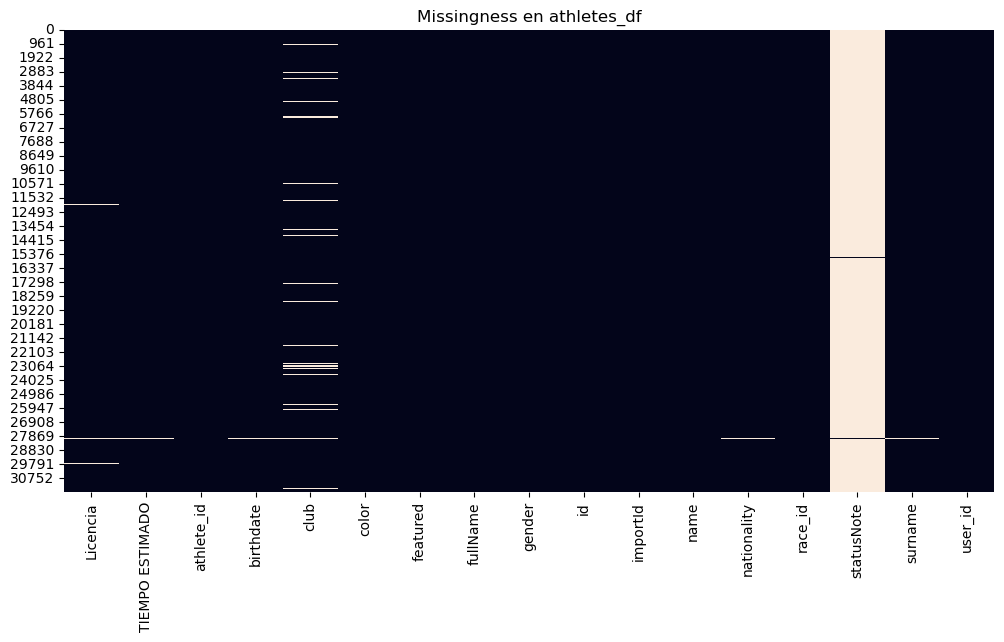


=== athletes_events_df ===


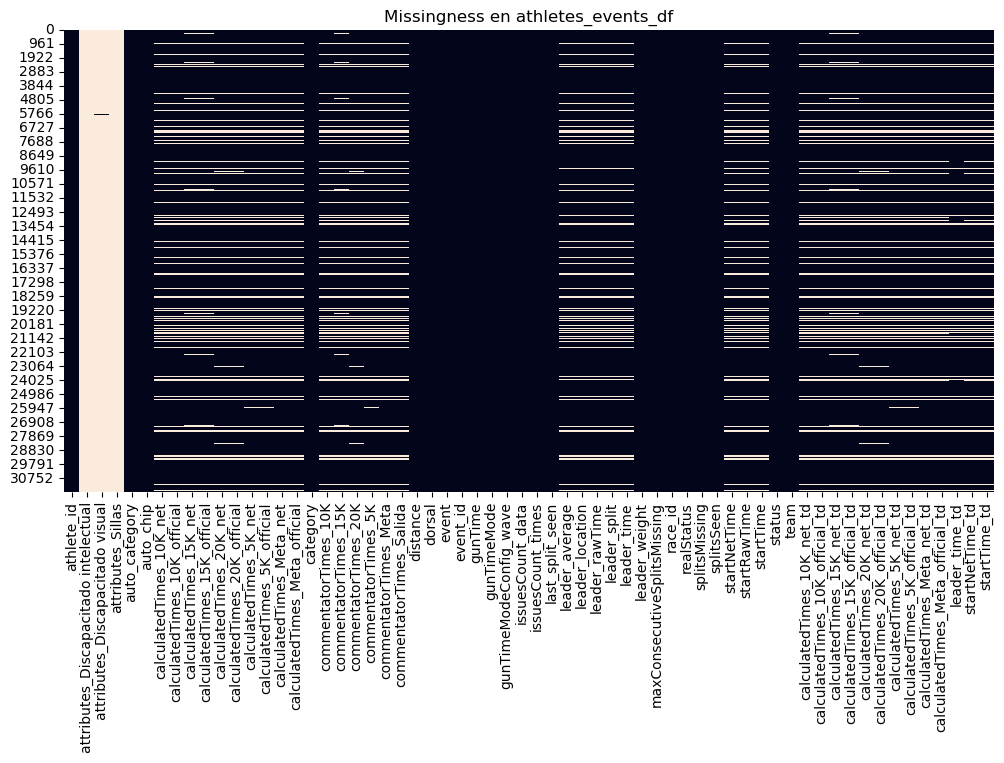


=== athletes_time_df ===


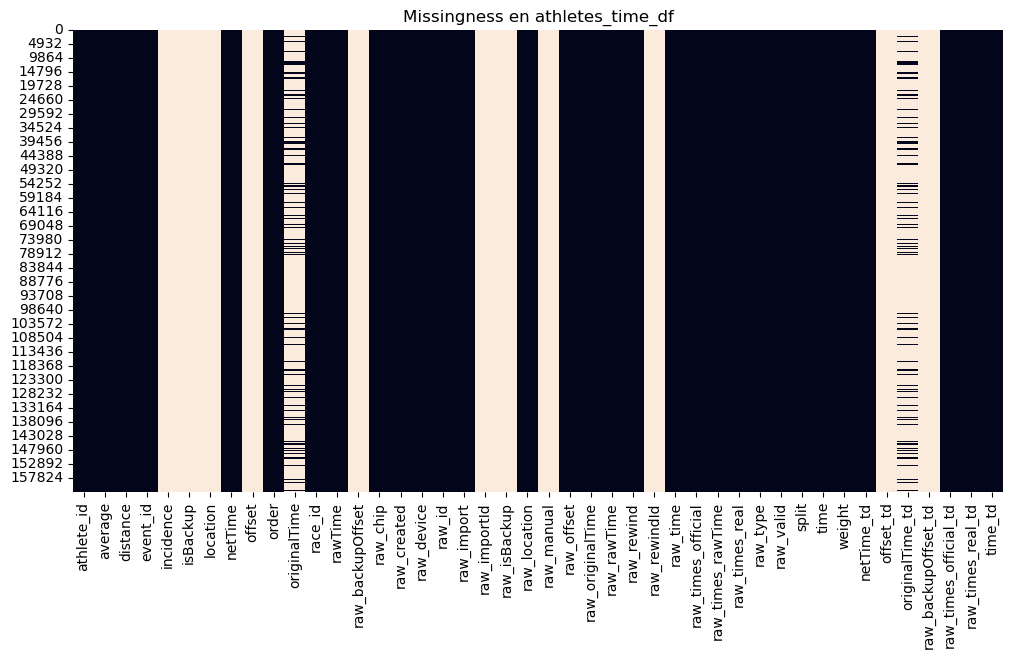


=== athletes_rankings_df ===


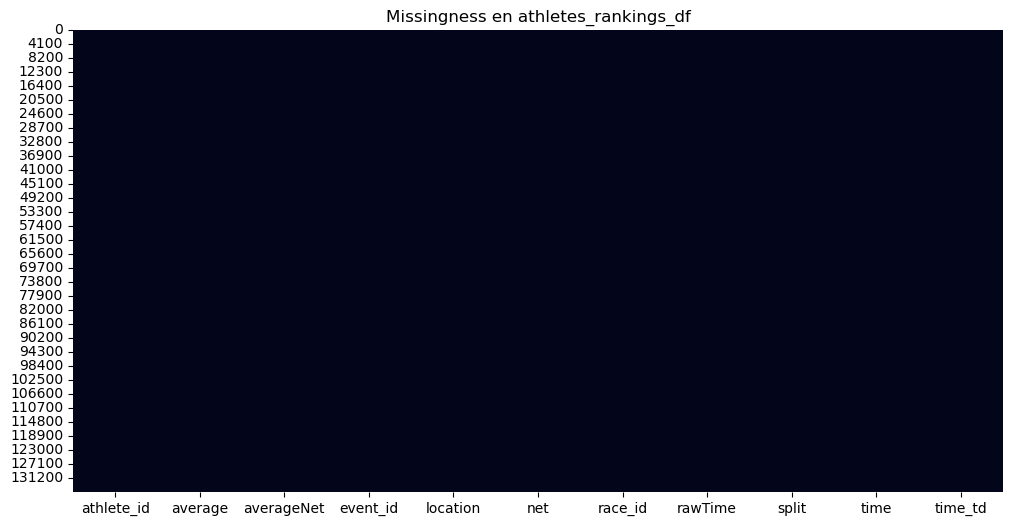


=== athletes_commentator_df ===


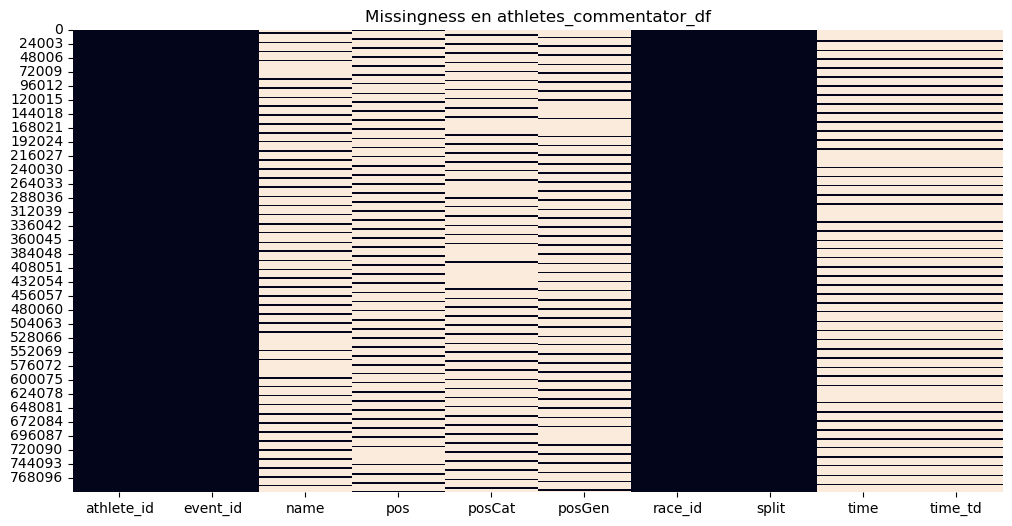


=== athletes_backups_df ===


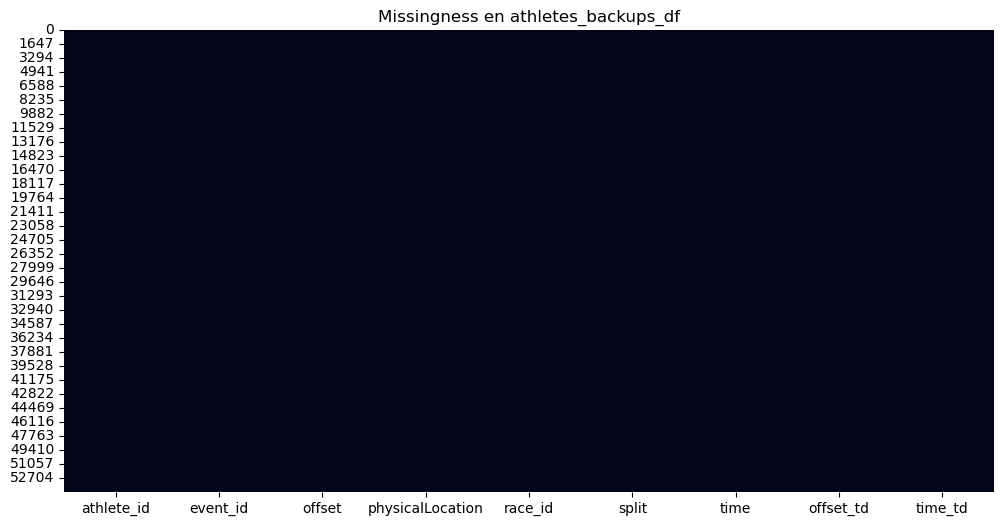


=== athletes_locations_df ===
⚠️ athletes_locations_df está vacío, no se puede mostrar heatmap

=== athletes_event_chips_df ===


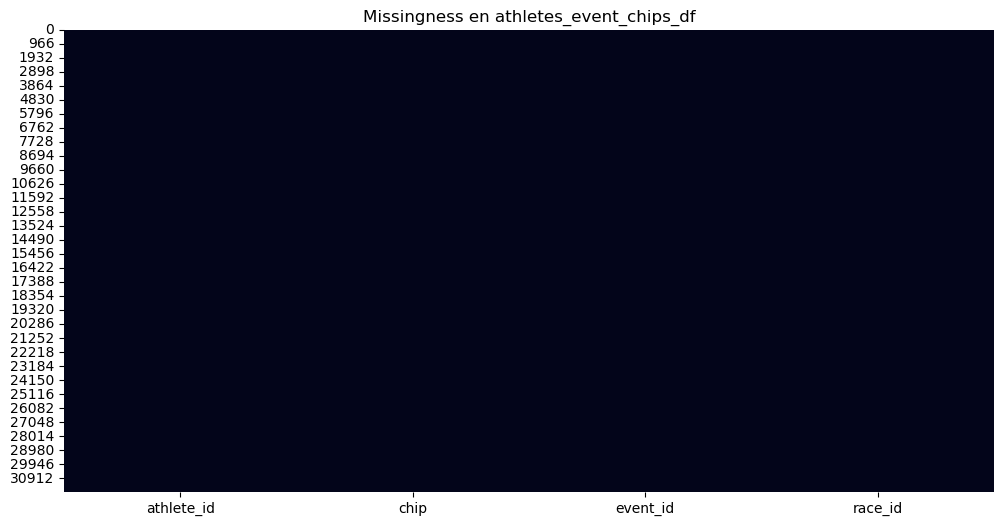


=== athletes_custom_rankings_df ===
⚠️ athletes_custom_rankings_df está vacío, no se puede mostrar heatmap

=== athletes_penalties_df ===
⚠️ athletes_penalties_df está vacío, no se puede mostrar heatmap

=== athletes_team_type_df ===
⚠️ athletes_team_type_df está vacío, no se puede mostrar heatmap

=== issues_df ===


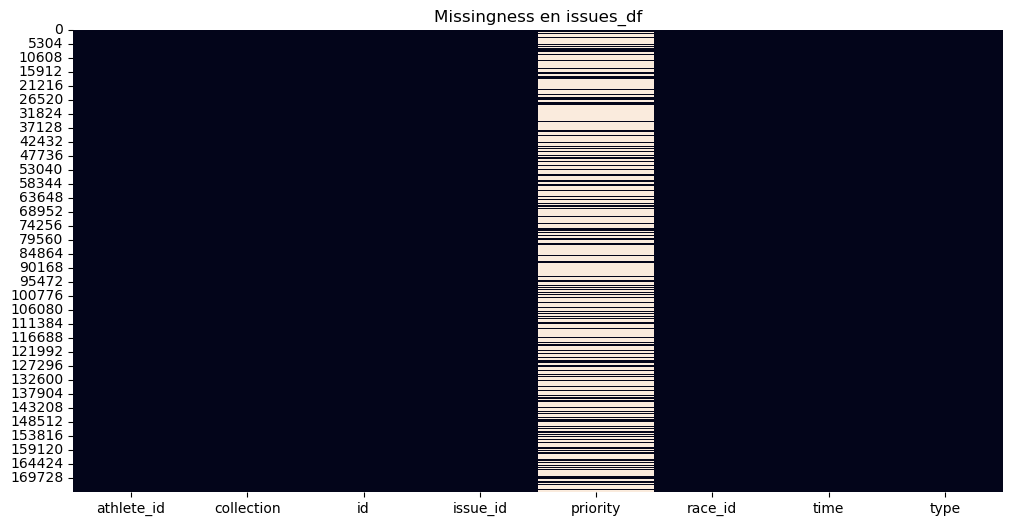


=== issues_data_df ===


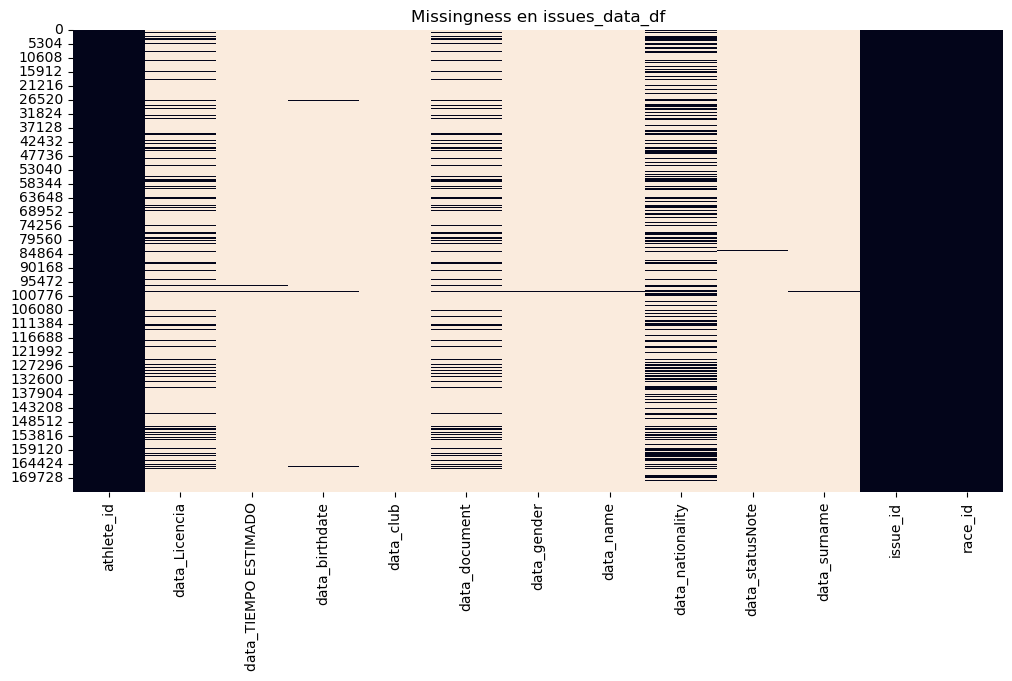


=== issues_events_df ===


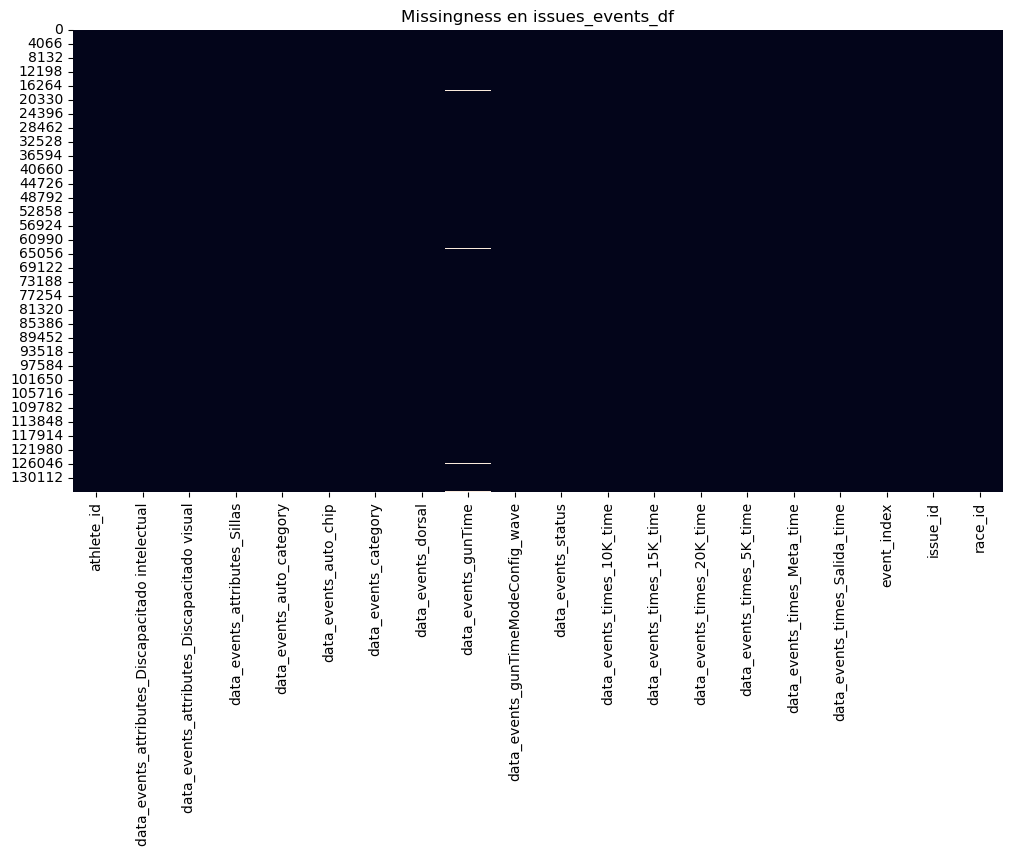


=== issues_times_df ===


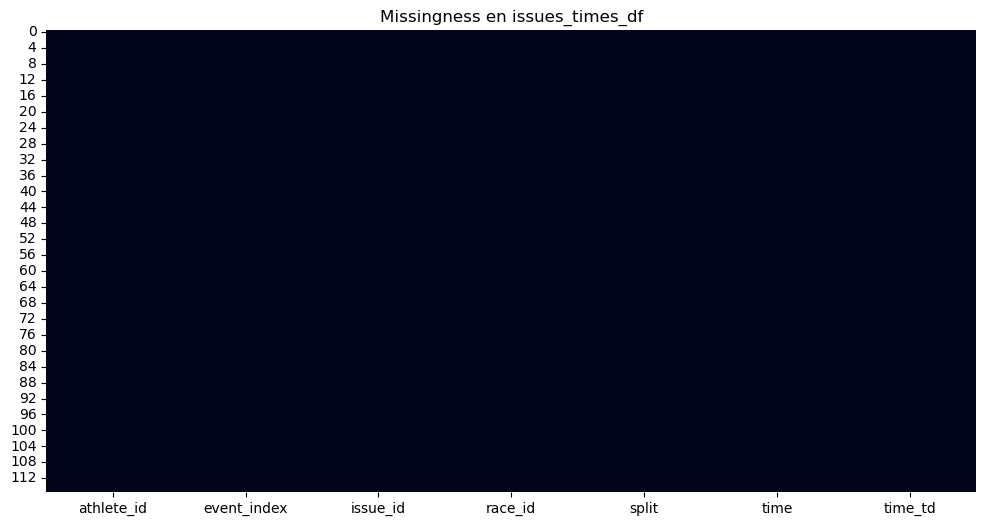


=== issues_attributes_df ===


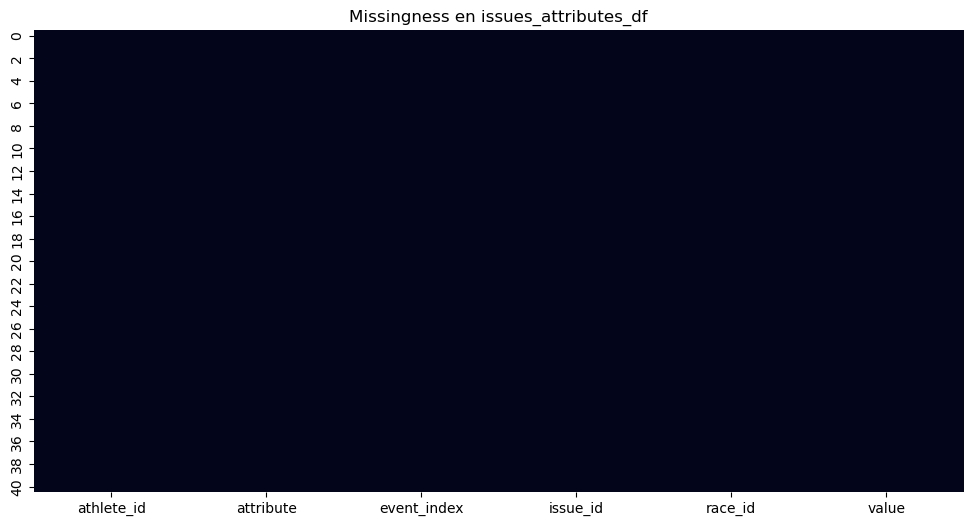


=== issues_chips_df ===


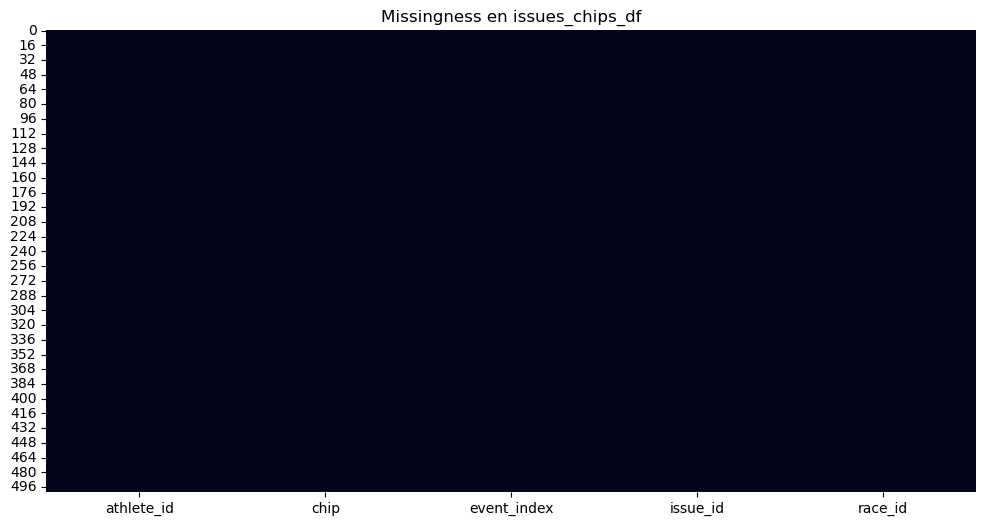

In [ ]:
for name, df in dfs2.items():
    print(f"\n=== {name} ===")
    try:
        if df.empty:
            print(f"{name} está vacío, no se puede mostrar heatmap")
        else:
            missing_heatmap(df, name)
    except Exception as e:
        print(f"Error en missing_heatmap para {name}: {e}")

- Las variables en el daraframe de athletes_df son generales y su ausencia no indican un fallo enorme (en este caso solo tenemos como ausencia significativa a statusNote, que son notas sobre el porque se ha cambiado el estado del atleta, que nos puede ser útil en algunos casos). 

- En athletes_events_df tampoco vemos muchos fallos, sobre todo porque la mayoría hacen referencia a datos de tiempo faltantes y es justo lo que queremos estudiar.

- En athletes_times_df vemos un problema parecido, con el que no trataremos con las variables con mas de ese porcentaje de issues que no sirvan en nuestro proyecto. 

- En todos los dataframes de issues, al ser problemas individuales, cualquier información que podamos obtener es importante, por lo que tampoco prescindimos de ninguna columna. 

**birthdate** (fecha de nacimiento)

- Tipo: fecha personal, estática, no derivada de sensores.

- 11% de missings

**gunTime, raw_time** y otros timestamps de carrera

- eventos en tiempo real (inicio de carrera, pasos por meta, etc.).

- Missings < 1.5 % (muy pocos).

Estos tiempos se usan para calcular intervalos (netTime, split, etc.). No conviene imputar: introducir un tiempo inventado rompe la secuencia de tiempos reales. En caso de necesitar valores completos para visualización, se puede: Propagar hacia adelante (ffill) dentro de cada athlete_id (si la lógica lo permite). Pero solo para visualización, no para análisis de rendimiento.

Se mantiene NaT. Añadir columna binaria _is_missing. Solo en casos de debugging o plots, usar una fecha simbólica.

**Variables de tiempo numéricas** (e.g. startTime, startNetTime, startRawTime, calculatedTimes_*, leader_time, etc.)

Representan tiempos en milisegundos o timedeltas. Missings entre 13 % y 16 %. No se deben imputar con -1 si van a participar en análisis de rendimiento. Podría sesgar promedios o percentiles. Mejor mantener NaN, y si se necesita calcular estadísticas, trabajar con funciones que lo ignoren (np.nanmean, etc.). Si es necesario un marcador explícito, usa -1 pero documentando que es “faltante”, no valor válido.

Recomendación: Mantener NaN (o -1 solo si tu pipeline no admite NaN). 

No vamos a prescindir de ninguna fila ni valor con vacios o nulos, ya que creemos que son parte del problema y conviene mantenerlos. Son totalmente missings MCAR dada la aleatoriedad de la que gozan. 

Pasamos a evaluar la consistencia de los tipos de datos en las variables. 

### Consistencia datos

In [ ]:
def describe_dfs(dfs_dict, n_examples=10, n_examples_by_type=3):
    
    for df_name, df in dfs_dict.items():
        print(f"=== DataFrame: {df_name} ===")
        if df.empty:
            print("DataFrame vacío.\n")
            continue
        
        for col in df.columns:
            col_data = df[col]
            types_present = col_data.map(type).unique()
            n_nulls = col_data.isna().sum()
            n_empty_strings = col_data.eq('').sum() if col_data.dtype == object else 0
            examples = col_data.dropna().unique()[:n_examples]
            
            examples_by_type = {}
            for t in types_present:
                examples_of_type = col_data[col_data.map(type) == t].dropna().unique()[:n_examples_by_type]
                examples_by_type[t.__name__] = examples_of_type
            
            print(f"Columna: {col}")
            print(f"  Tipos de datos distintos: {types_present}")
            print(f"  Nulos: {n_nulls}, Strings vacíos: {n_empty_strings}")
            print(f"  Ejemplos generales: {examples}")
            print(f"  Ejemplos por tipo de dato: {examples_by_type}")
        print("\n")

Vemos bastantes inconsistencias, que tratamos de la siguiente forma: 

- Si la inconsistencias se dan entre variables que tienen diferencias en sus caracteres, por ejemplo numeros en una y letras en otra, se convierten segun el tipo más normal para esa variable (en nuestro caso la mayoria son ids, que pasarán a ser strings). 

- Si la inconsistencia es con solo datos numéricos, pero estan en formatos distintos, se pasan todos a int o float. Si son todos letras u otros caracteres, se pasan todos a str

In [9]:
import pandas as pd
import numpy as np

def armonizar_columnas(db_dict: dict) -> dict:

    def detectar_tipos(serie):
        tipos = set()
        for v in serie:
            if pd.isna(v):
                tipos.add("nulo")
            elif isinstance(v, (int, float)):
                tipos.add("num")
            elif isinstance(v, str):
                if v.strip() == "":
                    tipos.add("vacio")
                else:
                    tipos.add("str")
            else:
                tipos.add("otro")
        return tipos

    # identificar claves compartidas (_id, _index) y columnas que no deben tocarse
    clave_cols = set()
    col_count = {}
    for df in db_dict.values():
        for col in df.columns:
            if col.endswith("_id") or col.endswith("_index"):
                col_count[col] = col_count.get(col, 0) + 1
    clave_cols = {col for col, c in col_count.items() if c > 1}

    report = {"modificadas": [], "no_modificadas": []}
    tipos_detectados_por_columna = {}

    for nombre_df, df in db_dict.items():
        tipos_detectados_por_columna[nombre_df] = {}
        for col in df.columns:
            tipos = detectar_tipos(df[col])
            tipos_detectados_por_columna[nombre_df][col] = list(tipos)

            # athlete_id 
            if col == "athlete_id":
                df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
                df[col] = df[col].astype(str)
                report["modificadas"].append({
                    "tabla": nombre_df,
                    "columna": col,
                    "tipos_detectados": list(tipos),
                    "accion": "athlete_id → convertir todos a str"
                })
                continue  # Saltamos reglas generales para esta columna

            # proteger columnas claves
            if col in clave_cols or "otro" in tipos:
                report["no_modificadas"].append({
                    "tabla": nombre_df,
                    "columna": col,
                    "razon": "columna protegida (clave o tipo no permitido)",
                    "tipos_detectados": list(tipos)
                })
                continue
            if len(tipos) <= 1:
                report["no_modificadas"].append({
                    "tabla": nombre_df,
                    "columna": col,
                    "razon": "solo un tipo",
                    "tipos_detectados": list(tipos)
                })
                continue

            accion = None

            if tipos == {"num", "str"}:
                df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
                accion = "num → str"

            elif tipos == {"num", "vacio"}:
                df[col] = df[col].replace("", np.nan)
                accion = "vacio → NaN"

            elif tipos == {"str", "nulo"}:
                df[col] = df[col].replace({np.nan: ""})
                accion = "nulo → ''"

            elif tipos == {"num", "str", "nulo"}:
                df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else ("" if pd.isna(x) else x))
                accion = "num → str, nulo → ''"

            elif tipos == {"num", "str", "vacio"}:
                df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
                accion = "num → str"

            elif tipos == {"num", "nulo", "vacio"}:
                df[col] = df[col].replace("", np.nan)
                accion = "vacio → NaN"

            elif tipos == {"str", "nulo", "vacio"}:
                df[col] = df[col].replace({np.nan: ""})
                accion = "nulo → ''"

            elif tipos == {"num", "str", "nulo", "vacio"}:
                df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else ("" if pd.isna(x) else x))
                accion = "num → str, nulo → ''"

            if accion:
                report["modificadas"].append({
                    "tabla": nombre_df,
                    "columna": col,
                    "tipos_detectados": list(tipos),
                    "accion": accion
                })
                if col in clave_cols:
                    for otro_nombre, otro_df in db_dict.items():
                        if otro_nombre != nombre_df and col in otro_df.columns:
                            db_dict[otro_nombre][col] = df[col].copy()
            else:
                report["no_modificadas"].append({
                    "tabla": nombre_df,
                    "columna": col,
                    "razon": "sin regla aplicable",
                    "tipos_detectados": list(tipos)
                })

    return {
        "dataframes": db_dict,
        "report": report,
        "tipos_detectados": tipos_detectados_por_columna
    }

In [10]:
resultado = armonizar_columnas(dfs2)

C:\Users\mario\AppData\Local\Temp\ipykernel_17936\3574232961.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace("", np.nan)


In [ ]:
describe_dfs(resultado, 5, 5)

=== DataFrame: athletes_df ===
Columna: Licencia
  Tipos de datos distintos: [<class 'float'> <class 'str'>]
  Nulos: 139, Strings vacíos: 30295
  Ejemplos generales: ['' '7019268' 'CY51919' 'VC012' '2063919']
  Ejemplos por tipo de dato: {'float': array([], dtype=object), 'str': array(['', '7019268', 'CY51919', 'VC012', '2063919'], dtype=object)}
Columna: TIEMPO ESTIMADO
  Tipos de datos distintos: [<class 'NoneType'> <class 'str'> <class 'float'>]
  Nulos: 42, Strings vacíos: 156
  Ejemplos generales: ['Entre 1h35 y 1h40' 'Menos 1h15' 'Entre 2h00 y 2h15' 'Entre 1h25 y 1h30'
 'Entre 1h50 y 1h55']
  Ejemplos por tipo de dato: {'NoneType': array([], dtype=object), 'str': array(['Entre 1h35 y 1h40', 'Menos 1h15', 'Entre 2h00 y 2h15',
       'Entre 1h25 y 1h30', 'Entre 1h50 y 1h55'], dtype=object), 'float': array([], dtype=object)}
Columna: athlete_id
  Tipos de datos distintos: [<class 'int'> <class 'str'>]
  Nulos: 0, Strings vacíos: 0
  Ejemplos generales: [31 159 160 191 192]
  Ejempl

In [ ]:
import pandas as pd

def resumen_diccionario_dfs(dic_dfs):
    resumen_list = []

    for nombre, df in dic_dfs.items():
        if not isinstance(df, pd.DataFrame):
            print(f"'{nombre}' no es un DataFrame, se omite.")
            continue
        
        for col in df.columns:
            resumen_list.append({
                "DataFrame": nombre,
                "Columna": col,
                "Tipo de Dato": df[col].dtype
            })
    
    resumen_df = pd.DataFrame(resumen_list)
    return resumen_df

Vesmos como se h arreglado el problema que teníamos con los tipos de las variables.

In [11]:
dfs_final = resultado['dataframes']

Pasamos a ver los duplicados por columna

In [ ]:
duplicados_info = {}

for df_name, df in dfs_final.items():
    if df.empty:
        continue

    if df_name == 'athletes_df':
        dup = df[df.duplicated(subset=['athlete_id'], keep=False)]
    else:
        dup = df[df.duplicated(keep=False)]
    
    duplicados_info[df_name] = {
        'num_duplicados': dup.shape[0],
        'duplicados_df': dup
    }

for df_name, info in duplicados_info.items():
    print(f"{df_name}: {info['num_duplicados']} duplicados")

athletes_df: 0 duplicados
athletes_events_df: 0 duplicados
athletes_time_df: 0 duplicados
athletes_rankings_df: 0 duplicados
athletes_commentator_df: 115670 duplicados
athletes_backups_df: 0 duplicados
athletes_event_chips_df: 0 duplicados
issues_df: 0 duplicados
issues_data_df: 134 duplicados
issues_events_df: 0 duplicados
issues_times_df: 0 duplicados
issues_attributes_df: 0 duplicados
issues_chips_df: 0 duplicados


El unico dataframe que podemos ver que tiene duplicados es issues_data_df, pero ello se debe a su construcción, ya que no tiene id propio. 

## Análisis descriptivo

Vamos a pasar a hacer un análisis descriptivo simple de la carrera, que nos enseñe valores clave para poder entender la mayoría de variables

In [ ]:
import pandas as pd
import numpy as np

def imprimir_resumen_descriptivo(df: pd.DataFrame, nombre_df: str):
    print(f"\n{'='*80}")
    print(f"ANÁLISIS DEL DATAFRAME: {nombre_df}")
    print(f"{'-'*80}")
    print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]:,}")
    print(f"Uso de memoria: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

    tipos = df.dtypes.value_counts()
    print("\nTipos de columnas:")
    for t, c in tipos.items():
        print(f"  - {t}: {c}")

    print(f"\n{'-'*80}")
    print("RESUMEN DE CADA VARIABLE:")
    print(f"{'-'*80}")

    for col in df.columns:
        serie = df[col]
        tipo = str(serie.dtype)

        if pd.api.types.is_datetime64_any_dtype(serie):
            try:
                serie = serie.dt.tz_localize(None)
            except Exception:
                pass

        nulos = serie.isna().sum()
        vacíos = (serie == "").sum() if serie.dtype == "object" else 0
        únicos = serie.nunique(dropna=True)

        print(f"\n🧩 Columna: {col}")
        print(f"   Tipo: {tipo}")
        print(f"   Valores únicos: {únicos:,}")
        print(f"   Nulos: {nulos:,} | Vacíos: {vacíos:,}")

        # Numéricas
        if pd.api.types.is_numeric_dtype(serie):
            desc = serie.describe(percentiles=[.25, .5, .75])
            media = desc.get("mean", np.nan)
            mediana = desc.get("50%", np.nan)
            desv = desc.get("std", np.nan)
            minimo = desc.get("min", np.nan)
            maximo = desc.get("max", np.nan)
            q1 = desc.get("25%", np.nan)
            q3 = desc.get("75%", np.nan)
            rango = maximo - minimo if pd.notna(maximo) and pd.notna(minimo) else np.nan
            iqr = q3 - q1 if pd.notna(q3) and pd.notna(q1) else np.nan

            print(f"   ▫️ Media: {media:.3f}" if pd.notna(media) else "   ▫️ Media: no aplica")
            print(f"   ▫️ Mediana: {mediana:.3f}" if pd.notna(mediana) else "   ▫️ Mediana: no aplica")
            print(f"   ▫️ Desviación estándar: {desv:.3f}" if pd.notna(desv) else "   ▫️ Desviación estándar: no aplica")
            print(f"   ▫️ Mínimo: {minimo:.3f}" if pd.notna(minimo) else "   ▫️ Mínimo: no aplica")
            print(f"   ▫️ Máximo: {maximo:.3f}" if pd.notna(maximo) else "   ▫️ Máximo: no aplica")
            print(f"   ▫️ Rango: {rango:.3f}" if pd.notna(rango) else "   ▫️ Rango: no aplica")
            print(f"   ▫️ Q1 (25%): {q1:.3f} | Q3 (75%): {q3:.3f} | IQR: {iqr:.3f}")
            print(f"   ▫️ Skew: {serie.skew():.3f} | Kurtosis: {serie.kurt():.3f}")

        # Fechas
        elif pd.api.types.is_datetime64_any_dtype(serie):
            rango = (serie.max() - serie.min()).days if not serie.empty else "no aplica"
            años = serie.dt.year.mode()
            meses = serie.dt.month.mode()
            print(f"   ▫️ Fecha mínima: {serie.min()}")
            print(f"   ▫️ Fecha máxima: {serie.max()}")
            print(f"   ▫️ Rango de días: {rango}")
            print(f"   ▫️ Año más frecuente: {años.iloc[0] if not años.empty else 'no aplica'}")
            print(f"   ▫️ Mes más frecuente: {meses.iloc[0] if not meses.empty else 'no aplica'}")

        # Duraciones (timedelta)
        elif pd.api.types.is_timedelta64_dtype(serie):
            print(f"   ▫️ Duración mínima: {serie.min()}")
            print(f"   ▫️ Duración media: {serie.mean()}")
            print(f"   ▫️ Duración máxima: {serie.max()}")
            print(f"   ▫️ Rango de tiempo: {serie.max() - serie.min()}")

        # Booleanas
        elif pd.api.types.is_bool_dtype(serie):
            prop_true = serie.mean() * 100
            print(f"   ▫️ % Verdaderos (True): {prop_true:.2f}%")
            print(f"   ▫️ % Falsos (False): {100 - prop_true:.2f}%")

        #Categóricas / texto
        else:
            try:
                modo = serie.mode(dropna=True)
                valor_más_frecuente = modo.iloc[0] if not modo.empty else "no aplica"
            except Exception:
                valor_más_frecuente = "no aplica"

            try:
                frecuencia_moda = serie.value_counts(dropna=True).iloc[0] if not serie.value_counts(dropna=True).empty else 0
                top5 = serie.value_counts(dropna=True).head(5)
            except Exception:
                frecuencia_moda = 0
                top5 = pd.Series(dtype="object")

            prop_nulos_vacios = (nulos + vacíos) / len(df) if len(df) > 0 else np.nan

            print(f"   ▫️ Moda: {valor_más_frecuente} ({frecuencia_moda} ocurrencias)")
            print(f"   ▫️ % Nulos + Vacíos: {prop_nulos_vacios*100:.2f}%")
            if not top5.empty:
                print("   ▫️ Top 5 valores:")
                for valor, freq in top5.items():
                    print(f"      - {valor}: {freq:,}")

    print(f"\n{'='*80}")
    print(f"Fin del análisis para: {nombre_df}")
    print(f"{'='*80}\n")


def analizar_diccionario_dfs(diccionario_dfs: dict):
    print("\n" + "="*100)
    print("INICIO DEL ANÁLISIS DESCRIPTIVO DE TODOS LOS DATAFRAMES")
    print("="*100)

    for nombre, df in diccionario_dfs.items():
        imprimir_resumen_descriptivo(df, nombre)

    print("\n" + "="*100)
    print("🏁 ANÁLISIS DESCRIPTIVO COMPLETO FINALIZADO")
    print("="*100)

In [46]:
resuultado = analizar_diccionario_dfs(dfs_final)


🧠 INICIO DEL ANÁLISIS DESCRIPTIVO DE TODOS LOS DATAFRAMES

📊 ANÁLISIS DEL DATAFRAME: athletes_df
--------------------------------------------------------------------------------
Filas: 31,683 | Columnas: 17
Uso de memoria: 26.50 MB

Tipos de columnas:
  - object: 14
  - datetime64[ns]: 1
  - bool: 1
  - int64: 1

--------------------------------------------------------------------------------
🔍 RESUMEN DE CADA VARIABLE:
--------------------------------------------------------------------------------

🧩 Columna: Licencia
   Tipo: object
   Valores únicos: 1,246
   Nulos: 0 | Vacíos: 30,434
   ▫️ Moda:  (30434 ocurrencias)
   ▫️ % Nulos + Vacíos: 96.06%
   ▫️ Top 5 valores:
      - : 30,434
      - 717635: 2
      - AG2026529: 2
      - NO054: 2
      - 1280905: 2

🧩 Columna: TIEMPO ESTIMADO
   Tipo: object
   Valores únicos: 13
   Nulos: 0 | Vacíos: 198
   ▫️ Moda: Entre 1h55 y 2h00 (4417 ocurrencias)
   ▫️ % Nulos + Vacíos: 0.62%
   ▫️ Top 5 valores:
      - Entre 1h55 y 2h00: 4,417
 

Podemos sacar algunas conclusiones interesantes para el análisis posterior: 

- birthdate tiene algunos valores demasiado bajos, por lo que es posible que tengamos que arreglar esta variable o avisar pre carrera de que algunos atletas pueden tener mal la fevha de nacimiento. 

- Cada atleta tiene un promedio de 5-6 issues, lo cuál es bastante y estudiaremos posteriormente. 

- La mayoría de los starttime están concentrados en valores bajos, con algtunos puntos altos que podrían ser outliers y estaría bien estudiar. 

- Hay algunos valores etremos en nettime que podrían ser atletas atipicos. 

- algunos valores no nulos existentes en offset que podrian indicar un ajuste del guntime del atleta en concreto. 



## EDA

Según hemos ido estudiando a lo largo de lo que llevamos de proyecto, vamos a hacer un análisis exploratorio enfocado a varias cuestiones y objetivos hipotéticos más concisos de los que planteamos al principio. 

- Detección de atletas con datos anómalos o inconsistentes (PRE-CARRERA)

- - Identificar atletas cuyos tiempos o registros no se ajustan al comportamiento esperado de otros atletas de la misma carrera o categoría (o usando informacion tambien de optras carreras incluso, para tener mas muestra).

- - Detectar problemas de cronometraje, errores de importación, duplicados de chips o inconsistencias de dispositivos antes de la carrera empiece (sobre todo centrado en datos personales y descriptivos)


- Conexión con incidencias históricas (issues)

- - Explorar los issues (sobretodo los de tipo athletetime o changestatus, que parecen ser los más extrapolables) para entender qué situaciones generan errores o descalificaciones.

- - Identificar correlaciones entre tipos de issues, splits afectados y características del atleta.


- Preparación para modelado predictivo (IN & POST-CARRERA)

- - Definir features confiables y derivadas. 

- - Analizar relaciones entre variables para preparar modelos de detección no supervisada, predicción de tiempos esperados (expected_time).


- Rellenar datos faltantes y predecir tiempos esperados (IN & POST-CARRERA)

- - Predecir tiempos en splits faltantes usando el comportamiento del atleta y de atletas similares.

- - Permitir reconstruir series completas para detectar errores o completar registros incompletos.


- Alertar automáticamente a cronometradores (IN CARRERA)

- - Detectar y reportar splits faltantes o valores anómalos antes de que afecten resultados oficiales.

- - Proporcionar justificación basada en reglas y comparación con otros atletas.

Para ello, enfocaremos nuestro análisis exploratorio a las variables **temporales** (ya que son las que más información nos dan sobre el contexto de la carrera con los datos que tenemos), aunque también estudireamos variables que nos parezcan importantes. Abajo un pequeño resumen de lo que vamos a hacer.

🔹 **NIVEL 1 — Atleta (athletes_df)**

- *Objetivo*: Validar y depurar los datos personales y estructurales de los atletas para evitar errores de identificación o clasificación.

- - name, surname, fullName: detección de duplicados, errores de importación, o uniones incorrectas.  
  → Técnica: comparación difusa (fuzzy matching) o Levehenstein.  

- - gender: validación lógica frente a nombre y categorías de participación.  
  → Técnica: detección de inconsistencias por reglas y proporciones. Uso de lista de nombres comunes y sus géneos para poder detectar problemas. 

- - birthdate: cálculo de edad, detección de valores extremos o imposibles.  
  → Técnica: percentiles + validación de rango (mín/max) según categoría.  

- - club: análisis de frecuencia, detección de duplicados textuales (errores de digitación).  
  → Técnica: limpieza y agrupación léxica (Levenshtein o fuzzy matching).  

- - nationality: homogenización de códigos ISO, detección de outliers geográficos.  

- - featured: análisis descriptivo (proporción y relación con rendimientos).   

---

🔹 **NIVEL 2 — Eventos (athletes_events_df)**

- *Objetivo*: Evaluar la consistencia y calidad de los datos de participación por evento.

- - startTime, startRawTime, gunTime: detección de incoherencias (salidas negativas, retrasos inusuales).  
  → diferencias temporales, límites ±3σ, clustering de retrasos.  

- - auto_category, category: comparativa entre categoría asignada automática y real.  
  → tabla de contingencia + tasa de error de asignación.  

- - status, realStatus: identificación de discrepancias o combinaciones imposibles.  

- - splitsMissing, maxConsecutiveSplitsMissing: detección de participantes con seguimiento irregular.  
  → conteos, detección de secuencias vacías.  

---

🔹 **NIVEL 3 — Tiempos / Splits (athletes_time_df)**

- *Objetivo*: Analizar la dinámica temporal, detectar anomalías, interpolar tiempos faltantes, estimar consistencia y preparar alertas pre-carrera.

- - time, netTime, originalTime: cálculo de tiempos en segundos, verificación de orden creciente.  
  → detección de outliers (Z-score, IQR), validación secuencial.

- - average: detección de velocidades imposibles.  
  → umbrales físicos + z-score sobre medias.

- - pace_split (derivada): ritmo por tramo o km, comparación con mediana de categoría o histórico del atleta.  
  → desviación estándar, comparación intra-categoría.

- - offset, raw_offset: análisis de ajustes manuales y latencias del chip.  
  → relacionarlo con cierts variables.

- - isBackup, raw_manual, raw_valid: evaluación de calidad de registro y proporción de correcciones.  
  → Técnica: agregaciones y comparativas por evento.

- - incidence: conteo y relación con registros corregidos o penalizados.  

- *Conexión con issues históricos*:  
  - Relacionar registros anómalos con issues previos (athletetime, changestatus).  
  - Identificar correlaciones entre tipo de issue, prioridad, splits afectados y características del atleta.

- *Preparación para modelado predictivo*:  
  - Features confiables: netTime, time, average, offset, pace_split, acumulado_desviacion.  
  - Técnicas: regresión, Random Forest, XGBoost, detección no supervisada (Isolation Forest, LOF).

- *Interpolación y predicción de tiempos faltantes*:  
  - Técnicas: splines cúbicos, regresión polinómica, filtros de Kalman.  
  - Objetivo: reconstruir series completas para detectar errores o completar registros incompletos.

- *Alertas automáticas in-carrera*:  
  - Detección de splits faltantes o valores anómalos antes de afectar resultados oficiales.  
  - Justificación basada en reglas y comparación con otros atletas.

- *Técnicas avanzadas sugeridas*:  
  - Detección de anomalías: Isolation Forest, DBSCAN, LOF (comparar con z-score).  
  - Interpolación temporal: splines cúbicos, regresión polinómica, Kalman Filters.  
  - Predicción de tiempos: modelos de regresión (Random Forest, XGBoost) para estimar meta o tramos faltantes.
 

---

🔹 **NIVEL 4 — Issues / Incidencias**

- *Objetivo*: Analizar el comportamiento histórico de errores y su relación con los datos de atletas, eventos y tiempos.

- - type: distribución de tipos de incidencias (athleteTime, changeStatus, etc.).  
  → Técnica: análisis de frecuencia.  

- - time: evolución temporal de incidencias (pre-carrera, en carrera, post-carrera).  
  → Técnica: series temporales.  

- *Objetivo final de este nivel*:  
  Identificar patrones recurrentes de error y sus causas probables (dispositivo, categoría, atleta, tipo de evento), con análisis contextual temporal (pre, durante y post carrera).  

---

🔹 **Variables temporales clave y su valor analítico**

| Variable temporal | Qué mide | Qué se hace con ella | Qué aporta |
|------------------|---------|--------------------|-----------|
| gunTime | Salida oficial | Comparar con startTime y startNetTime | Mide el retraso de salida real |
| startTime | Inicio registrado | Validar si coincide con gunTime o difiere excesivamente | Detecta salidas adelantadas o retrasadas |
| startRawTime | Tiempo crudo del chip | Comparar con startTime | Identifica errores del chip o correcciones |
| startNetTime | Diferencia neta desde la salida oficial | Analizar negativos o desviaciones | Indica posibles ajustes erróneos o chips mal sincronizados |
| time / netTime | Tiempos por split | Convertir a segundos, validar secuencia, outliers | Evalúa ritmo y consistencia |
| originalTime | Tiempo inicial antes de correcciones | Comparar con netTime | Mide el impacto de correcciones manuales |
| rawTime | Tiempo crudo del dispositivo | Analizar desviación respecto a netTime | Detección de fallos de hardware |
| offset / raw_offset | Diferencia entre tiempos ajustados | Analizar magnitud y signo | Mide compensaciones y latencias |
| created | Timestamp del registro | Ordenar cronológicamente los eventos | Permite reconstruir secuencia temporal real |
| penalties.offset | Penalización añadida | Incorporar al tiempo total | Evalúa efecto de sanciones en ranking final |



Empezamos conviertiendo el diccionario en dfs separados:

In [12]:
dfs = dfs_final

athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']
athletes_rankings_df = dfs['athletes_rankings_df']
athletes_commentator_df = dfs['athletes_commentator_df']
athletes_backups_df = dfs['athletes_backups_df']
athletes_locations_df = dfs['athletes_locations_df']
athletes_event_chips_df = dfs['athletes_event_chips_df']
athletes_custom_rankings_df = dfs['athletes_custom_rankings_df']
athletes_penalties_df = dfs['athletes_penalties_df']
athletes_team_type_df = dfs['athletes_team_type_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']
issues_attributes_df = dfs['issues_attributes_df']
issues_chips_df = dfs['issues_chips_df']

Los guardamos con extensión de archivo específica para observar cuánto ocupa

In [ ]:
import os

output_folder = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\calcular_peso"
os.makedirs(output_folder, exist_ok=True)

for name, df in dfs_final.items():
    print(f"Guardando {name}...")

    parquet_path = os.path.join(output_folder, f"{name}.parquet")
    df.to_parquet(parquet_path, index=False)
    
    csv_path = os.path.join(output_folder, f"{name}.csv.gz")
    df.to_csv(csv_path, index=False, compression='gzip')

print("\n✅ Todos los DataFrames se han guardado correctamente en:")
print(output_folder)

📦 Guardando athletes_df...
📦 Guardando athletes_events_df...
📦 Guardando athletes_time_df...
📦 Guardando athletes_rankings_df...
📦 Guardando athletes_commentator_df...
📦 Guardando athletes_backups_df...
📦 Guardando athletes_locations_df...
📦 Guardando athletes_event_chips_df...
📦 Guardando athletes_custom_rankings_df...
📦 Guardando athletes_penalties_df...
📦 Guardando athletes_team_type_df...
📦 Guardando issues_df...
📦 Guardando issues_data_df...
📦 Guardando issues_events_df...
📦 Guardando issues_times_df...
📦 Guardando issues_attributes_df...
📦 Guardando issues_chips_df...

✅ Todos los DataFrames se han guardado correctamente en:
C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\calcular_peso


Alrededor de 75 mb los datos de una sola carrera. Habrá que tenerlo en cuenta a la hora de almacenar los datos de bastantes carreras a la vez y usarlas para el análisis. 

### Nivel Atletas

Pasamos con el reporte de datos simples de atletas

In [ ]:
import pandas as pd
import Levenshtein

def eda_athletes(df, max_dist=2, top_n=50):
    """
    Exploración básica de athletes_df para detectar inconsistencias y posibles errores.
    Añade análisis especial de nacionalidades con distancia de Levenshtein entre códigos ISO-2 y otros formatos.
    """
    report = {}

    def detectar_casi_iguales(columna):
        valores = columna.dropna().astype(str).str.strip().str.lower()
        conteo = valores.value_counts()
        top_valores = conteo.head(top_n).index.tolist()
        posibles_errores = {}
        for val in valores.unique():
            if val in top_valores:
                continue
            for top_val in top_valores:
                if Levenshtein.distance(val, top_val) <= max_dist:
                    posibles_errores[val] = top_val
                    break
        return posibles_errores

    report['nombres_apellidos'] = {}
    for col in ['fullName', 'name', 'surname']:
        uniques = df[col].dropna().unique()
        n_null = df[col].isnull().sum()
        casi_iguales = detectar_casi_iguales(df[col])
        report['nombres_apellidos'][col] = {
            'n_unicos': len(uniques),
            'n_null': n_null,
            'ejemplos': list(uniques[:10]),
            'casi_iguales': casi_iguales
        }

    report['club'] = {}
    df['club_clean'] = df['club'].astype(str).str.strip().str.lower()
    n_null_club = df['club'].isnull().sum()
    top_clubs = df['club'].value_counts().head(10).to_dict()
    club_casi_iguales = detectar_casi_iguales(df['club'])
    report['club'] = {
        'n_null': n_null_club,
        'n_unicos': df['club'].nunique(),
        'top': top_clubs,
        'casi_iguales': club_casi_iguales
    }

    report['gender'] = {}
    genders = df['gender'].dropna().unique()
    n_null_gender = df['gender'].isnull().sum()
    report['gender']['unicos'] = list(genders)
    report['gender']['n_null'] = n_null_gender
    report['gender']['conteo'] = df['gender'].value_counts().to_dict()

    report['birthdate'] = {}
    if 'birthdate' in df.columns:
        df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
        edades = (pd.Timestamp.now() - df['birthdate']).dt.days // 365
        report['birthdate']['edades_estadisticas'] = edades.describe().to_dict()
        report['birthdate']['outliers'] = df.loc[(edades < 10) | (edades > 90), ['fullName', 'birthdate']]

    report['nationality'] = {}
    df['nationality_clean'] = df['nationality'].astype(str).str.upper().str.strip()
    n_null_nat = df['nationality_clean'].isnull().sum()
    codigos_invalidos = df.loc[~df['nationality_clean'].str.match(r'^[A-Z]{2}$', na=False), 'nationality_clean'].unique()
    report['nationality']['n_null'] = n_null_nat
    report['nationality']['codigos_invalidos'] = list(codigos_invalidos)
    report['nationality']['conteo'] = df['nationality_clean'].value_counts().to_dict()

    valores = df['nationality_clean'].dropna().unique()
    codigos_2 = [v for v in valores if len(v) == 2 and v.isalpha()]
    codigos_no_2 = [v for v in valores if len(v) != 2 and v.isalpha()]
    
    casi_iguales_nac = {}
    for val in codigos_no_2:
        for v2 in codigos_2:
            if Levenshtein.distance(val, v2) <= max_dist:
                casi_iguales_nac[val] = v2
                break
    report['nationality']['casi_iguales'] = casi_iguales_nac

    report['featured'] = {}
    if 'featured' in df.columns:
        report['featured']['conteo'] = df['featured'].value_counts().to_dict()
        report['featured']['proporcion'] = df['featured'].mean()

    return report

In [49]:
report_eda = eda_athletes(athletes_df)

In [50]:
report_eda

{'nombres_apellidos': {'fullName': {'n_unicos': 31629,
   'n_null': 0,
   'ejemplos': ['Abdezaliz Merzougui',
    'Floriane Hot',
    'Laura Santos',
    'Nicolas Navarro',
    'Dmitrijs Serjogins',
    'Maxime Lopes',
    'Ruben Ortiz Martínez',
    'Benjamin Franke',
    'Samuel Martin López',
    'Ciaran Lewis'],
   'casi_iguales': {'maria serra': 'marc serra',
    'david fernandez': 'david hernandez',
    'gustavo rodriguez': 'gustavo rodrigues',
    'sam evans': 'sue evans',
    'carlos dominguez': 'carlos domínguez'}},
  'name': {'n_unicos': 8057,
   'n_null': 0,
   'ejemplos': ['Abdezaliz',
    'Floriane',
    'Laura',
    'Nicolas',
    'Dmitrijs',
    'Maxime',
    'Ruben',
    'Benjamin',
    'Samuel',
    'Ciaran'],
   'casi_iguales': {'samuel': 'manuel',
    'ciaran': 'clara',
    'tom': 'pol',
    'isa': 'ana',
    'alexandre': 'alejandro',
    'núria': 'maria',
    'jhoan': 'joan',
    'luca': 'laura',
    'mariona': 'maria',
    'mark': 'marc',
    'ronan': 'joan',
    '

In [ ]:
import pandas as pd

def mostrar_reporte_tabular(reporte):
    for col in ['fullName', 'name', 'surname']:
        data = reporte['nombres_apellidos'][col]
        print(f"\n=== {col} ===")
        print(f"Unicos: {data['n_unicos']}, Nulos: {data['n_null']}")
        print(f"Ejemplos: {', '.join(data['ejemplos'])}")
        if 'casi_iguales' in data:
            casi = pd.DataFrame(list(data['casi_iguales'].items()), columns=[col, 'Sugerido'])
            print("Posibles errores tipográficos (casi iguales):")
            print(casi.head(10).to_string(index=False))  # solo primeros 10

    club = reporte['club']
    print("\n=== Clubes ===")
    print(f"Unicos: {club['n_unicos']}, Nulos: {club['n_null']}")
    print("Top 10 clubes:")
    print(pd.Series(club['top']).head(10))
    if 'casi_iguales' in club:
        casi_club = pd.DataFrame(list(club['casi_iguales'].items()), columns=['Club', 'Sugerido'])
        print("Posibles errores tipográficos (casi iguales):")
        print(casi_club.head(10).to_string(index=False))

    g = reporte['gender']
    print("\n=== Gender ===")
    print(f"Unicos: {g['unicos']}, Nulos: {g['n_null']}")
    print("Conteo:")
    print(pd.Series(g['conteo']))

    b = reporte['birthdate']
    print("\n=== Birthdate ===")
    print("Estadísticas de edades:")
    print(pd.Series(b['edades_estadisticas']))
    print("Outliers:")
    print(b['outliers'].head(5))

    n = reporte['nationality']
    print("\n=== Nationality ===")
    print(f"Nulos: {n['n_null']}")
    print(f"Codigos inválidos: {', '.join(n['codigos_invalidos'][:10])}")
    print("Top 10 códigos:")
    print(pd.Series(n['conteo']).head(10))

    print("\nPosibles nacionalidades mal escritas (según distancia de Levenshtein):")
    if 'casi_iguales' in n and len(n['casi_iguales']) > 0:
        for invalido, sugerido in n['casi_iguales'].items():
            print(f"  - '{invalido}' → posible '{sugerido}'")
    else:
        print("  No se detectaron nacionalidades sospechosas.")

    f = reporte['featured']
    print("\n=== Featured ===")
    print(f"Conteo: {f['conteo']}, Proporción: {f['proporcion']}")


In [52]:
mostrar_reporte_tabular(report_eda)


=== fullName ===
Unicos: 31629, Nulos: 0
Ejemplos: Abdezaliz Merzougui, Floriane Hot, Laura Santos, Nicolas Navarro, Dmitrijs Serjogins, Maxime Lopes, Ruben Ortiz Martínez, Benjamin Franke, Samuel Martin López, Ciaran Lewis
Posibles errores tipográficos (casi iguales):
         fullName          Sugerido
      maria serra        marc serra
  david fernandez   david hernandez
gustavo rodriguez gustavo rodrigues
        sam evans         sue evans
 carlos dominguez  carlos domínguez

=== name ===
Unicos: 8057, Nulos: 0
Ejemplos: Abdezaliz, Floriane, Laura, Nicolas, Dmitrijs, Maxime, Ruben, Benjamin, Samuel, Ciaran
Posibles errores tipográficos (casi iguales):
     name  Sugerido
   samuel    manuel
   ciaran     clara
      tom       pol
      isa       ana
alexandre alejandro
    núria     maria
    jhoan      joan
     luca     laura
  mariona     maria
     mark      marc

=== surname ===
Unicos: 27128, Nulos: 0
Ejemplos: Merzougui, Hot, Santos, Navarro, Serjogins, Lopes, Ortiz Martí

Como reflexión sobre este dataframe: 

- La mayoría de nombres y apellidos son nombres únicos, pero podemos ver algunos parecidos a otros a través de distancia de levehenstein con ligeras diferencias y que además no tienen sentido o por lo menos no son comunes (sasa, torr,... ), por lo que podríamnos tener un indicio de problemas de inmportación o escritura de nombres que habría que solucionar antes de empezar la carrera. 

- En los clubes ocurre algo similar, los nombres de los clubes varían siendo el mismo club de una persona a otra (runpac = runnpac), por lo que podríamos arreglarlo también antes de empezar la carrera. 

- Podemos ver que hay personas con rangos de edad muy avnazados (hay corriendo una persona de ¡100 años!), y aunque es posible, siempre esta bien comprobar edades que no cumplan con la edad mínima de competición o edades muy avanzadas 

- La variable featured en este caos no nos da información alguna, por lo que probablemente tengamos que identificar a los atletas más destacados en la propia carrera y asi tratarlos de forma más específica post carrera. 

### Nivel Atletas (Eventos)

Para esta parte vamos a pasar a estudiar ciertas variables interesantes: 

- La relación entre category y auto-category, para ver cuántas de las categorías se añadieron de forma automática (suponiendo que a través de alguna característica del atleta). 
- Distribución de los tiempos de salida de cada atleta (startTime) y detección a través de IQR de datos anómnalos de salida. 
- Comprobación de status de atleta para observar si tiene sentido con lo expresado en los datos y distribución de los mismos por categoría. 
- Proporción de backups
- Conteo de missing splits (seguidos o en general)

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustes visuales
sns.set(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (10, 5)

print("=== Análisis de las categorias ===")

auto_summary = (
    athletes_events_df[['auto_category', 'auto_chip']]
    .agg(['mean'])
    .T * 100
)
auto_summary.columns = ['%_True']
print(auto_summary, '\n')

=== Análisis de las categorias ===
                  %_True
auto_category  98.971057
auto_chip      99.753811 



Homogeneidad extrema en las asignaciones, el sistema de clasificación automática está funcionando correctamente y de forma consistente y hay un riesgo bajo de errores humanos en la categorización inicial. Sin embargo, esta homogeneidad también implica que si existe un error sistemático (auto_category), afectará a muchos atletas, pero en principio no prece importar. 

La mínima diferencia entre auto_category y auto_chip indica que algunos atletas podrían haber recibido el chip de forma manual (por sustitución o duplicación detectada). Pueden ser indicadores de problemas de lectura del chip o errores de importación.

Pasamos a analizar la salida 

In [16]:
# Verificar si las columnas tienen valores negativos
negativos_pos = (athletes_events_df['startTime'] < 0).sum()
negativos_neg = (athletes_events_df['startNetTime'] < 0).sum()

print(f"Valores negativos en startTime: {negativos_pos}")
print(f"Valores negativos en startNetTime: {negativos_neg}")

Valores negativos en startTime: 0
Valores negativos en startNetTime: 28


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("Análisis robusto de consistencia de salida por oleadas")

# Merge con datos de atletas
if 'gender' not in athletes_events_df.columns:
    athletes_events_df = athletes_events_df.merge(
        athletes_df[['athlete_id', 'gender']], on='athlete_id', how='left'
    )

# GunTime ya es datetime, aseguramos sin timezone
athletes_events_df['gunTime_local'] = athletes_events_df['gunTime'].dt.tz_localize(None)

# startRawTime ya es datetime
athletes_events_df['startRawTime_dt'] = athletes_events_df['startRawTime']

gun_summary = (
    athletes_events_df.groupby('gunTime_local')
    .size()
    .reset_index(name='num_athletes')
    .sort_values('gunTime_local')
)
print("\nPistoletazos detectados (gunTime por oleada)")
display(gun_summary)
num_waves = gun_summary.shape[0]
print(f"Total de oleadas detectadas: {num_waves}")

# --- Cálculo de delays ---
# Positivos: startTime_td (timedelta desde gun)
# --- Cálculo de delays ---
athletes_events_df['delay_sec'] = athletes_events_df['startNetTime_td'].dt.total_seconds()

# --- Detección de outliers robusta por oleada ---
def detectar_outliers_por_oleada(grupo):
    Q1 = grupo['delay_sec'].quantile(0.25)
    Q3 = grupo['delay_sec'].quantile(0.75)
    IQR = Q3 - Q1
    k = 3  # puedes ajustar a 1.5 si quieres hacerlo más sensible
    upper_bound = Q3 + k * IQR
    
    grupo['delay_category'] = np.select(
        [
            grupo['delay_sec'] < 0,
            grupo['delay_sec'] > upper_bound
        ],
        ['Extremadamente temprana', 'Extremadamente tardía'],
        default='Normal'
    )
    grupo['upper_bound'] = upper_bound  # opcional, para trazabilidad
    return grupo

# Aplicar la función por cada oleada
athletes_events_df = athletes_events_df.groupby('gunTime_local', group_keys=False).apply(detectar_outliers_por_oleada)

# --- Resumen general ---
delay_summary = athletes_events_df['delay_category'].value_counts(normalize=True) * 100
print("\n=== Distribución porcentual del delay de salida (por oleada) ===")
display(delay_summary.round(2))

# --- Outliers ---
outliers_tardios = athletes_events_df[athletes_events_df['delay_category'] == 'Extremadamente tardía']
outliers_tempranos = athletes_events_df[athletes_events_df['delay_category'] == 'Extremadamente temprana']

print(f"\nAtletas con retrasos extremos (tardíos): {len(outliers_tardios)}")
display(outliers_tardios[['athlete_id', 'event_id', 'category', 'gender', 
                          'startTime_td', 'startRawTime_dt', 'delay_sec', 'delay_category', 'gunTime_local']].head(10))

print(f"\nAtletas que salieron antes (tempranos): {len(outliers_tempranos)}")
display(outliers_tempranos[['athlete_id', 'event_id', 'category', 'gender', 
                            'startTime_td', 'startRawTime_dt', 'delay_sec', 'delay_category', 'gunTime_local']].head(10))


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(
    data=athletes_events_df,
    x='delay_sec',
    hue='delay_category',
    bins=60,
    kde=True,
    ax=axes[0]
)
axes[0].set_title("Distribución del delay de salida (robusto)")
axes[0].set_xlabel("Delay desde gunTime (s)")
axes[0].axvline(0, color='red', linestyle='--', label='Pistoletazo')
axes[0].axvline(upper_bound, color='red', linestyle='--', label='Límite superior (IQR)')
axes[0].legend()

sns.boxplot(
    data=athletes_events_df,
    x='category',
    y='delay_sec',
    hue='gender',
    ax=axes[1]
)
axes[1].set_title("Boxplot del delay de salida por categoría y género")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Análisis robusto de consistencia de salida por carrera y oleadas


NameError: name 'athletes_events_df' is not defined

In [28]:
# --- Análisis de rarezas por oleada ---
# Filtramos solo los atletas "raros" (tempranos o tardíos)
raros_df = athletes_events_df[
    athletes_events_df['delay_category'].isin(['Extremadamente temprana', 'Extremadamente tardía'])
]

# Calculamos el porcentaje de casos raros por oleada
porcentaje_raros_por_oleada = (
    raros_df['gunTime_local']
    .value_counts(normalize=True)
    .rename('porcentaje_sobre_raros')
    .mul(100)
    .reset_index()
    .rename(columns={'index': 'gunTime_local'})
    .sort_values('gunTime_local')
)

print("\n=== Distribución de casos raros por oleada (porcentaje sobre los raros) ===")
display(porcentaje_raros_por_oleada.round(2))

# Si quieres también ver el desglose de tempranos y tardíos por oleada:
desglose_raros = (
    raros_df.groupby(['gunTime_local', 'delay_category'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
    .round(2)
)

desglose_raros = desglose_raros.loc[~desglose_raros.index.duplicated(keep='first')]

print("\n=== Desglose porcentual de tipos de rareza (tempranos/tardíos) por oleada ===")
display(desglose_raros)


=== Distribución de casos raros por oleada (porcentaje sobre los raros) ===


gunTime_local  porcentaje_sobre_raros
5 2025-02-16 07:31:06                    2.50
4 2025-02-16 07:40:32                    3.75
2 2025-02-16 08:00:13                    5.00
1 2025-02-16 08:10:11                   13.75
6 2025-02-16 08:20:03                    2.50
3 2025-02-16 08:30:09                    5.00
0 2025-02-16 08:40:25                   67.50


=== Desglose porcentual de tipos de rareza (tempranos/tardíos) por oleada ===


delay_category                           Extremadamente tardía  \
gunTime_local       gunTime_local                                
2025-02-16 07:31:06 2025-02-16 07:31:06                   0.00   
2025-02-16 07:40:32 2025-02-16 07:40:32                   0.00   
2025-02-16 08:00:13 2025-02-16 08:00:13                   0.00   
2025-02-16 08:10:11 2025-02-16 08:10:11                   0.00   
2025-02-16 08:20:03 2025-02-16 08:20:03                  50.00   
2025-02-16 08:30:09 2025-02-16 08:30:09                   0.00   
2025-02-16 08:40:25 2025-02-16 08:40:25                  94.44   

delay_category                           Extremadamente temprana  
gunTime_local       gunTime_local                                 
2025-02-16 07:31:06 2025-02-16 07:31:06                   100.00  
2025-02-16 07:40:32 2025-02-16 07:40:32                   100.00  
2025-02-16 08:00:13 2025-02-16 08:00:13                   100.00  
2025-02-16 08:10:11 2025-02-16 08:10:11                   100.00  
2025-02-16 08:20:03 2025-02-16 08:20:03                    50.00  
2025-02-16 08:30:09 2025-02-16 08:30:09                   100.00  
2025-02-16 08:40:25 2025-02-16 08:40:25                     5.56

El número de gun times detectados y su distribución de atletas confirman la segmentación del evento en oleadas bien definidas (aproximadamente cada 10 minutos).

Aparecen algunos gunTime distintos con pocos atletas (2 especificamente), puede haber un problema de registro o redondeo temporal. CONSULTAR    

Más del 90 % de los participantes cruzaron la línea de salida entre 1 y 5 minutos después de su pistoletazo, lo que indica un flujo normal en eventos masivos por oleadas. Solo un porcentaje marginal (<2 %) presentó salidas negativas o retrasadas, atribuibles probablemente a errores de chip o reasignaciones. CONSULTAR

No se observa una correlación significativa en el género o en la categoria, como era de esperar, ya que en estos contextos los retrasos se dan mas por pelotones grandes que por implicaciones en estas variables. 

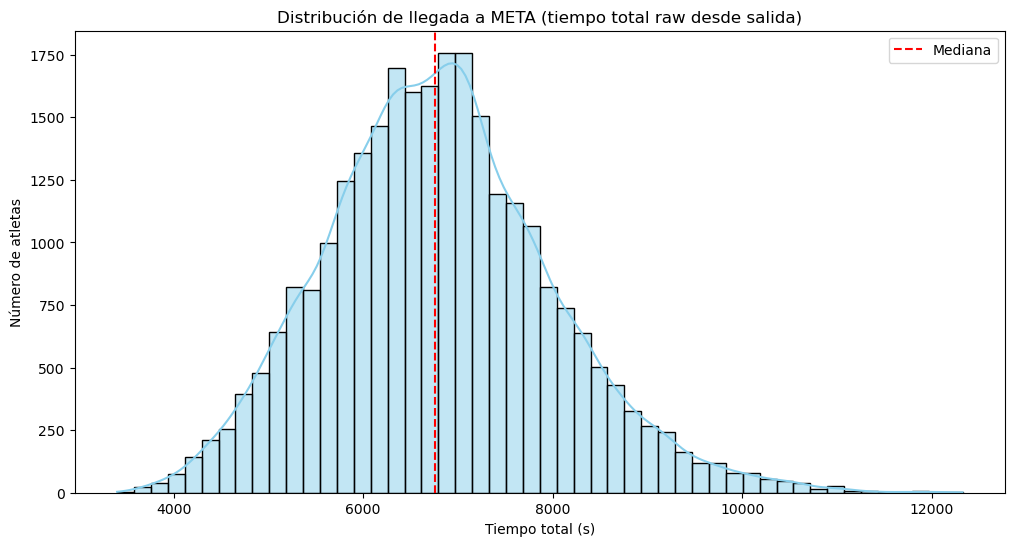

Mediana total a meta: 6757.1 s
MAD: 777.7 s
Atletas considerados outliers: 1445 de 27160

Ejemplos de outliers:
    athlete_id  average  distance event_id incidence isBackup location  \
1          160  0.20712     21097    Mitja       NaN      NaN            
2          191  0.18266     21097    Mitja       NaN      NaN            
3          192  0.18659     21097    Mitja       NaN      NaN            
4          195  0.19062     21097    Mitja       NaN      NaN            
54    Y9456D4Y  0.47777     21097    Mitja       NaN      NaN            
95    1B1425ZA  0.18900     21097    Mitja       NaN      NaN            
128   Z5163A69  0.48826     21097    Mitja       NaN      NaN            
131   1A5F4FA1  0.46493     21097    Mitja       NaN      NaN            
158   52Y97248  0.19883     21097    Mitja       NaN      NaN            
163   61AFBZAD  0.18939     21097    Mitja       NaN      NaN            

      netTime  offset  order  originalTime  \
1     4364800     NaN      

In [ ]:
# Filtramos solo la fila de META para cada atleta
df_meta = athletes_time_df[athletes_time_df['split'] == 'Meta'].copy()

# Asegurarnos de tener StartRAUTime disponible (desde AthleteEvents_df)
df_meta = df_meta.merge(
    athletes_events_df[['athlete_id', 'event_id', 'race_id', 'startRawTime']],
    on=['athlete_id', 'event_id', 'race_id'],
    how='left'
)

# Calcular tiempo total en segundos desde salida hasta meta
df_meta['total_time_sec'] = (df_meta['rawTime'] - df_meta['startRawTime']).dt.total_seconds()

# --- Histograma + KDE ---
plt.figure(figsize=(12,6))
sns.histplot(df_meta['total_time_sec'], bins=50, kde=True, color='skyblue')
plt.title("Distribución de llegada a META (tiempo total raw desde salida)")
plt.xlabel("Tiempo total (s)")
plt.ylabel("Número de atletas")
plt.axvline(df_meta['total_time_sec'].median(), color='red', linestyle='--', label='Mediana')
plt.legend()
plt.show()

# --- Estadísticas robustas ---
median_time = np.median(df_meta['total_time_sec'].dropna())
mad_time = np.median(np.abs(df_meta['total_time_sec'] - median_time).dropna())

threshold_upper = median_time + 3 * mad_time
threshold_lower = median_time - 3 * mad_time

outliers = df_meta[(df_meta['total_time_sec'] > threshold_upper) |
                   (df_meta['total_time_sec'] < threshold_lower)]

print(f"Mediana total a meta: {median_time:.1f} s")
print(f"MAD: {mad_time:.1f} s")
print(f"Atletas considerados outliers: {len(outliers)} de {len(df_meta)}")
print("\nEjemplos de outliers:")
print(outliers.head(10))

Análisis de status y realStatus
Casos incoherentes en estados: 0


Empty DataFrame
Columns: [athlete_id, event_id, status, realStatus, startTime_td]
Index: []


=== Frecuencia de status por categoría ===


status      disqualified  finished  notstarted  retired
category                                               
                       0        18           6       11
F35                    4      1044         205       20
F40                    4       876         147       14
F45                   10       720         128       11
F50                   11       544          88       11
F55                    6       312          39        9
F60                    0       124          21        3
F65                    2        23           4        2
F70                    0         7           3        2
F75                    0         2           0        0
F80                    0         1           0        0
M35                   12      2145         369       26
M40                   11      1739         294       25
M45                   22      1438         259       26
M50                   11      1315         221       17
M55                   10       810         129       15
M60                   11       443          51        6
M65                    5       171          17        1
M70                    1        28           5        1
M75                    0        10           4        0
M80                    0         4           2        1
No binario             1        35           6        0
Senior F              32      6118         847       85
Senior M              40      7354         993      128
Sub 23 F               3       737         120       10
Sub 23 M               4       943         122       18


=== Frecuencia de realStatus por categoría ===


realStatus  finished  notstarted  running
category                                 
                  18           6       11
F35             1048         205       20
F40              880         147       14
F45              730         128       11
F50              555          88       11
F55              318          39        9
F60              124          21        3
F65               25           4        2
F70                7           3        2
F75                2           0        0
F80                1           0        0
M35             2157         369       26
M40             1750         294       25
M45             1460         259       26
M50             1326         221       17
M55              820         129       15
M60              454          51        6
M65              176          17        1
M70               29           5        1
M75               10           4        0
M80                4           2        1
No binario        36           6        0
Senior F        6149         850       83
Senior M        7394         993      128
Sub 23 F         740         120       10
Sub 23 M         947         122       18

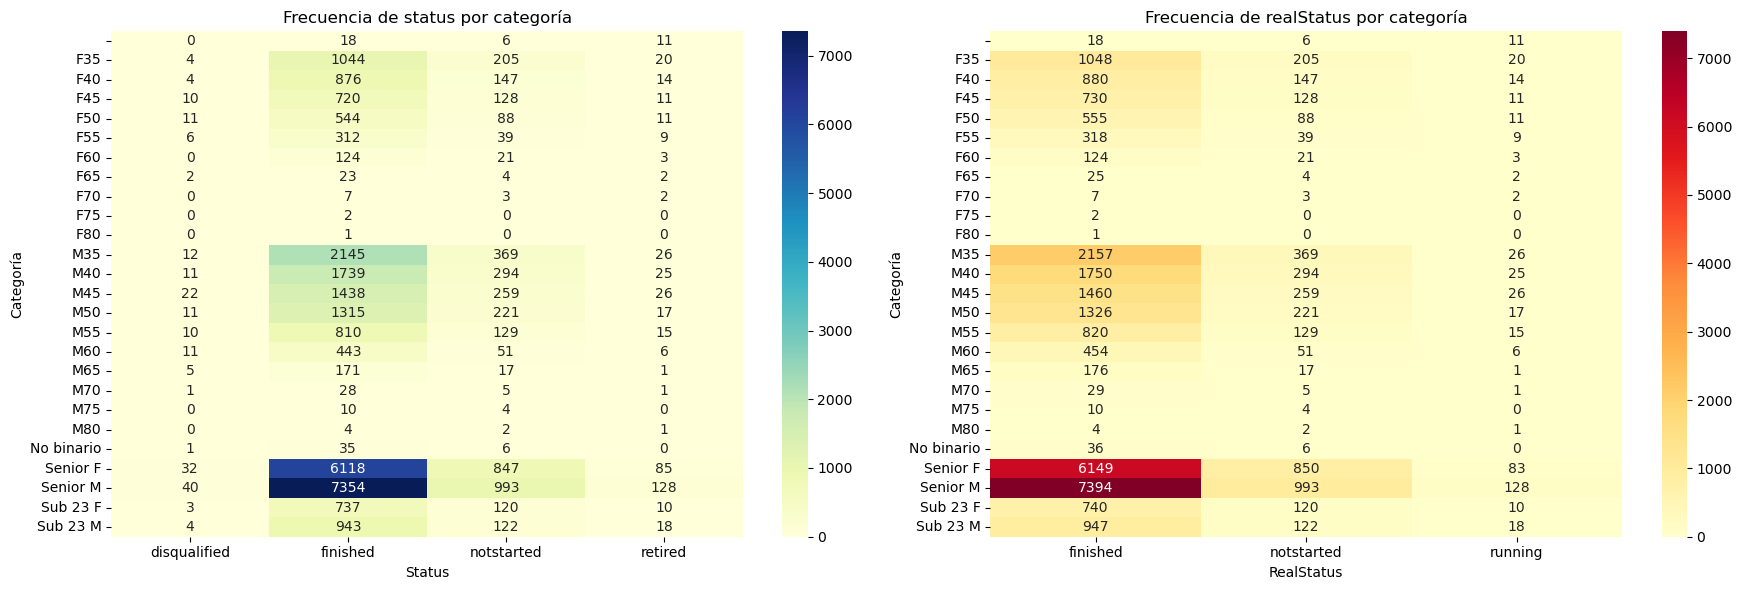

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("Análisis de status y realStatus")

atletas_con_meta = athletes_time_df[athletes_time_df['split'] == 'Meta'][['athlete_id', 'event_id', 'race_id']]

cond_finalizado_sin_meta = (
    (athletes_events_df['status'] == 'finished') &
    (~athletes_events_df.set_index(['athlete_id','event_id','race_id']).index.isin(
        atletas_con_meta.set_index(['athlete_id','event_id','race_id']).index
    ))
)

cond_sin_salida_con_tiempo = (
    (athletes_events_df['status'] == 'notstarted') &
    (athletes_events_df['startTime_td'].notna())
)

incoherentes = athletes_events_df[cond_finalizado_sin_meta | cond_sin_salida_con_tiempo]
print(f"Casos incoherentes en estados: {len(incoherentes)}")
display(incoherentes[['athlete_id', 'event_id', 'status', 'realStatus', 
                      'startTime_td']].head(10))

status_summary = athletes_events_df.groupby(['category', 'status']).size().unstack(fill_value=0)
realstatus_summary = athletes_events_df.groupby(['category', 'realStatus']).size().unstack(fill_value=0)

print("\n=== Frecuencia de status por categoría ===")
display(status_summary)

print("\n=== Frecuencia de realStatus por categoría ===")
display(realstatus_summary)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(status_summary, cmap="YlGnBu", ax=axes[0], annot=True, fmt="d")
axes[0].set_title("Frecuencia de status por categoría")
axes[0].set_xlabel("Status")
axes[0].set_ylabel("Categoría")

sns.heatmap(realstatus_summary, cmap="YlOrRd", ax=axes[1], annot=True, fmt="d")
axes[1].set_title("Frecuencia de realStatus por categoría")
axes[1].set_xlabel("RealStatus")
axes[1].set_ylabel("Categoría")

plt.tight_layout()
plt.show()

status hace referencia al estado en carrera del atleta, y realstatus al estado automatico del mismo, sin intervención humana y sin que haya temrinado la carrera.

No se detectaron casos incoherentes, lo que indica que los registros de status y realStatus son consistentes con los tiempos de salida y meta neta. Al examinar la distribución por categoría, se observa que la mayoría de los atletas terminan la carrera (finished), mientras que una menor proporción corresponde a estados como notstarted, retired o disqualified. Los datos de realStatus reflejan un patrón muy similar, con predominancia de finished y algunos atletas en running o notstarted, confirmando la coherencia entre los registros oficiales y los observados. Esta consistencia sugiere que la gestión de resultados y la asignación de estados fue correcta y no se detectan anomalías significativas entre categorías ni géneros, incluyendo categorías especiales como Sub 23 y Senior.

Posiblemente campos como retired o disqualified estén bien mapeados en los issues, por lo que podemos buscar relaciones con los datos que ya tenemos para saber el porque de esas descalificaciones y retiros y observar como automatizarlos. 

- La mayoría de atletas completan la carrera en todas las categorías.

- Las retiradas y no iniciaciones aumentan ligeramente con la edad.

- Las descalificaciones son raras y distribuidas de forma homogénea.

- Las categorías con más participantes (Senior, M35-M55, F35-F50) concentran la mayor parte de los datos, pero siguen la misma tendencia.

In [41]:
import pandas as pd
import numpy as np

print("Análisis de atletas con startNetTime nulo o negativo y backup en el split de salida")

df_salida = athletes_time_df[athletes_time_df['split'] == 'Salida'].copy()

if 'startNetTime' not in athletes_events_df.columns:
    raise KeyError("No se encontró la columna 'startNetTime' en athletes_events_df.")

df_salida = df_salida.merge(
    athletes_events_df[['athlete_id', 'race_id', 'startNetTime']],
    on=['athlete_id', 'race_id'],
    how='left'
)

if pd.api.types.is_timedelta64_dtype(df_salida['startNetTime']):
    df_salida['startNetTime_sec'] = df_salida['startNetTime'].dt.total_seconds()
else:
    df_salida['startNetTime_sec'] = pd.to_numeric(df_salida['startNetTime'], errors='coerce')

cond_nulo_neg = df_salida['startNetTime_sec'].isna() | (df_salida['startNetTime_sec'] < 0)
cond_backup = df_salida['isBackup'] == True

total_salida = len(df_salida)
total_cond = cond_nulo_neg.sum()
total_cond_backup = (cond_nulo_neg & cond_backup).sum()

porc_cond = (total_cond / total_salida * 100) if total_salida > 0 else 0
porc_cond_backup = (total_cond_backup / total_salida * 100) if total_salida > 0 else 0
porc_backup_dentro_cond = (total_cond_backup / total_cond * 100) if total_cond > 0 else 0

print(f"Total atletas en split 'Salida': {total_salida}")
print(f"Atletas con startNetTime nulo o negativo: {total_cond} ({porc_cond:.2f}%)")
print(f"De esos, con isBackup=True: {total_cond_backup} ({porc_backup_dentro_cond:.2f}% de los afectados)")
print(f"En total, {porc_cond_backup:.2f}% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida")

if total_cond_backup > 0:
    print("\nEjemplos de atletas con startNetTime nulo/negativo y backup en salida:")
    display(df_salida.loc[cond_nulo_neg & cond_backup, 
                          ['athlete_id', 'race_id', 'split', 'startNetTime', 'startNetTime_sec', 'isBackup']].head(10))

Análisis de atletas con startNetTime nulo o negativo y backup en el split de salida
Total atletas en split 'Salida': 27462
Atletas con startNetTime nulo o negativo: 28 (0.10%)
De esos, con isBackup=True: 0 (0.00% de los afectados)
En total, 0.00% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida


Esto nos invita a pensar en la necesidad de poder imputar o interpolar estos tiempos

In [43]:
import pandas as pd

print("Análisis de filas con rawTime nulo y flag de backup")

df = athletes_time_df.copy()

missing_raw = df['rawTime'].isna()
total_missing = missing_raw.sum()

backup_in_missing = df.loc[missing_raw, 'isBackup'] == True
count_backup_true = backup_in_missing.sum()

if total_missing > 0:
    perc = (count_backup_true / total_missing) * 100
else:
    perc = 0

print(f"Total filas con rawTime nulo: {total_missing}")
print(f"De esas, con isBackup=True: {count_backup_true}")
print(f"Porcentaje de filas con rawTime nulo y backup activo: {perc:.2f}%")

if count_backup_true > 0:
    print("\nEjemplos de filas con rawTime nulo y isBackup=True:")
    display(df.loc[missing_raw & backup_in_missing].head(10))

Análisis de filas con rawTime nulo y flag de backup
Total filas con rawTime nulo: 0
De esas, con isBackup=True: 0
Porcentaje de filas con rawTime nulo y backup activo: 0.00%


Todos los tiempos perdidos tienen un backup. 

Podemos ver como la mayoría de datos tienen un backup disponible, por lo que será más sencillo poder determinar los tiempos a través de interpolación.  

In [48]:
athletes_events_df.columns

Index(['athlete_id', 'attributes_Discapacitado intelectual',
       'attributes_Discapacitado visual', 'attributes_Sillas', 'auto_category',
       'auto_chip', 'calculatedTimes_10K_net', 'calculatedTimes_10K_official',
       'calculatedTimes_15K_net', 'calculatedTimes_15K_official',
       'calculatedTimes_20K_net', 'calculatedTimes_20K_official',
       'calculatedTimes_5K_net', 'calculatedTimes_5K_official',
       'calculatedTimes_Meta_net', 'calculatedTimes_Meta_official', 'category',
       'commentatorTimes_10K', 'commentatorTimes_15K', 'commentatorTimes_20K',
       'commentatorTimes_5K', 'commentatorTimes_Meta',
       'commentatorTimes_Salida', 'distance', 'dorsal', 'event', 'event_id',
       'gunTime', 'gunTimeMode', 'gunTimeModeConfig_wave', 'issuesCount_data',
       'issuesCount_times', 'last_split_seen', 'leader_average',
       'leader_location', 'leader_rawTime', 'leader_split', 'leader_time',
       'leader_weight', 'maxConsecutiveSplitsMissing', 'race_id', 'realSta

Total atletas con datos completos: 27,443


C:\Users\mario\AppData\Local\Temp\ipykernel_17936\4056310400.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


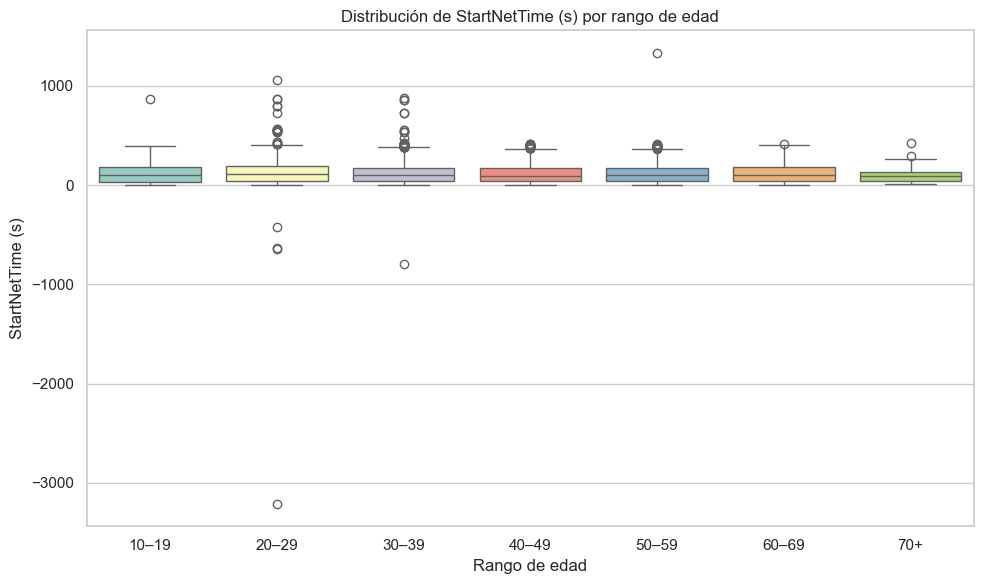

C:\Users\mario\AppData\Local\Temp\ipykernel_17936\4056310400.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


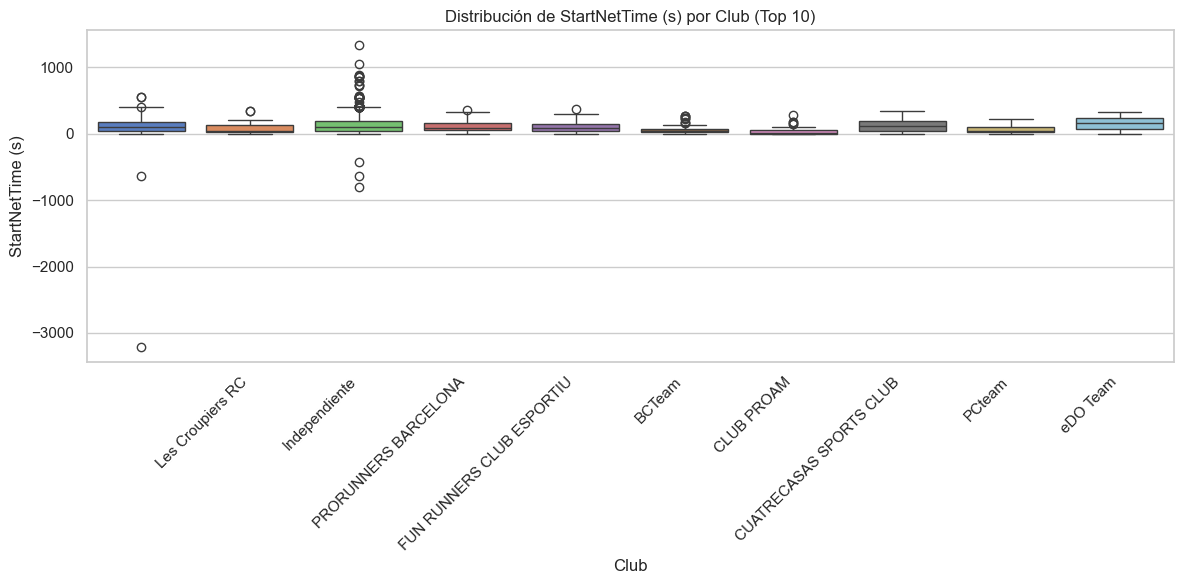

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calcular edad (en años)
fecha_carrera = pd.to_datetime("2025-02-16")
athletes_df['edad'] = (fecha_carrera - athletes_df['birthdate']).dt.days / 365.25
athletes_df['edad'] = athletes_df['edad'].where(athletes_df['edad'].between(10, 100)).round(0)

# Crear startNetTime_td_sec si no existe
if 'startNetTime_td_sec' not in athletes_events_df.columns:
    if 'startNetTime_td' in athletes_events_df.columns:
        athletes_events_df['startNetTime_td_sec'] = athletes_events_df['startNetTime_td'].dt.total_seconds()
    elif 'startNetTime' in athletes_events_df.columns:
        athletes_events_df['startNetTime_td_sec'] = athletes_events_df['startNetTime'] / 1000
    else:
        raise KeyError("No se encontró ninguna columna de tiempo neto para generar 'startNetTime_td_sec'.")

merge_analisis = athletes_events_df.merge(
    athletes_df[['athlete_id', 'edad', 'club']],
    on='athlete_id',
    how='left'
)

merge_analisis = merge_analisis.dropna(subset=['startNetTime_td_sec', 'edad', 'club'])
print(f"Total atletas con datos completos: {len(merge_analisis):,}")

merge_analisis['rango_edad'] = pd.cut(
    merge_analisis['edad'],
    bins=[10, 20, 30, 40, 50, 60, 70, 100],
    labels=['10–19', '20–29', '30–39', '40–49', '50–59', '60–69', '70+']
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merge_analisis,
    x='rango_edad',
    y='startNetTime_td_sec',
    palette='Set3'
)
plt.title("Distribución de StartNetTime (s) por rango de edad")
plt.xlabel("Rango de edad")
plt.ylabel("StartNetTime (s)")
plt.tight_layout()
plt.show()

top_clubs = merge_analisis['club'].value_counts().head(10).index

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merge_analisis[merge_analisis['club'].isin(top_clubs)],
    x='club',
    y='startNetTime_td_sec',
    palette='muted'
)
plt.title("Distribución de StartNetTime (s) por Club (Top 10)")
plt.xlabel("Club")
plt.ylabel("StartNetTime (s)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En este gráfico podemos observar como si hay valores de algunos atletas con valores negativos en salida, lo cuál podría indicar problemas en la misma y una posible intervención del cronometrador. 

En el siguiente código veremos el conteo de missings

📊 Resumen descriptivo de missing splits:
       splitsMissing  maxConsecutiveSplitsMissing
count   31683.000000                 31683.000000
mean        0.046776                     0.044977
std         0.320416                     0.308892
min         0.000000                     0.000000
25%         0.000000                     0.000000
50%         0.000000                     0.000000
75%         0.000000                     0.000000
max         5.000000                     5.000000

📈 Conteo exacto de atletas por número de 'splitsMissing':
splitsMissing
0    30723
1      700
2      107
3       71
4       55
5       27
Name: count, dtype: int64

📈 Conteo exacto de atletas por número de 'maxConsecutiveSplitsMissing':
maxConsecutiveSplitsMissing
0    30723
1      730
2       99
3       54
4       50
5       27
Name: count, dtype: int64

📉 Porcentaje de atletas por número de 'splitsMissing':
splitsMissing
0    96.97
1     2.21
2     0.34
3     0.22
4     0.17
5     0.09
Name: count, dt

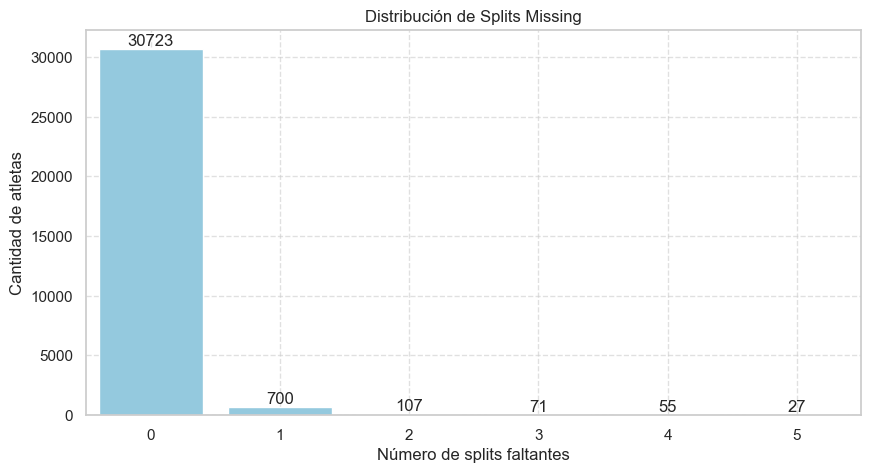

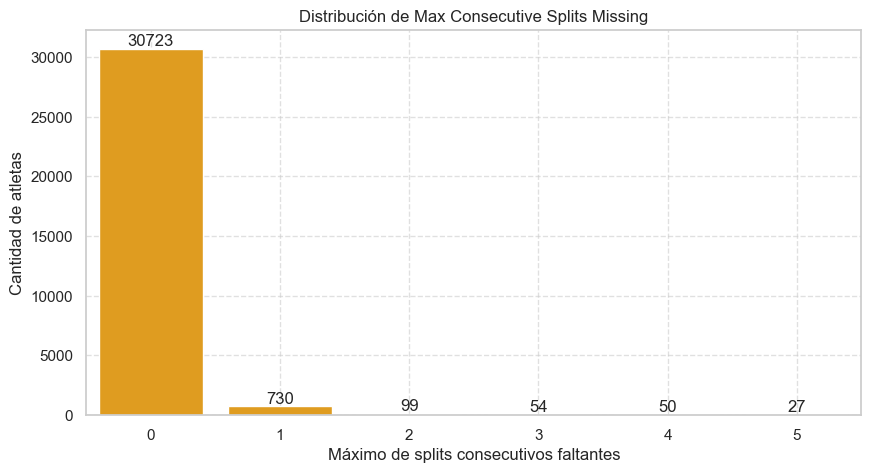


🚨 Número de atletas con seguimiento irregular (>3 splits faltantes): 82
      athlete_id  splitsMissing  maxConsecutiveSplitsMissing
46      Z4B97754              5                            5
154     31Y2Z122              4                            3
187     Y986915C              5                            5
295     C5Z32552              4                            2
729     Y54ZC86F              5                            5
...          ...            ...                          ...
29185   4B4B97D2              5                            5
29896   CD395954              4                            4
30479   8C6Y8873              5                            5
30768   229389C2              4                            4
31413   6CZAB45C              4                            4

[82 rows x 3 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = athletes_events_df.copy()

summary = df[['splitsMissing', 'maxConsecutiveSplitsMissing']].describe()
print("Resumen descriptivo de missing splits:")
print(summary)

count_splits = df['splitsMissing'].value_counts().sort_index()
count_consecutive = df['maxConsecutiveSplitsMissing'].value_counts().sort_index()

print("\nConteo exacto de atletas por número de 'splitsMissing':")
print(count_splits)

print("\nConteo exacto de atletas por número de 'maxConsecutiveSplitsMissing':")
print(count_consecutive)

# También en porcentaje (%)
total = len(df)
count_splits_pct = (count_splits / total * 100).round(2)
count_consecutive_pct = (count_consecutive / total * 100).round(2)

print("\nPorcentaje de atletas por número de 'splitsMissing':")
print(count_splits_pct)

print("\nPorcentaje de atletas por número de 'maxConsecutiveSplitsMissing':")
print(count_consecutive_pct)

plt.figure(figsize=(10,5))
sns.barplot(x=count_splits.index, y=count_splits.values, color='skyblue')
plt.title('Distribución de Splits Missing')
plt.xlabel('Número de splits faltantes')
plt.ylabel('Cantidad de atletas')
plt.grid(True, linestyle='--', alpha=0.6)
for i, v in enumerate(count_splits.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=count_consecutive.index, y=count_consecutive.values, color='orange')
plt.title('Distribución de Max Consecutive Splits Missing')
plt.xlabel('Máximo de splits consecutivos faltantes')
plt.ylabel('Cantidad de atletas')
plt.grid(True, linestyle='--', alpha=0.6)
for i, v in enumerate(count_consecutive.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()

irregular = df[df['splitsMissing'] > 3]

print(f"\nNúmero de atletas con seguimiento irregular (>3 splits faltantes): {len(irregular)}")
print(irregular[['athlete_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']])

Vemos como la mayoria de atletas no tienen muchos splits faltantes, de hecho más un 96% no tiene ninguno, esto es bastante bueno ya que vamos a poder tener datos completos de muchos atletas en todas las etapas de la carrera y nos van a servir para entender como se desarrollan los tiempos a muchos niveles. Por otro lado vemos como hay agunas personas con mas de 3 splits faltates que no han sido consecutivos, por lo que podriamos tener un precedente para analizar anomalias de falta de registros en carreras e identificar corredores a pone en cuarentena

### Nivel Atleta (Tiempos)

- Anomalías por reglas para las variables temporales más importantes. 
- Boxplots e histogramas de tiempos netos por split y velocidades medias por split
- Análisis de backups y datos válidos

Ejemplos de anomalías detectadas

Outlier de tiempo:
     athlete_id event_id                               race_id split  \
905    12ZDA656    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   10K   
906    12ZDA656    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   15K   
1230   6FY3ZCBZ    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   15K   
1231   6FY3ZCBZ    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   20K   
1232   6FY3ZCBZ    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f  Meta   

      netTime_sec  speed_m_per_s   z_score  
905      4934.146       1.985427  3.315786  
906      7741.939       1.912156  3.599548  
1230     7635.707       1.913326  3.469795  
1231    10986.240       1.787278  3.921158  
1232    11619.342       1.784344  4.013213  

Resumen general de anomalías
anomaly_type
Outlier de tiempo    623
Name: count, dtype: int64

📊 Porcentaje de anomalías por split:
anomaly_type  Normal  Outlier de tiempo
split                                  
10K             99.6            

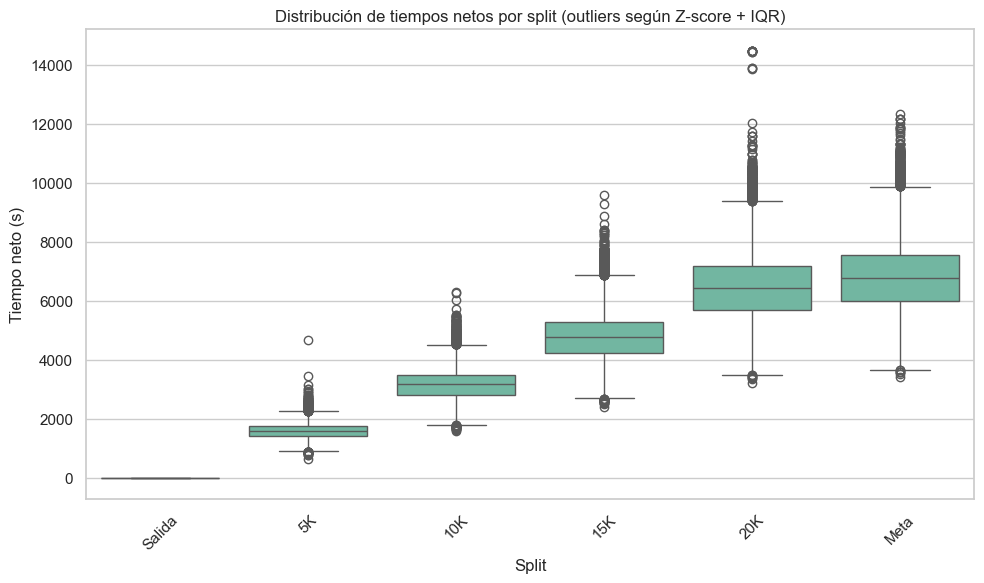

In [58]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# --- Copia de datos ---
df_times = athletes_time_df.copy()

# --- Conversión de tiempos a segundos ---
df_times['netTime_sec'] = df_times['netTime_td'].dt.total_seconds()
df_times['time_sec'] = df_times['time_td'].dt.total_seconds()

# --- Cálculo de velocidad media ---
df_times['speed_m_per_s'] = np.where(df_times['average'] > 0, 1 / df_times['average'], np.nan)
df_times['speed_flag'] = df_times['speed_m_per_s'] > 7  # ~2:23 min/km

# --- Método 1: Z-score por split ---
df_times['z_score'] = df_times.groupby('split')['netTime_sec'].transform(lambda x: zscore(x, nan_policy='omit'))
df_times['outlier_z'] = df_times['z_score'].abs() > 3

# --- Método 2: IQR por split ---
def outlier_iqr(x):
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (x < lower) | (x > upper)

df_times['outlier_iqr'] = df_times.groupby('split')['netTime_sec'].transform(outlier_iqr)

# --- OUTLIER REAL: Cumple ambos criterios ---
df_times['outlier_flag'] = df_times['outlier_z'] & df_times['outlier_iqr']

# --- Clasificación de anomalías ---
df_times['anomaly_type'] = np.select(
    [
        df_times['speed_flag'] & df_times['outlier_flag'],
        df_times['speed_flag'],
        df_times['outlier_flag']
    ],
    [
        'Ambas (velocidad y tiempo)',
        'Velocidad imposible',
        'Outlier de tiempo'
    ],
    default='Normal'
)

# --- Subconjunto de anomalías ---
df_anomalies = df_times[df_times['anomaly_type'] != 'Normal']

# --- Ejemplos de anomalías detectadas ---
print("Ejemplos de anomalías detectadas")
for tipo in df_anomalies['anomaly_type'].unique():
    print(f"\n{tipo}:")
    print(df_anomalies.loc[df_anomalies['anomaly_type'] == tipo,
        ['athlete_id', 'event_id', 'race_id', 'split',
         'netTime_sec', 'speed_m_per_s', 'z_score']
    ].head(5))

# --- Resumen general ---
print("\nResumen general de anomalías")
print(df_anomalies['anomaly_type'].value_counts())

# --- Porcentaje de anomalías por split ---
print("\n📊 Porcentaje de anomalías por split:")
summary = (
    df_times.groupby('split')['anomaly_type']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .round(3) * 100
)
print(summary)

# --- Visualización boxplot ---
plt.figure(figsize=(10,6))
sns.boxplot(data=df_times, x='split', y='netTime_sec')
plt.title("Distribución de tiempos netos por split (outliers según Z-score + IQR)")
plt.xlabel("Split")
plt.ylabel("Tiempo neto (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos ver como el tiempo se ve incrementado con respecto van pasando las etapas del evento, como es normal por otro lado. 

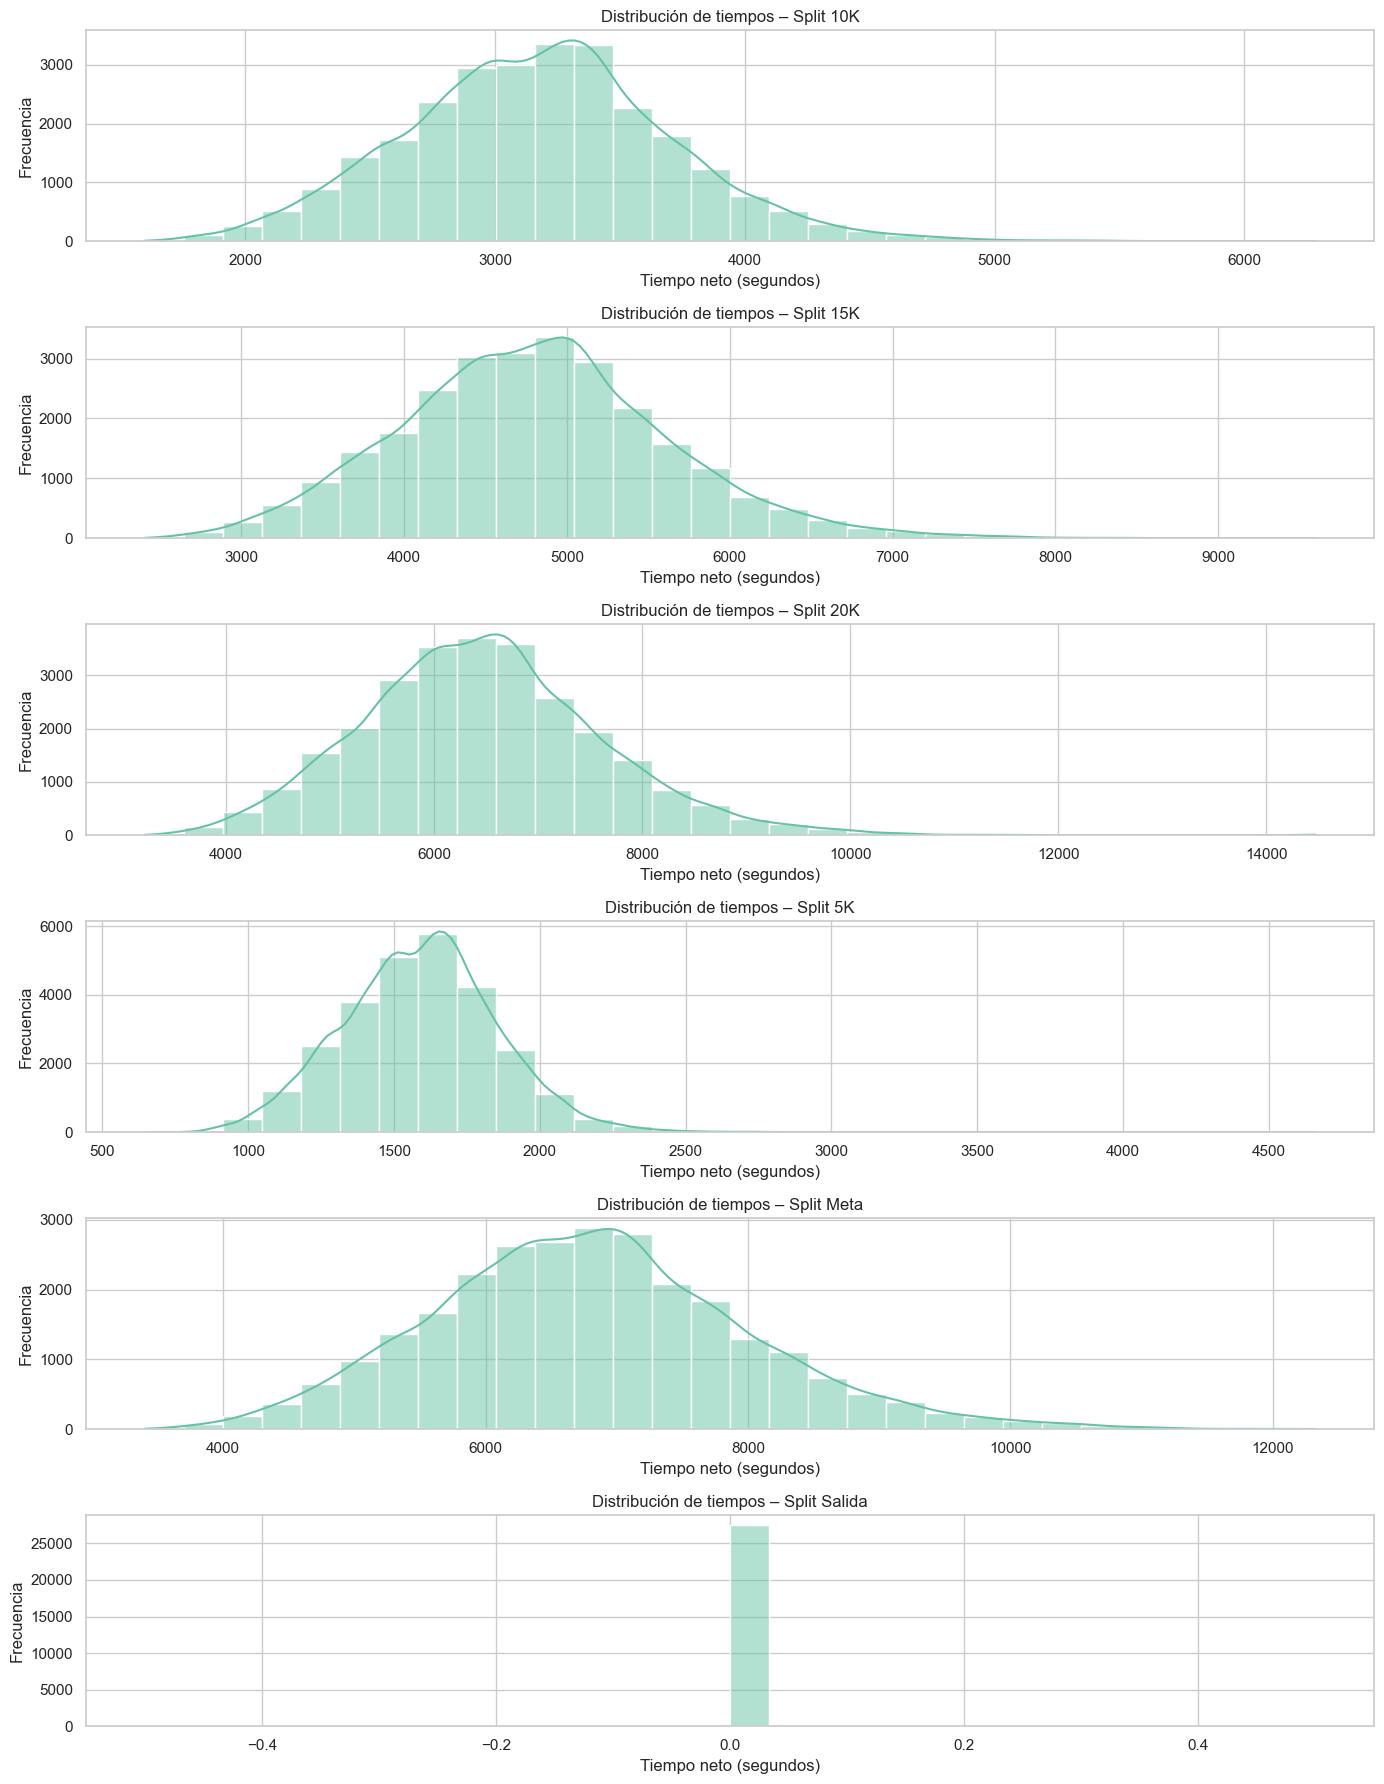

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_times = athletes_time_df.copy()
df_times['netTime_sec'] = df_times['netTime_td'].dt.total_seconds()

splits = df_times['split'].unique()
n_splits = len(splits)

plt.figure(figsize=(14, 3 * n_splits))

for i, sp in enumerate(sorted(splits)):
    plt.subplot(n_splits, 1, i + 1)
    sns.histplot(df_times[df_times['split'] == sp]['netTime_sec'], bins=30, kde=True)
    plt.title(f'Distribución de tiempos – Split {sp}')
    plt.xlabel('Tiempo neto (segundos)')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

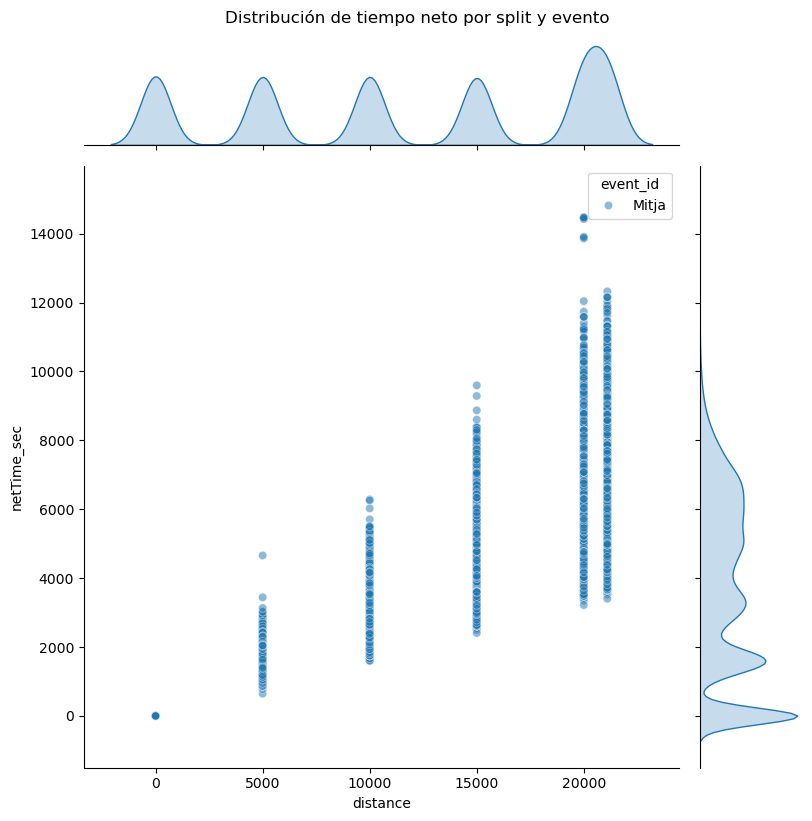

Total filas: 162743
Filas anómalas: 639

=== Resumen de atletas anómalos por tiempo neto ===
                             athlete_id split event_id  \
0  0125248f-fead-4695-ba34-d835ce861328   20K    Mitja   
1  0e069610-fb61-4088-a570-78b8444be44e   20K    Mitja   
2                              1228964D   10K    Mitja   
3                              1228964D    5K    Mitja   
4                              12ZDA656   10K    Mitja   
5                              12ZDA656   15K    Mitja   
6                              1343Z94B    5K    Mitja   
7                              13C1CY24   20K    Mitja   
8                              13C1CY24  Meta    Mitja   
9                              1441981A   10K    Mitja   

                                race_id   avg_time  mediana_split     z_max  \
0  1a83229e-2547-42a3-b5b4-36c7425c4d8f  14470.973      6425.4700  6.980272   
1  1a83229e-2547-42a3-b5b4-36c7425c4d8f  14471.049      6425.4700  6.980338   
2  1a83229e-2547-42a3-b5b4-36c7

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Copiar dataframe
df = athletes_time_df.copy()
df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

# Visualización de tiempo neto por split y evento
sns.jointplot(
    data=df,
    x='distance', 
    y='netTime_sec', 
    kind='scatter', 
    hue='event_id',
    alpha=0.5,
    height=8
)
plt.suptitle('Distribución de tiempo neto por split y evento', y=1.02)
plt.show()

# --- Mediana y desviación estándar por split (todos los atletas) ---
split_stats = df.groupby('split')['netTime_sec'].agg(['median', 'std']).rename(
    columns={'median': 'mediana_split', 'std': 'std_split'}
)

df = df.merge(split_stats, on='split', how='left')

# Calcular z-score respecto a todos los atletas en el split
df['z_time'] = (df['netTime_sec'] - df['mediana_split']) / df['std_split']

# Detectar anomalías
anomalos = df[df['z_time'].abs() > 3]

# Resumen de anomalías
resumen_anomalos = (
    anomalos.groupby(['athlete_id', 'split', 'event_id', 'race_id'])
    .agg(
        avg_time=('netTime_sec', 'mean'),
        mediana_split=('mediana_split', 'mean'),
        z_max=('z_time', 'max'),
        z_min=('z_time', 'min'),
        count=('netTime_sec', 'count')
    )
    .reset_index()
)

print(f"Total filas: {len(df)}")
print(f"Filas anómalas: {len(anomalos)}")
print("\n=== Resumen de atletas anómalos por tiempo neto ===")
print(resumen_anomalos.head(10))

### Velocidad


--- Detección de anomalías en 1/average (m/s) ---


c:\Users\mario\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(



Ejemplos de anomalías de velocidad detectadas (1/average):
   athlete_id split  speed_from_average  z_score_speed
1          31    5K            5.594093       4.356981
9         160    5K            4.860976       3.113950
10        160   10K            4.883766       3.028314
15        191    5K            5.618925       4.399085
16        191   10K            5.634438       4.326115
17        191   15K            5.532810       4.129108
18        191   20K            5.463585       3.980422
19        191  Meta            5.474652       3.977901
21        192    5K            5.476451       4.157515
22        192   10K            5.444251       3.997310

Resumen general de anomalías en velocidad (1/average):
split
5K      357
10K     336
15K     301
20K     282
Meta    271
Name: count, dtype: int64

📊 Porcentaje de anomalías de velocidad (1/average) por split:
split
10K       1.2
15K       1.1
20K       1.1
5K        1.3
Meta      1.0
Salida    0.0
Name: outlier_speed_flag, dtype: f

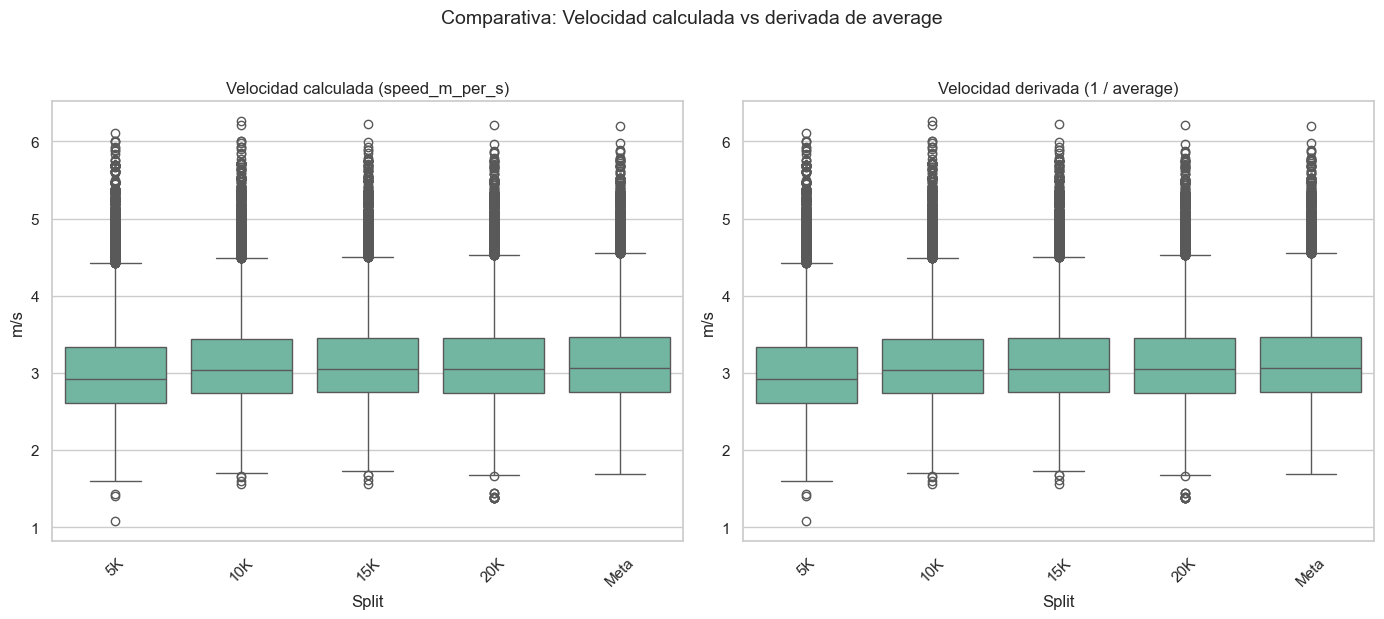

📈 Correlación entre speed_m_per_s y 1/average: 1.000000
🔍 Diferencia media absoluta entre ambas velocidades: 0.000000 m/s


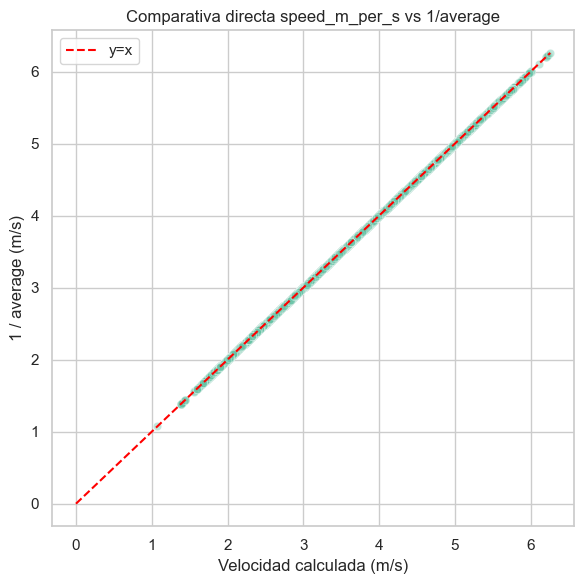

In [ ]:
print("\n--- Detección de anomalías en 1/average (m/s) ---")

df_times = df_times.copy()
df_times['speed_from_average'] = np.where(df_times['average'] > 0, 1 / df_times['average'], np.nan)

df_times['z_score_speed'] = df_times.groupby('split')['speed_from_average'].transform(
    lambda x: zscore(x, nan_policy='omit')
)
df_times['outlier_z_speed'] = df_times['z_score_speed'].abs() > 3

def outlier_iqr_speed(x):
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (x < lower) | (x > upper)

df_times['outlier_iqr_speed'] = df_times.groupby('split')['speed_from_average'].transform(outlier_iqr_speed)
df_times['outlier_speed_flag'] = df_times['outlier_z_speed'] & df_times['outlier_iqr_speed']

df_speed_anomalies = df_times[df_times['outlier_speed_flag']].copy()

print("\nEjemplos de anomalías de velocidad detectadas (1/average):")
print(df_speed_anomalies[['athlete_id', 'split', 'speed_from_average', 'z_score_speed']].head(10))

print("\nResumen general de anomalías en velocidad (1/average):")
print(df_speed_anomalies['split'].value_counts())

summary_speed = (
    df_times.groupby('split')['outlier_speed_flag']
    .mean()
    .round(3) * 100
)
print("\nPorcentaje de anomalías de velocidad (1/average) por split:")
print(summary_speed)

print("\n--- Comparativa gráfica: speed_m_per_s vs 1/average ---")

df_comp = df_times.dropna(subset=['average', 'speed_m_per_s', 'speed_from_average']).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

sns.boxplot(data=df_comp, x='split', y='speed_m_per_s', ax=axes[0])
axes[0].set_title("Velocidad calculada (speed_m_per_s)")
axes[0].set_xlabel("Split")
axes[0].set_ylabel("m/s")
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_comp, x='split', y='speed_from_average', ax=axes[1])
axes[1].set_title("Velocidad derivada (1 / average)")
axes[1].set_xlabel("Split")
axes[1].set_ylabel("m/s")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Comparativa: Velocidad calculada vs derivada de average", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

corr = df_comp[['speed_m_per_s', 'speed_from_average']].corr().iloc[0, 1]
diff = (df_comp['speed_m_per_s'] - df_comp['speed_from_average']).abs().mean()

print(f"Correlación entre speed_m_per_s y 1/average: {corr:.6f}")
print(f"Diferencia media absoluta entre ambas velocidades: {diff:.6f} m/s")

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_comp, 
    x='speed_m_per_s', 
    y='speed_from_average', 
    alpha=0.4
)
plt.plot([0, df_comp[['speed_m_per_s','speed_from_average']].max().max()],
         [0, df_comp[['speed_m_per_s','speed_from_average']].max().max()],
         color='red', linestyle='--', label='y=x')
plt.title("Comparativa directa speed_m_per_s vs 1/average")
plt.xlabel("Velocidad calculada (m/s)")
plt.ylabel("1 / average (m/s)")
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
import pandas as pd

df = athletes_time_df.copy()

desc_stats = df.groupby('split')['average'].describe()

percentiles = df.groupby('split')['average'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack(level=1)
percentiles.columns = ['5%', '25%', '50%', '75%', '95%']

desc_stats_full = pd.concat([desc_stats, percentiles], axis=1)

print(desc_stats_full)

          count      mean       std      min       25%       50%       75%  \
split                                                                        
10K     27225.0  0.329380  0.056598  0.15975  0.291180  0.329920  0.366120   
15K     26822.0  0.327670  0.056661  0.16047  0.289623  0.327370  0.363117   
20K     26850.0  0.329339  0.059021  0.16095  0.289652  0.327480  0.365440   
5K      27224.0  0.342159  0.061248  0.16374  0.299935  0.342055  0.383650   
Meta    27160.0  0.327950  0.058276  0.16129  0.288390  0.326150  0.364090   
Salida  27462.0  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   

            max        5%       25%       50%       75%       95%  
split                                                              
10K     0.64391  0.235172  0.291180  0.329920  0.366120  0.422860  
15K     0.63981  0.235211  0.289623  0.327370  0.363117  0.422770  
20K     0.72369  0.235895  0.289652  0.327480  0.365440  0.430380  
5K      0.93195  0.238806  0.299935

Podemos ver que la velocidad se mantiene algo constante, no baja tanto como subia el tiempo, y suele estar sobre los 3 o 4 metros por segundo. Tambien vemos atletas con un tiempo alto desporporcionado que podrian estar ligados a errores de cálculo o de obtencion. 

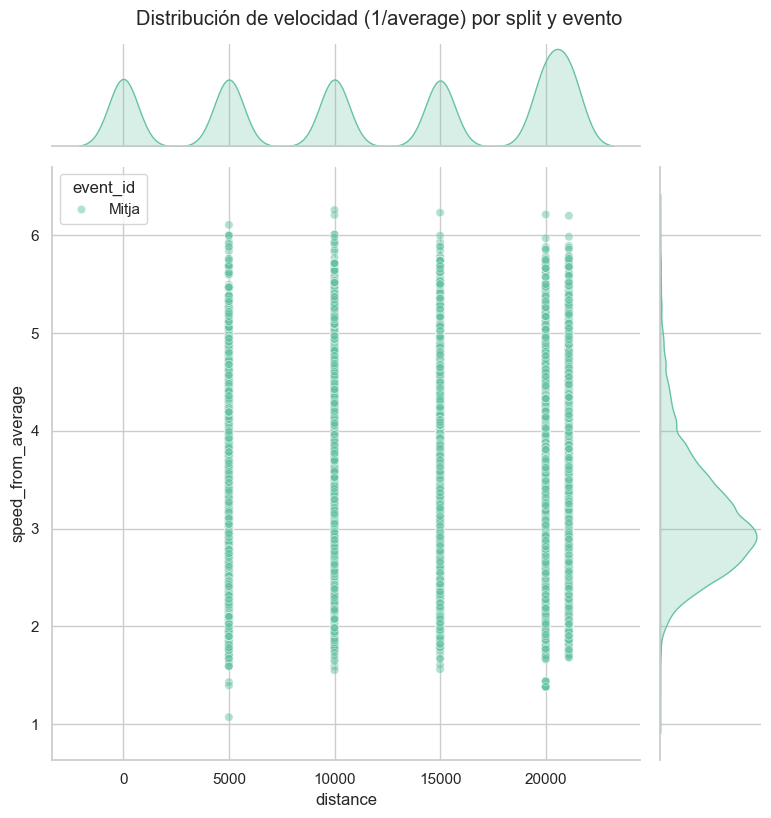

c:\Users\mario\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Total filas en dataset: 162743
Filas consideradas anómalas (Z-score + IQR): 1915

=== Resumen de atletas anómalos ===
  athlete_id split event_id                               race_id  avg_speed  \
0   1259A8AZ   10K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.938272   
1   1259A8AZ   15K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.929265   
2   1259A8AZ   20K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.920533   
3   1259A8AZ    5K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.906049   
4   1259A8AZ  Meta    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.929751   
5   13DA3C1A   10K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.915937   
6   13DA3C1A   15K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.880191   
7   13DA3C1A   20K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.840271   
8   13DA3C1A    5K    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.897879   
9   13DA3C1A  Meta    Mitja  1a83229e-2547-42a3-b5b4-36c7425c4d8f   4.840505   

 

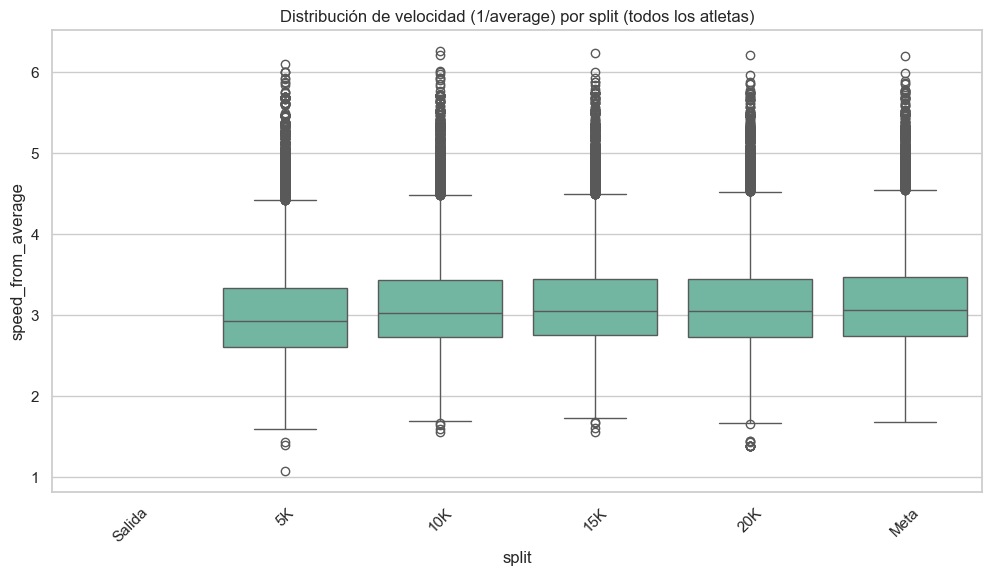

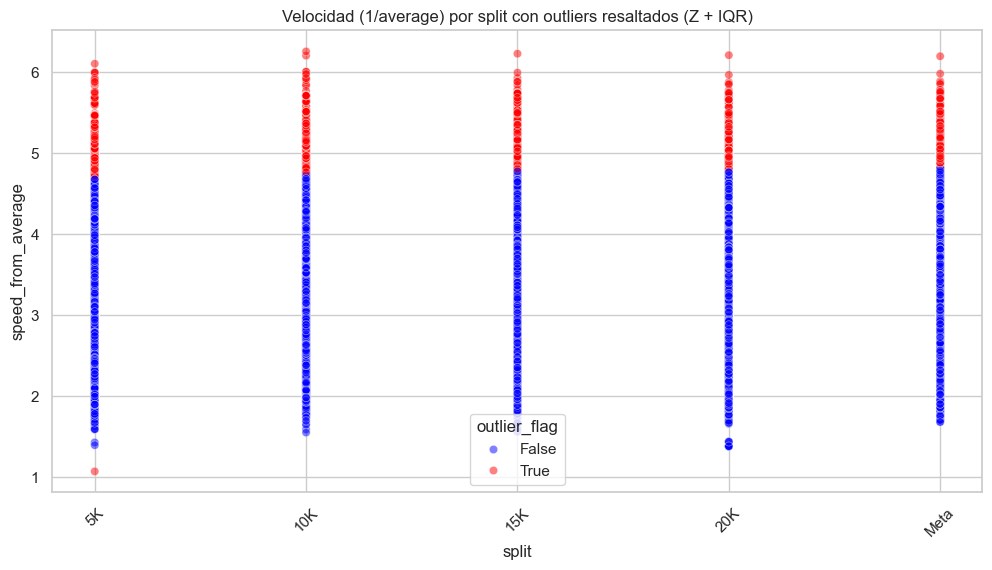

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# --- Copiamos el dataframe original ---
df = athletes_time_df.copy()

# --- Calcular velocidad como 1 / average ---
df['speed_from_average'] = np.where(df['average'] > 0, 1 / df['average'], np.nan)

# --- Visualización general (NO se cambia tu gráfico) ---
sns.jointplot(
    data=df,
    x='distance',
    y='speed_from_average',
    kind='scatter',
    hue='event_id',
    alpha=0.5,
    height=8
)
plt.suptitle('Distribución de velocidad (1/average) por split y evento', y=1.02)
plt.show()

# --- Mediana y desviación por split (todos los atletas) ---
median_split = df.groupby('split')['speed_from_average'].median().rename('mediana_split')
df = df.merge(median_split, on='split', how='left')

# Desviación estándar por split
std_split = df.groupby('split')['speed_from_average'].transform('std')

# Z-score relativo a la mediana global de cada split
df['z_speed'] = (df['speed_from_average'] - df['mediana_split']) / std_split
df['outlier_z'] = df['z_speed'].abs() > 3

# --- Método IQR ---
def outlier_iqr_speed(x):
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (x < lower) | (x > upper)

df['outlier_iqr'] = df.groupby('split')['speed_from_average'].transform(outlier_iqr_speed)

# --- OUTLIER REAL: Cumple ambos métodos ---
df['outlier_flag'] = df['outlier_z'] & df['outlier_iqr']

# --- Subconjunto de anomalías ---
anomalos = df[df['outlier_flag']].copy()

# --- Resumen por atleta, split, evento y carrera ---
resumen_anomalos = (
    anomalos.groupby(['athlete_id', 'split', 'event_id', 'race_id'])
    .agg(
        avg_speed=('speed_from_average', 'mean'),
        mediana_split=('mediana_split', 'mean'),
        z_max=('z_speed', 'max'),
        z_min=('z_speed', 'min'),
        count=('speed_from_average', 'count')
    )
    .reset_index()
)

# --- Resultados ---
print(f"Total filas en dataset: {len(df)}")
print(f"Filas consideradas anómalas (Z-score + IQR): {len(anomalos)}")
print("\n=== Resumen de atletas anómalos ===")
print(resumen_anomalos.head(10))

# --- Visualización de outliers (idéntica a la tuya) ---
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='split', y='speed_from_average')
plt.title("Distribución de velocidad (1/average) por split (todos los atletas)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df, x='split', y='speed_from_average',
    hue=df['outlier_flag'], palette={True:'red', False:'blue'}, alpha=0.5
)
plt.title("Velocidad (1/average) por split con outliers resaltados (Z + IQR)")
plt.xticks(rotation=45)
plt.show()

In [67]:
import pandas as pd

def analyze_raw_quality(df: pd.DataFrame):
    """
    Analiza la calidad de los datos en función de los flags:
    - raw_manual
    - raw_valid
    - incidence
    Muestra conteos y porcentajes de True por split/event/race.
    """

    # Verificamos las columnas relevantes
    quality_cols = [col for col in ['raw_manual', 'raw_valid', 'incidence'] if col in df.columns]
    if not quality_cols:
        print("No se encontraron columnas de calidad ('raw_manual', 'raw_valid', 'incidence').")
        return

    # Convertir a booleanas si no lo son
    for col in quality_cols:
        df[col] = df[col].astype('bool', errors='ignore')

    # Agrupamos por carrera, evento y split
    summary = (
        df.groupby(['race_id', 'event_id', 'split'])
        .agg(
            total_registros=('athlete_id', 'count'),
            **{f"{col}_true": (col, lambda x: x.fillna(False).sum()) for col in quality_cols}
        )
        .reset_index()
    )

    # Porcentajes
    for col in quality_cols:
        summary[f"pct_{col}_true"] = summary[f"{col}_true"] / summary['total_registros'] * 100

    # Totales generales
    total_registros = len(df)
    print(f"=== Total registros analizados: {total_registros} ===")
    for col in quality_cols:
        total_true = df[col].fillna(False).sum()
        pct = total_true / total_registros * 100
        print(f"{col}: {total_true} ({pct:.2f}%) filas con True")

    # Mostrar las primeras filas del resumen
    print("\n=== Resumen por race/event/split ===")
    cols_to_show = ['race_id', 'event_id', 'split'] + [f"pct_{col}_true" for col in quality_cols]
    print(summary[cols_to_show].head(10))

    return summary

# Ejecutar análisis
analyze_raw_quality(athletes_time_df)

=== Total registros analizados: 162743 ===
raw_manual: 162638 (99.94%) filas con True
raw_valid: 162743 (100.00%) filas con True
incidence: 162743 (100.00%) filas con True

=== Resumen por race/event/split ===
                                race_id event_id   split  pct_raw_manual_true  \
0  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     10K            99.974288   
1  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     15K            99.966445   
2  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     20K            99.966480   
3  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja      5K            99.985307   
4  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja    Meta            99.878498   
5  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja  Salida            99.843420   

   pct_raw_valid_true  pct_incidence_true  
0               100.0               100.0  
1               100.0               100.0  
2               100.0               100.0  
3               100.0               100.0  
4 

race_id event_id   split  total_registros  \
0  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     10K            27225   
1  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     15K            26822   
2  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     20K            26850   
3  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja      5K            27224   
4  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja    Meta            27160   
5  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja  Salida            27462   

   raw_manual_true  raw_valid_true  incidence_true  pct_raw_manual_true  \
0            27218           27225           27225            99.974288   
1            26813           26822           26822            99.966445   
2            26841           26850           26850            99.966480   
3            27220           27224           27224            99.985307   
4            27127           27160           27160            99.878498   
5            27419           27462           27462            99.843420   

   pct_raw_valid_true  pct_incidence_true  
0               100.0               100.0  
1               100.0               100.0  
2               100.0               100.0  
3               100.0               100.0  
4               100.0               100.0  
5               100.0               100.0

El análisis de calidad de los registros muestra que prácticamente todos los registros cuentan con un backup presente (100%), lo que indica que el sistema genera copias de seguridad de manera consistente para cada punto de control. Sin embargo, solo un número muy reducido de estos backups ha sido realmente utilizado para reemplazar tiempos faltantes o corregidos (92 de 162743), lo que evidencia que la mayoría de los registros originales fueron válidos y no requirieron intervención. Por otro lado, casi todos los registros se marcaron como manuales (≈99,8%), mientras que no se detectaron registros inválidos (CONSULTAR). En resumen, el sistema dispone de abundantes recursos de respaldo, aunque su uso real es mínimo, y los datos originales presentan una calidad elevada, con muy pocas correcciones necesarias.

In [74]:
def summarize_incidence(df: pd.DataFrame):

    # Si hay incidencia en la fila
    df['incidencia_fila'] = df['incidence'].notna().astype(int)  

    # Si se usó backup en la fila
    df['backup_usado_fila'] = (df['isBackup'] == True).astype(int)

    # Si la fila fue manual
    df['manual_fila'] = (df['raw_manual'] == True).astype(int)

    # Si el backup resolvió la incidencia
    df['backup_resuelve_incidencia'] = ((df['isBackup'] == True) & df['incidence'].notna()).astype(int)
    
    summary = (
        df.groupby(['race_id', 'event_id', 'split'])
        .agg(
            total_filas=('athlete_id', 'count'),  
            filas_con_incidencia=('incidencia_fila', 'sum'),
            total_backups_usados=('backup_usado_fila', 'sum'),
            total_manuales=('manual_fila', 'sum'),
            total_backups_resuelven=('backup_resuelve_incidencia', 'sum')
        )
        .reset_index()
    )

    summary['pct_incidencias'] = summary['filas_con_incidencia'] / summary['total_filas']
    summary['pct_backups_usados'] = summary['total_backups_usados'] / summary['total_filas']
    summary['pct_manuales'] = summary['total_manuales'] / summary['total_filas']
    summary['pct_backups_resuelven'] = summary['total_backups_resuelven'] / summary['total_filas']

    print("Resumen de incidencias por split/event/race")
    print(summary.head(10))

    return summary

incidence_summary = summarize_incidence(athletes_time_df)


Resumen de incidencias por split/event/race
                                race_id event_id   split  total_filas  \
0  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     10K        27225   
1  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     15K        26822   
2  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja     20K        26850   
3  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja      5K        27224   
4  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja    Meta        27160   
5  1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja  Salida        27462   

   filas_con_incidencia  total_backups_usados  total_manuales  \
0                 27225                     0           27218   
1                 26822                     0           26813   
2                 26850                     0           26841   
3                 27224                     0           27220   
4                 27160                     0           27127   
5                 27462                    92         

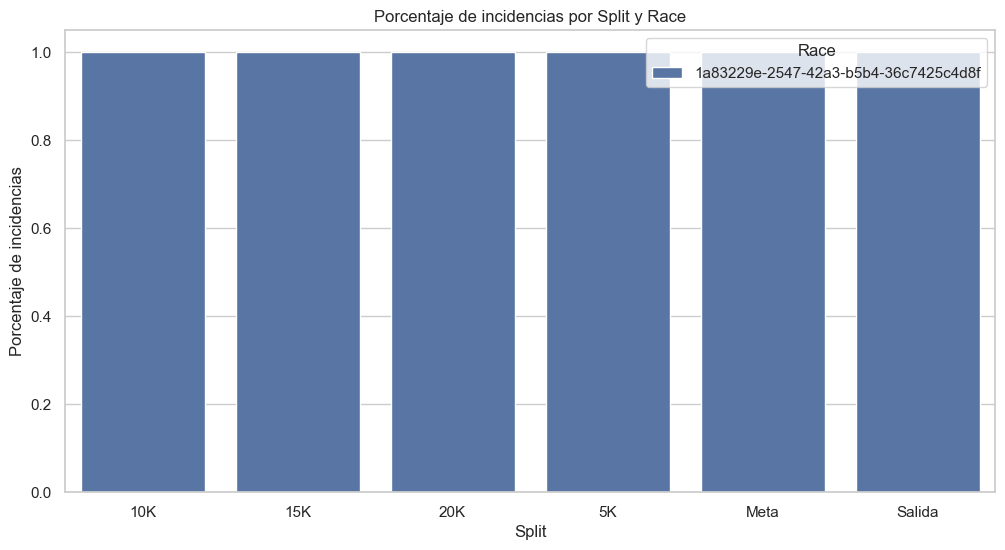

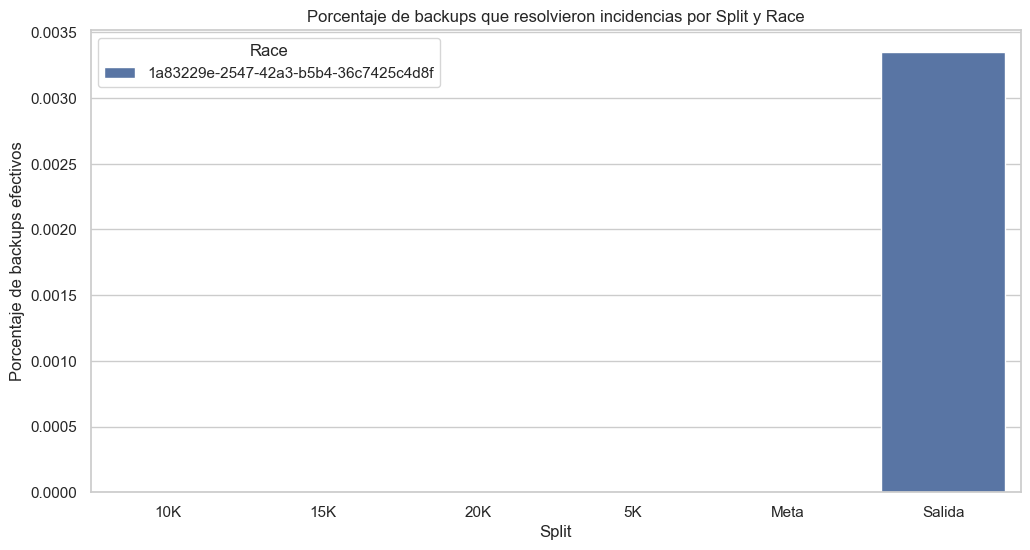

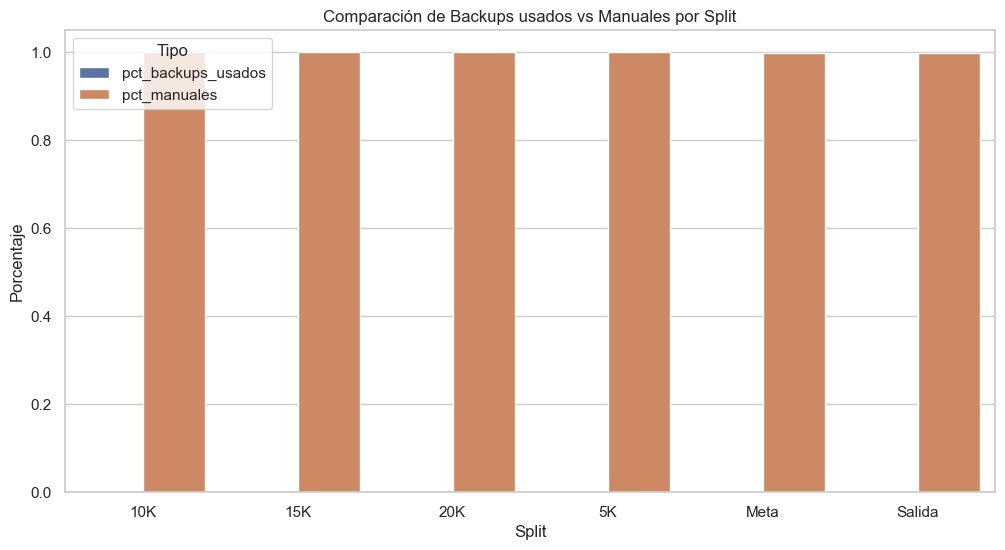

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_incidence_summary(summary_df):

    sns.set(style="whitegrid")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=summary_df,
        x='split',
        y='pct_incidencias',
        hue='race_id'
    )
    plt.title('Porcentaje de incidencias por Split y Race')
    plt.ylabel('Porcentaje de incidencias')
    plt.xlabel('Split')
    plt.legend(title='Race')
    plt.show()
    
    # Gráfico 2: porcentaje de backups que resolvieron incidencias
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=summary_df,
        x='split',
        y='pct_backups_resuelven',
        hue='race_id'
    )
    plt.title('Porcentaje de backups que resolvieron incidencias por Split y Race')
    plt.ylabel('Porcentaje de backups efectivos')
    plt.xlabel('Split')
    plt.legend(title='Race')
    plt.show()
    
    # Gráfico 3: comparación de manuales y backups usados
    plt.figure(figsize=(12, 6))
    summary_melted = summary_df.melt(
        id_vars=['race_id', 'split'],
        value_vars=['pct_backups_usados', 'pct_manuales'],
        var_name='tipo',
        value_name='porcentaje'
    )
    sns.barplot(
        data=summary_melted,
        x='split',
        y='porcentaje',
        hue='tipo'
    )
    plt.title('Comparación de Backups usados vs Manuales por Split')
    plt.ylabel('Porcentaje')
    plt.xlabel('Split')
    plt.legend(title='Tipo')
    plt.show()

# Ejecutar la visualización
plot_incidence_summary(incidence_summary)


## como hago para comparar la normalidad intra atleta y inter atleta

Total registros: 162743: cantidad de filas analizadas en todos los atletas y splits.

Registros anómalos detectados: 6258: tiempos que se consideran significativamente distintos de la combinación de histórico propio y distribución global.

Atletas con <3 registros totales: 473: atletas con historial muy limitado. Su detección de anomalías es menos confiable, pero se incluyen gracias a la ponderación con la distribución global.

En la tabla de anomalías se observan:

Atletas con un Z-score combinado muy alto, lo que indica un rendimiento atípico respecto a su historial y al promedio global del split.

La columna low_history permite identificar atletas con pocos registros históricos.

La columna reason explica por qué se considera el registro como anómalo (“Z-score combinado alto”).

Esta estrategia permite:

Detectar anomalías incluso en atletas con historial limitado.

Combinar información individual y colectiva para mejorar la sensibilidad de la detección.

Tener un criterio objetivo y reproducible basado en estadística, sin depender de reglas arbitrarias.

## Nivel issues 

Para los issues vamos a hacer transformaciones necesarias a los datos, pasando por crear columnas nuevas para identificar cuando ha sido el issue. Para ello pondremos el límite en 3 horas para la media maratón. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")

issues_df["datetime"] = pd.to_datetime(issues_df["time"], unit="ms", errors="coerce")

official_start = datetime(2025, 2, 16, 7, 30)

def clasificar_fase(t):
    if pd.isna(t): return "desconocido"
    delta = (t - official_start).total_seconds() / 3600
    if delta < 0:
        return "pre-carrera"
    elif 0 <= delta <= 3:
        return "en carrera"
    else:
        return "post-carrera"

issues_df["fase_temporal"] = issues_df["datetime"].apply(clasificar_fase)

📊 Distribución de tipos de incidencias:
type
changeRanking     111979
importAthletes     61931
changeStatus         645
importSwap           281
athleteTime          116
athleteSwap           59
Name: count, dtype: int64


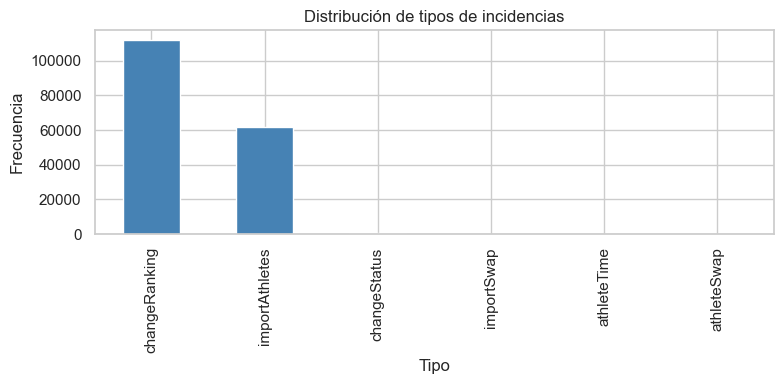

Conteo diario de incidencias:
datetime
2025-02-11    36596
2025-02-12        0
2025-02-13        4
2025-02-14       15
2025-02-15    62271
2025-02-16    75511
2025-02-17       35
2025-02-18      140
2025-02-19       43
2025-02-20        6
2025-02-21        1
2025-02-22        0
2025-02-23        0
2025-02-24        0
2025-02-25        1
2025-02-26        0
2025-02-27        0
2025-02-28      105
2025-03-01        0
2025-03-02        1
2025-03-03        0
2025-03-04      183
2025-03-05        0
2025-03-06        0
2025-03-07        0
2025-03-08        0
2025-03-09        0
2025-03-10        0
2025-03-11       81
2025-03-12        0
2025-03-13       17
2025-03-14        0
2025-03-15        0
2025-03-16        0
2025-03-17        0
2025-03-18        0
2025-03-19        0
2025-03-20        0
2025-03-21        0
2025-03-22        0
2025-03-23        0
2025-03-24        0
2025-03-25        0
2025-03-26        0
2025-03-27        0
2025-03-28        0
2025-03-29        0
2025-03-30        0
2

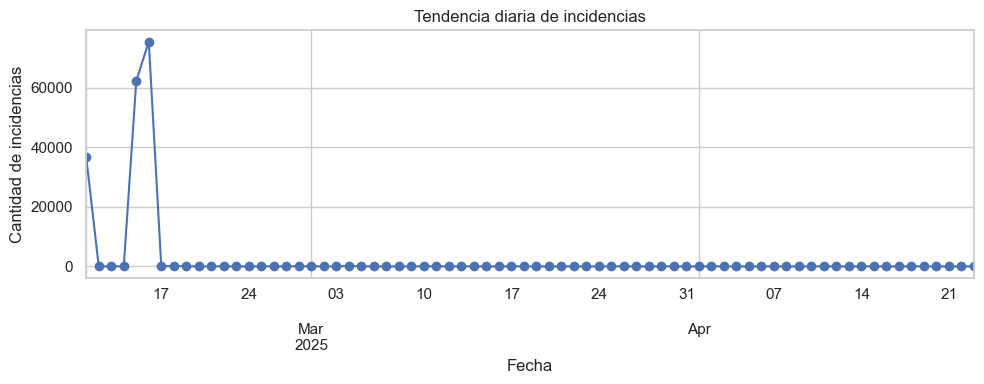

In [ ]:
type_counts = issues_df["type"].value_counts().sort_values(ascending=False)
print("📊 Distribución de tipos de incidencias:")
print(type_counts)

plt.figure(figsize=(8,4))
type_counts.plot(kind='bar', color='steelblue')
plt.title("Distribución de tipos de incidencias")
plt.xlabel("Tipo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))

incidencias_diarias = (
    issues_df
    .set_index("datetime")
    .resample("1D")["id"]
    .count()
)

print("Conteo diario de incidencias:")
print(incidencias_diarias)

incidencias_diarias.plot(marker='o')
plt.title("Tendencia diaria de incidencias")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de incidencias")
plt.tight_layout()
plt.show()

Podemos ver de forma sencilla la mayoría de incidencias se realizan los dias previos y el dia de carrera, y por otro lado los días posteriores a la misma se arreglan errores muy esporádicos pero muy extendidos en el tiempo. El último día que se arregla un error es el 23 de abril, casi 1 mes y medio después de haber terminado la carrera.

Por otro lado vemos que la mayoría de los errores que se cometen son de lña categoría changeRanking e importathletes, lógico al ser una de las categorías más generales, al igual que importathletes en al que se importan los datos de los atletas. 


Distribución por fase temporal:
fase_temporal
pre-carrera     98895
en carrera      57837
post-carrera    18279
Name: count, dtype: int64


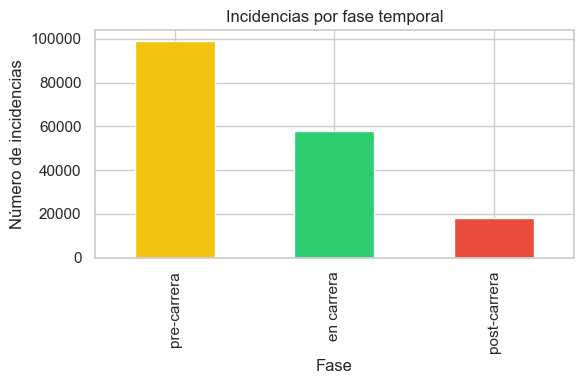

In [ ]:
fase_counts = issues_df["fase_temporal"].value_counts()
print("\nDistribución por fase temporal:")
print(fase_counts)

plt.figure(figsize=(6,4))
fase_counts.plot(kind="bar", color=["#F1C40F","#2ECC71","#E74C3C"])
plt.title("Incidencias por fase temporal")
plt.xlabel("Fase")
plt.ylabel("Número de incidencias")
plt.tight_layout()
plt.show()

La mayoría de incidencias se realizan pre-carrera, en la que el cronometrador se encarga de arreglar pequeños detalles de todos los atletas para ajustar como se va a cronometrar la carrera y la informacion y se importan los datos de los atletas. 

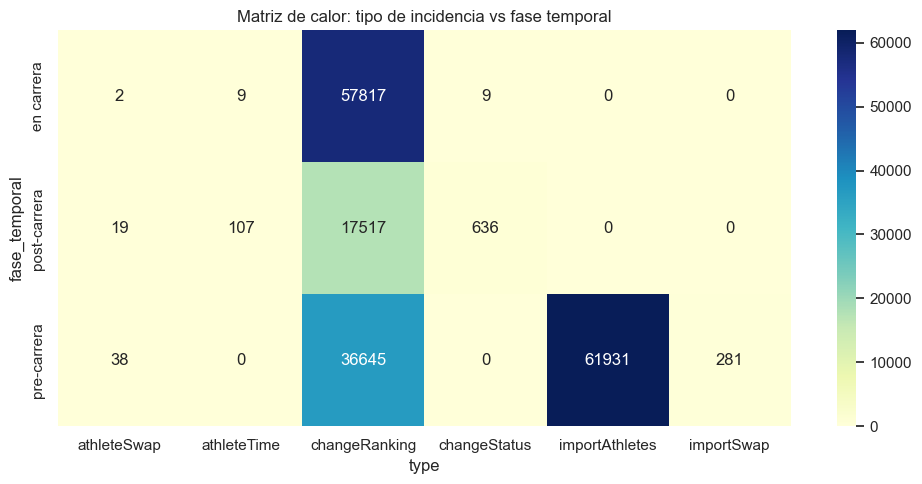

In [ ]:
pivot = pd.crosstab(issues_df["fase_temporal"], issues_df["type"])
plt.figure(figsize=(10,5))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Matriz de calor: tipo de incidencia vs fase temporal")
plt.tight_layout()
plt.show()

In [ ]:
duplicados = issues_df['id'].value_counts()
duplicados = duplicados[duplicados > 1]

print(duplicados)

id
3927efd0-ec42-11ef-a9ce-21a37501454e    7562
17922da0-ec41-11ef-a9ce-21a37501454e    5349
f27fab50-ec40-11ef-a9ce-21a37501454e    5349
137e4220-ec38-11ef-9ec6-616957f1a263    5175
c7ec4a30-ebee-11ef-94fe-1bab35233bd7    5147
                                        ... 
471e67a0-ebce-11ef-90f3-7fb351d97b78       2
acdbecb0-ebca-11ef-9447-45909889f692       2
7f598520-eb7c-11ef-84aa-b74ff1cca6c7       2
385725d0-eb93-11ef-9b57-a1ba2d2bc810       2
ca420920-ec32-11ef-a9ce-21a37501454e       2
Name: count, Length: 261, dtype: int64


Un issue se puede repetir en muchos atletas, por lo que conviene simplificar los datos. 

In [ ]:
import json
import os
import glob

def get_issues_by_id(duplicated_id, data_dir):
    
    issues_files = glob.glob(os.path.join(data_dir, "*.issues.json"))
    if not issues_files:
        raise FileNotFoundError("No se encontró ningún archivo de issues en el directorio.")

    matched_issues = []

    def issue_contains_id(issue, target_id):
        if isinstance(issue, dict):
            if issue.get("id") == target_id:
                return True
            return any(issue_contains_id(v, target_id) for v in issue.values())
        elif isinstance(issue, list):
            return any(issue_contains_id(v, target_id) for v in issue)
        return False

    for fpath in issues_files:
        with open(fpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        flat_issues = []
        for sublist in data:
            if isinstance(sublist, list):
                flat_issues.extend(sublist)
            elif isinstance(sublist, dict):
                flat_issues.append(sublist)

        for issue in flat_issues:
            if issue_contains_id(issue, duplicated_id):
                matched_issues.append(issue)

    return matched_issues

data_dir = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos"
duplicated_id = "af4215f0-e856-11ef-aee0-f3683f511a40"

issues_json = get_issues_by_id(duplicated_id, data_dir)

# Guardar resultado en JSON
output_file = os.path.join(data_dir, f"issues_{duplicated_id}.json")
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(issues_json, f, ensure_ascii=False, indent=4)

print(f"✅ Se guardaron {len(issues_json)} issues con id {duplicated_id} en {output_file}")

✅ Se guardaron 4288 issues con id af4215f0-e856-11ef-aee0-f3683f511a40 en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos\issues_af4215f0-e856-11ef-aee0-f3683f511a40.json


Vemos que todos los issues con el mismo id han sido el mismo cambio pero para distintos atletas, estos nos va a servir para saber que cantidad de probloemas reales ha habido en la carrera como tal. 

In [69]:
import pandas as pd

# Suponiendo que ya tienes issues_df cargado
num_ids_unicos = issues_df['id'].nunique()
total_ids = len(issues_df)

print(f"Total de filas en issues_df: {total_ids}")
print(f"Número de ids únicos: {num_ids_unicos}")

# Opcional: mostrar cuántos ids están duplicados
num_duplicados = total_ids - num_ids_unicos
print(f"Número de ids duplicados: {num_duplicados}")

Total de filas en issues_df: 175011
Número de ids únicos: 402
Número de ids duplicados: 174609


Vemos como la mayoría de ids son duplicados y solo hay 402 errores en total, esto nos va a servir para poder hacer un análisis mucho más limpio y definido, por lo que vamos a pasar a agrupar los datos. 

In [ ]:
import pandas as pd

def agrupar_issues_por_id_data_completo(
    issues_df, issues_data_df, issues_events_df,
    issues_times_df, issues_attributes_df, issues_chips_df,
    umbral_lista=10
):

    data_cols = [col for col in issues_data_df.columns if col.startswith("data_")]
    events_cols = [col for col in issues_events_df.columns if col.startswith("data_")]
    selected_cols = list(set(data_cols + events_cols))

    grouped = issues_df.groupby('id').agg({
        'type': 'first',
        'datetime': 'first',
        'fase_temporal': 'first',
        'priority': 'first',
        'race_id': 'first',
        'collection': 'first',
        'athlete_id': lambda x: list(x.dropna().unique()) 
    }).reset_index()

    grouped = grouped.rename(columns={'athlete_id': 'athletes_afectados'})

    total_athletes = issues_df['athlete_id'].nunique()

    def generar_afectacion(ids):
        num_afectados = len(ids)
        pct_afectados = num_afectados / total_athletes if total_athletes > 0 else 0
        return pct_afectados, num_afectados

    afectados_data = grouped['athletes_afectados'].apply(generar_afectacion)
    grouped['afectados'] = afectados_data.apply(lambda x: x[0])       
    grouped['num_afectados'] = afectados_data.apply(lambda x: x[1])   

    for col in selected_cols:
        if col in issues_data_df.columns:
            grouped[col] = issues_data_df.groupby('issue_id')[col].first().reindex(grouped['id']).values
        elif col in issues_events_df.columns:
            grouped[col] = issues_events_df.groupby('issue_id')[col].first().reindex(grouped['id']).values

    def map_afectacion(df):
        df_2 = df.copy()
        df_2 = df_2.merge(
            grouped[['id','afectados','num_afectados']], 
            left_on='issue_id', right_on='id', how='left'
        )
        return df_2

    issues_df_2 = map_afectacion(issues_df)
    issues_data_df_2 = map_afectacion(issues_data_df)
    issues_events_df_2 = map_afectacion(issues_events_df)
    issues_times_df_2 = map_afectacion(issues_times_df)
    issues_attributes_df_2 = map_afectacion(issues_attributes_df)
    issues_chips_df_2 = map_afectacion(issues_chips_df)

    return {
        'issues_agrupados': grouped,
        'issues_df_2': issues_df_2,
        'issues_data_df_2': issues_data_df_2,
        'issues_events_df_2': issues_events_df_2,
        'issues_times_df_2': issues_times_df_2,
        'issues_attributes_df_2': issues_attributes_df_2,
        'issues_chips_df_2': issues_chips_df_2
    }

# --- Uso ---
resultados = agrupar_issues_por_id_data_completo(
    issues_df,
    issues_data_df,
    issues_events_df,
    issues_times_df,
    issues_attributes_df,
    issues_chips_df
)

print(resultados['issues_agrupados'].columns.tolist())

['id', 'type', 'datetime', 'fase_temporal', 'priority', 'race_id', 'collection', 'athletes_afectados', 'afectados', 'num_afectados', 'data_club', 'data_events_gunTime', 'data_events_times_Meta_time', 'data_events_times_20K_time', 'data_events_times_5K_time', 'data_events_gunTimeModeConfig_wave', 'data_events_times_15K_time', 'data_events_attributes_Sillas', 'data_gender', 'data_events_times_10K_time', 'data_statusNote', 'data_name', 'data_document', 'data_events_category', 'data_events_status', 'data_nationality', 'data_TIEMPO ESTIMADO', 'data_events_auto_chip', 'data_events_auto_category', 'data_events_times_Salida_time', 'data_birthdate', 'data_Licencia', 'data_events_attributes_Discapacitado intelectual', 'data_surname', 'data_events_attributes_Discapacitado visual', 'data_events_dorsal']


In [82]:
IA = resultados['issues_agrupados']

# Opción 1: usando .shape
print("Número de filas:", IA.shape[0])
print("Número de columnas:", IA.shape[1])

Número de filas: 402
Número de columnas: 36


In [83]:
IA.columns

Index(['id', 'type', 'datetime', 'fase_temporal', 'priority', 'race_id',
       'collection', 'athletes_afectados', 'afectados', 'num_afectados',
       'data_club', 'data_events_gunTime', 'data_events_times_Meta_time',
       'data_events_times_20K_time', 'data_events_times_5K_time',
       'data_events_gunTimeModeConfig_wave', 'data_events_times_15K_time',
       'data_events_attributes_Sillas', 'data_gender',
       'data_events_times_10K_time', 'data_statusNote', 'data_name',
       'data_document', 'data_events_category', 'data_events_status',
       'data_nationality', 'data_TIEMPO ESTIMADO', 'data_events_auto_chip',
       'data_events_auto_category', 'data_events_times_Salida_time',
       'data_birthdate', 'data_Licencia',
       'data_events_attributes_Discapacitado intelectual', 'data_surname',
       'data_events_attributes_Discapacitado visual', 'data_events_dorsal'],
      dtype='object')

Ahora tenemos todos los issues en un solo dataframe que estudiaremos a nuestro antojo. 

In [84]:
IA.groupby('type')['num_afectados'].agg(['mean','max'])

mean   max
type                             
athleteSwap        1.114286     2
athleteTime        1.468354    38
changeRanking    437.316406  7562
changeStatus      37.941176   423
importAthletes  4129.200000  4991

Vemos como hay tipos de errores que se aplican de forma masiva, y otros que no tanto, dando un poco de contexto de su utilidad. 

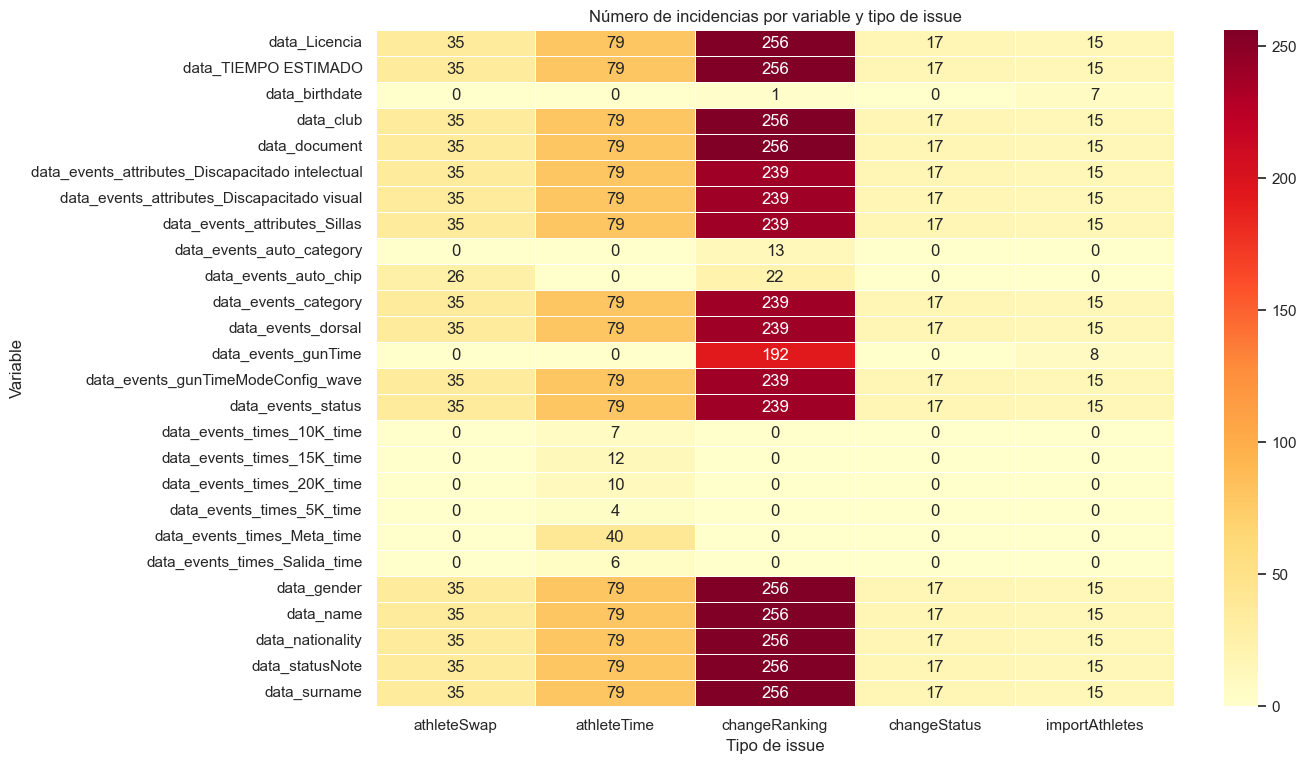

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar columnas relevantes
cols_data = [c for c in IA.columns if c.startswith('data_') or c.startswith('data_events_')]

# Crear lista para almacenar los resultados
records = []

for col in cols_data:
    summary = IA.groupby('type')[col].apply(lambda x: x.notna().sum())
    for issue_type, count in summary.items():
        records.append({'variable': col, 'type': issue_type, 'count': count})

# Convertir a DataFrame
df_summary = pd.DataFrame(records)

# Pivot para heatmap
heatmap_data = df_summary.pivot(index='variable', columns='type', values='count').fillna(0)

# --- Heatmap ---
plt.figure(figsize=(14, max(6, len(heatmap_data)*0.3)))  # ajustar altura según número de variables
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlOrRd", 
    linewidths=0.5
)
plt.title("Número de incidencias por variable y tipo de issue")
plt.ylabel("Variable")
plt.xlabel("Tipo de issue")
plt.tight_layout()
plt.show()

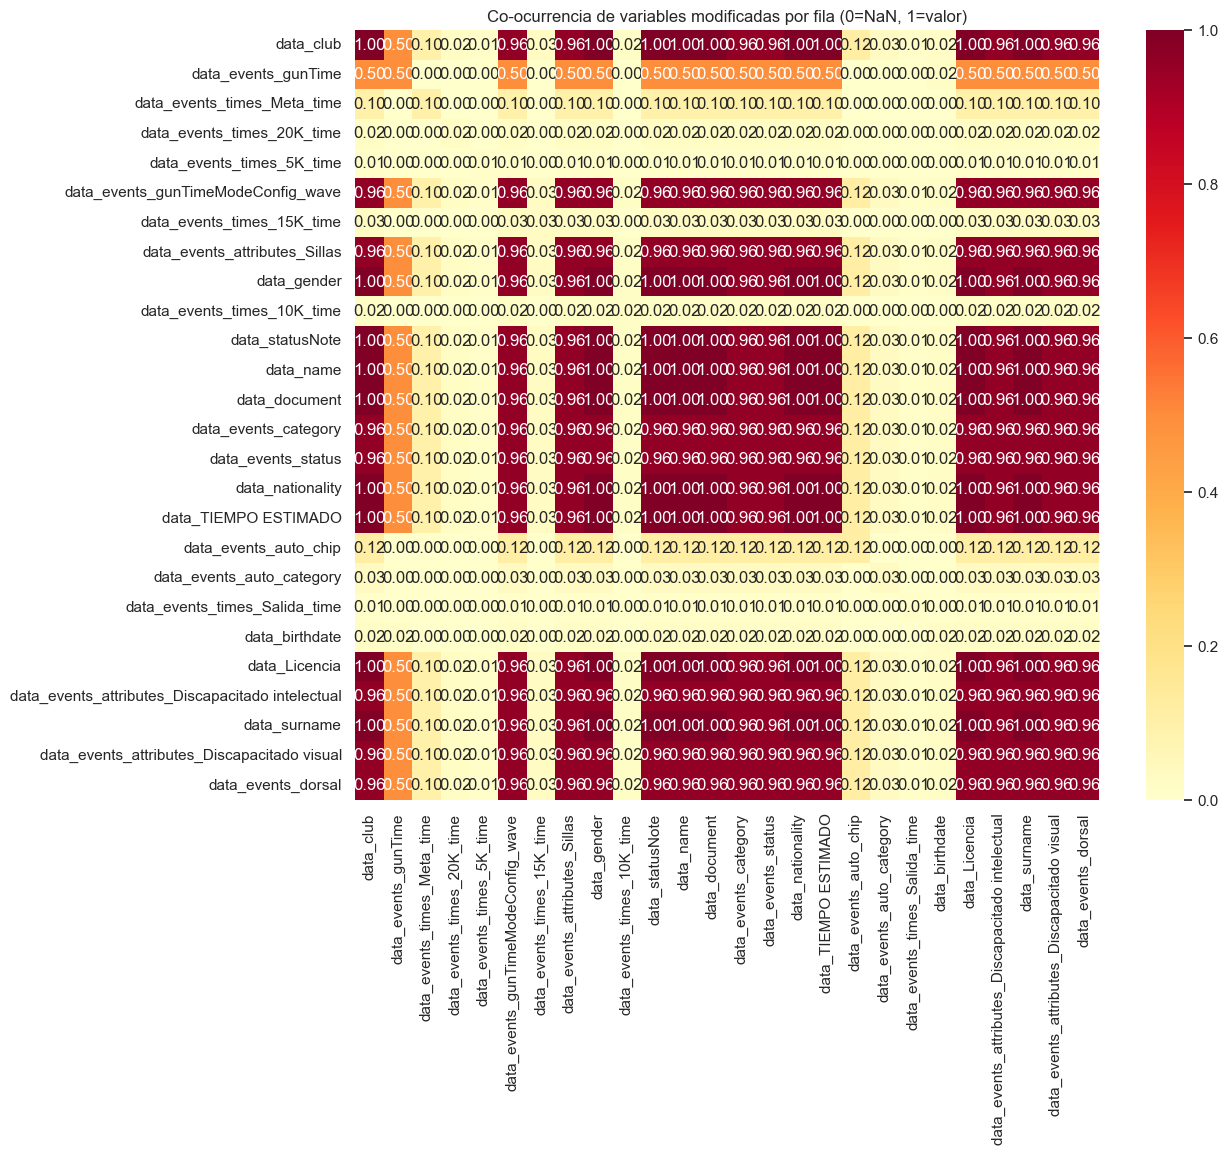

In [91]:
# 1️⃣ Crear matriz binaria: 1 si hay valor, 0 si NaN
df_binary = IA[cols_data].notna().astype(int)

# 2️⃣ Matriz de co-ocurrencia (cuántas veces se modifican juntas)
cooccurrence = df_binary.T.dot(df_binary)

# 3️⃣ Normalizar opcionalmente por número de incidencias para que sea % de co-ocurrencia
cooccurrence_pct = cooccurrence / len(IA)

# 4️⃣ Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cooccurrence_pct, cmap='YlOrRd', annot=True, fmt=".2f")
plt.title("Co-ocurrencia de variables modificadas por fila (0=NaN, 1=valor)")
plt.show()

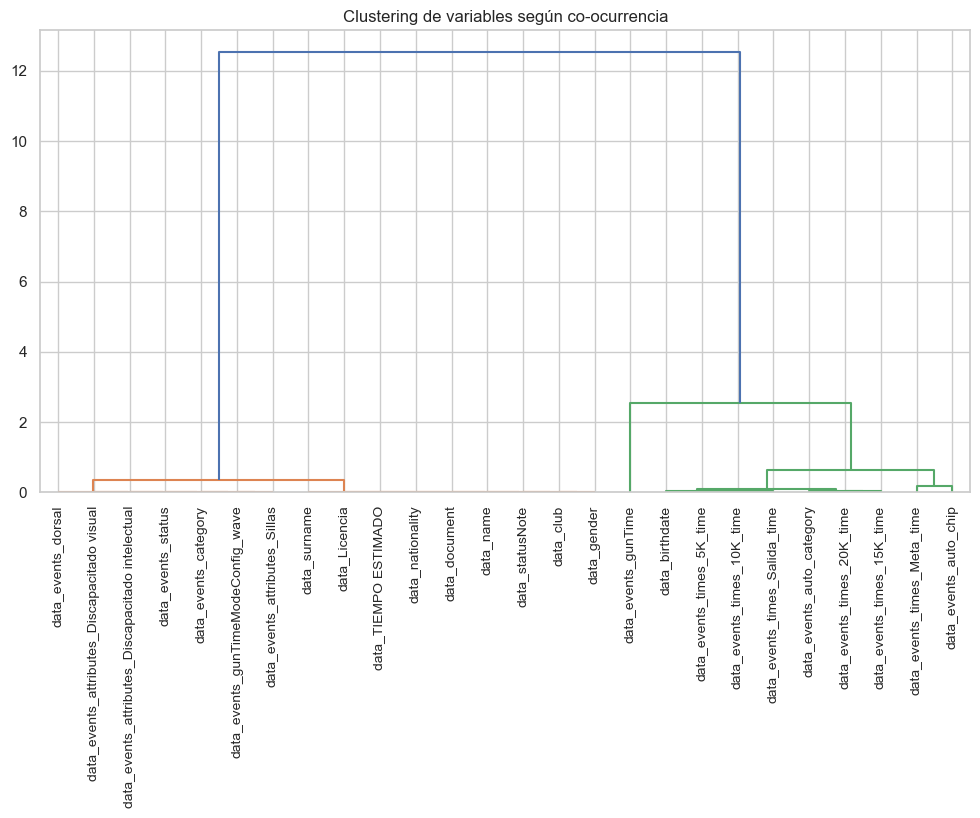

In [92]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 1️⃣ Matriz binaria: 1 si hay valor, 0 si NaN
df_binary = IA[cols_data].notna().astype(int)

# 2️⃣ Matriz de co-ocurrencia normalizada
cooccurrence = df_binary.T.dot(df_binary) / len(df_binary)

# 3️⃣ Convertir a distancia
dist_matrix = 1 - cooccurrence

# 4️⃣ Clustering jerárquico
linked = linkage(dist_matrix, method='ward')

# 5️⃣ Dendrograma
plt.figure(figsize=(12,6))
dendrogram(linked, labels=cooccurrence.columns, leaf_rotation=90)
plt.title("Clustering de variables según co-ocurrencia")
plt.show()

In [117]:
from itertools import combinations
from collections import Counter

combinations_by_type = {}

for tipo in df_changes['type'].unique():
    df_tipo = df_changes[df_changes['type'] == tipo]
    
    # Agrupamos por instante y issue, obtenemos lista de variables modificadas
    grouped = df_tipo.groupby(['id', 'datetime'])['variable'].apply(list)
    
    # Contamos combinaciones de 2 variables (puedes aumentar n)
    comb_counter = Counter()
    for vars_list in grouped:
        comb_counter.update(combinations(sorted(vars_list), 2))
    
    combinations_by_type[tipo] = comb_counter.most_common(10)  # top 10 combinaciones

# Mostrar resultados
for tipo, combs in combinations_by_type.items():
    print(f"\nTipo: {tipo}\nTop combinaciones de variables cambiadas:")
    for combo, count in combs:
        print(f"{combo}: {count}")


Tipo: importAthletes
Top combinaciones de variables cambiadas:
('data_birthdate', 'data_document'): 7
('data_birthdate', 'data_events_gunTime'): 7
('data_birthdate', 'data_nationality'): 7
('data_document', 'data_events_gunTime'): 7
('data_document', 'data_nationality'): 7
('data_events_gunTime', 'data_nationality'): 7
('data_events_gunTime', 'data_events_gunTimeModeConfig_wave'): 6
('data_birthdate', 'data_events_gunTimeModeConfig_wave'): 5
('data_document', 'data_events_gunTimeModeConfig_wave'): 5
('data_events_gunTimeModeConfig_wave', 'data_nationality'): 5

Tipo: changeRanking
Top combinaciones de variables cambiadas:
('data_events_gunTime', 'data_events_gunTimeModeConfig_wave'): 179
('data_events_auto_category', 'data_events_category'): 11
('data_name', 'data_surname'): 4
('data_events_auto_category', 'data_statusNote'): 2
('data_events_gunTime', 'data_gender'): 1
('data_events_gunTimeModeConfig_wave', 'data_gender'): 1
('data_events_auto_chip', 'data_events_dorsal'): 1

Tipo: at

In [ ]:
# Filtramos cambios reales (solo valores no nulos ni vacíos)
value_cols = [c for c in IA.columns if c.startswith('data_') or c.startswith('data_events_')]

df_changes = IA.melt(
    id_vars=['id', 'type', 'datetime', 'fase_temporal', 'afectados', 'athletes_afectados', 'num_afectados'],
    value_vars=value_cols,
    var_name='variable',
    value_name='valor'
)

# Filtrar valores válidos: no nulos, no vacíos ni NaT
df_changes = df_changes[df_changes['valor'].notna() & (df_changes['valor'] != "")]

# Convertimos datetime si no lo está
df_changes['datetime'] = pd.to_datetime(df_changes['datetime'])

In [103]:
# Calcular porcentaje de atletas afectados
total_athletes = len(athletes_df)
df_changes['pct_afectados'] = df_changes['num_afectados'] / total_athletes * 100

# Crear scatterplot con Plotly Express
import plotly.express as px

fig = px.scatter(
    df_changes,
    x='datetime',
    y='variable',
    color='type',
    size_max=12,
    hover_data=['pct_afectados'],
    title='Cambios de variables a lo largo del tiempo por tipo de issue'
)
fig.show()

Vemos como la mayoría de errores se distribuyen pre carrera, en carrera y unos pocos dias y horas despues de la carrera. Lo cuál nos da un contexto de como se van cambiando y en los momentos en el que lo hacen. 

In [105]:
import plotly.express as px

color_map = {
    'athleteTime': 'blue',
    'changeRanking': 'red',
    'athleteSwap': 'green',
    'importAthletes': 'orange',
    'changeStatus': 'purple',
    'other': 'brown'
}

for tipo in df_changes['type'].unique():
    df_tipo = df_changes[(df_changes['type'] == tipo) & (df_changes['pct_afectados'].notna())]

    if df_tipo.empty:
        continue  

    color = color_map.get(tipo, 'gray')

    fig = px.scatter(
        df_tipo,
        x='datetime',
        y='variable',
        color_discrete_sequence=[color],  # un solo color por tipo
        size_max=12,
        hover_data=['pct_afectados'],
        title=f'Cambios de variables a lo largo del tiempo - Tipo: {tipo}'
    )

    fig.update_layout(
        dragmode='zoom',           
        hovermode='closest',       
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show(config={'scrollZoom': True, 'displayModeBar': True})

- **importAthletes**: Casi todos antes de empezar la carrera, seguramente se importan 

In [113]:
import pandas as pd
import plotly.express as px
import numpy as np

# Copiar DataFrame
df_plot = IA.copy()
df_plot['datetime'] = pd.to_datetime(df_plot['datetime'])

# Hover solo con valores no nulos
cols_data = [c for c in df_plot.columns if c.startswith("data_") or c.startswith("data_events_")]

def make_hover(row):
    hover_text = (
        f"ID: {row['id']}<br>"
        f"Tipo: {row['type']}<br>"
        f"Afectados: {row['afectados']*100:.1f}% ({row['num_afectados']})"
    )
    for col in cols_data:
        val = row[col]
        if pd.notna(val) and val not in ["", None, "NaT"]:
            hover_text += f"<br>{col}: {val}"
    return hover_text

df_plot['hover'] = df_plot.apply(make_hover, axis=1)

# Tamaño según número de afectados, escala gradual
# Usamos raíz cuadrada para suavizar diferencias grandes
df_plot['afectados_size'] = np.sqrt(df_plot['num_afectados'])

# Gráfico scatter
fig = px.scatter(
    df_plot,
    x='datetime',
    y='type',
    size='afectados_size',
    color='type',
    hover_name='hover',
    title="Distribución de tipos de issues en el tiempo",
    height=600
)

# Líneas verticales para fases temporales
for fase in df_plot['fase_temporal'].dropna().unique():
    fechas = df_plot[df_plot['fase_temporal'] == fase]['datetime']
    if not fechas.empty:
        fecha_min = fechas.min()
        fig.add_shape(
            type="line",
            x0=fecha_min,
            x1=fecha_min,
            y0=-0.5,
            y1=len(df_plot['type'].unique()) - 0.5,
            line=dict(color="gray", dash="dash"),
        )
        fig.add_annotation(
            x=fecha_min,
            y=len(df_plot['type'].unique()) - 0.5,
            text=fase,
            showarrow=False,
            xanchor="left",
            yanchor="bottom"
        )

# Configuración interacción y zoom
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    dragmode=False,        # desactiva zoom por arrastre
    hovermode='closest'
)

# Ajuste del tamaño de los puntos
fig.update_traces(marker=dict(sizemode='area', sizeref=0.1, line_width=1))

# Zoom con Ctrl + rueda del ratón
fig.show(config={
    'scrollZoom': True,  
    'displayModeBar': True,
})

In [114]:
pd.crosstab(IA['type'], IA['fase_temporal'], normalize='index')

fase_temporal   en carrera  post-carrera  pre-carrera
type                                                 
athleteSwap       0.028571      0.371429      0.60000
athleteTime       0.113924      0.886076      0.00000
changeRanking     0.175781      0.667969      0.15625
changeStatus      0.117647      0.882353      0.00000
importAthletes    0.000000      0.000000      1.00000

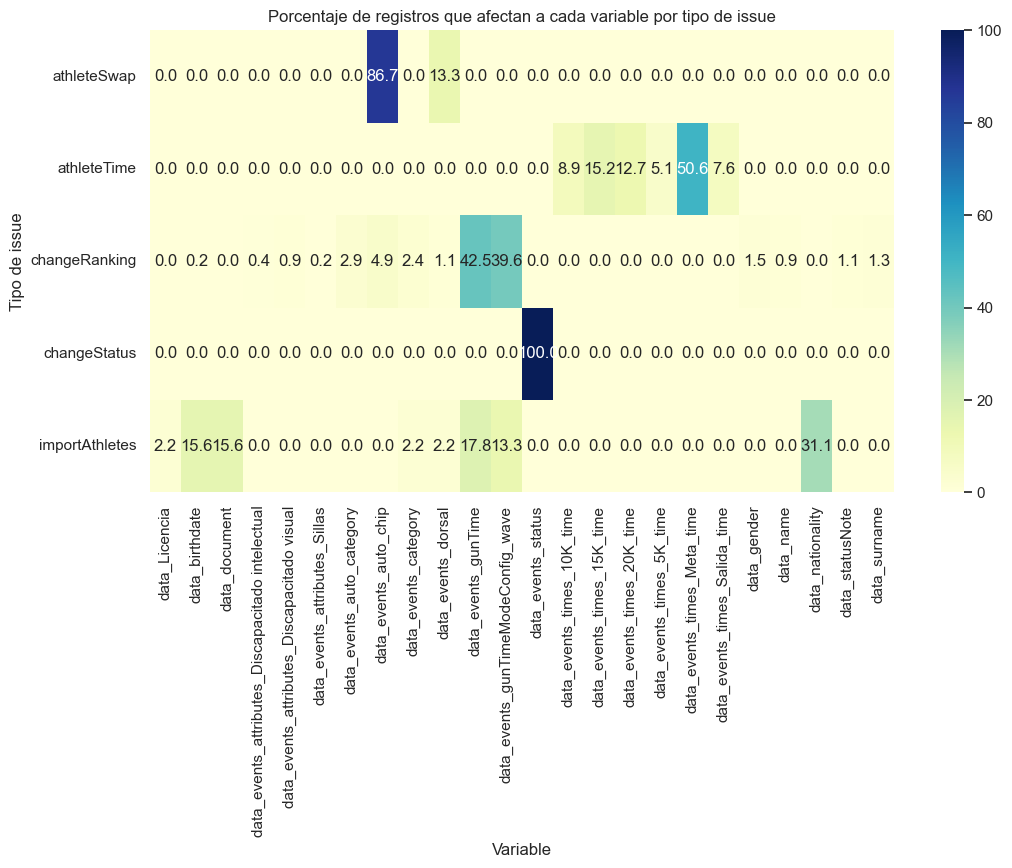

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df_changes: columnas ['type', 'variable', 'valor'] o cualquier columna que indique cambio

# 1️⃣ Contar cuántos registros tienen un valor modificado para cada variable y tipo
counts = df_changes.groupby(['type', 'variable'])['valor'].count().unstack(fill_value=0)

# 2️⃣ Dividir entre el total de registros de cada tipo para obtener porcentaje
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100

# 3️⃣ Visualización como heatmap
plt.figure(figsize=(12,6))
sns.heatmap(counts_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Porcentaje de registros que afectan a cada variable por tipo de issue')
plt.ylabel('Tipo de issue')
plt.xlabel('Variable')
plt.show()

### Correlaciones de los issues con las variables

Anteriormente hemos obtenido algunas conclusiones en base a los tipos de error, y creemos que los errores de tipo changeranking, athleteswap e importathletes no entran en nuestro estudio por diferentes moticos (poca abstraccion y contexto e importaciones generales). Por lo que nuestro estudio se centrará en changestatus y athlete time, de las cuáles intentaremos predecir el porque un atleta cambia su estatus de carrera o modifica su tiempo en base a los datos de carrera. 

Identificar qué causas explican (o se asocian con alta probabilidad) la aparición de issues tipo:

- changeStatus — cambios de estado del atleta (p.ej. pasa a retired, DSQ, etc.)

- athleteTime — cambios de tiempos (errores o correcciones de cronometraje).

Y esas causas pueden venir de dos fuentes:

- Variables del atleta (athletes_df, athletes_events_df, …)

- Otros issues sobre el mismo atleta o variable, en momentos cercanos (correlación espacial-temporal).

In [103]:
df_changes.head()

id         type  \
79   2e616100-eec0-11ef-ba02-2d3eb2d81d1f  athleteTime   
140  5c88e2a0-ee94-11ef-9ab3-55798f1380ce  athleteTime   
336  ccb409f0-ed37-11ef-9ac5-999bc91314b6  athleteTime   
401  ff1b2cd0-edd6-11ef-b1a8-0779410a0038  athleteTime   
427  11a62f30-edd7-11ef-b1a8-0779410a0038  athleteTime   

                   datetime fase_temporal  afectados athletes_afectados  \
79  2025-02-19 12:51:05.104  post-carrera   0.000032         [19477A97]   
140 2025-02-19 07:37:24.682  post-carrera   0.000032         [28B12198]   
336 2025-02-17 14:02:18.511  post-carrera   0.000032         [52674F19]   
401 2025-02-18 09:01:53.053  post-carrera   0.000032         [4D831Z6B]   
427 2025-02-18 09:02:24.163  post-carrera   0.000032         [4D831Z6B]   

                       variable      valor  
79    data_events_times_5K_time  1609398.0  
140   data_events_times_5K_time  1581000.0  
336   data_events_times_5K_time  1499877.0  
401   data_events_times_5K_time  1368000.0  
427  data_events_times_10K_time  2503000.0

Primero filtramos por issues relevantes

In [26]:
# Nos quedamos solo con los tipos de issue que queremos estudiar
df_filtrado = df_changes[df_changes['type'].isin(['changeStatus', 'athleteTime'])].copy()

# Aseguramos que la fecha esté en formato datetime
df_filtrado['datetime'] = pd.to_datetime(df_filtrado['datetime'])

print("Tipos de issue incluidos:", df_filtrado['type'].unique())
print("Filas seleccionadas:", len(df_filtrado))
df_filtrado.head()

Tipos de issue incluidos: ['athleteTime' 'changeStatus']
Filas seleccionadas: 96


id         type  \
79   2e616100-eec0-11ef-ba02-2d3eb2d81d1f  athleteTime   
140  5c88e2a0-ee94-11ef-9ab3-55798f1380ce  athleteTime   
336  ccb409f0-ed37-11ef-9ac5-999bc91314b6  athleteTime   
401  ff1b2cd0-edd6-11ef-b1a8-0779410a0038  athleteTime   
427  11a62f30-edd7-11ef-b1a8-0779410a0038  athleteTime   

                   datetime fase_temporal  afectados athletes_afectados  \
79  2025-02-19 12:51:05.104  post-carrera   0.000032         [19477A97]   
140 2025-02-19 07:37:24.682  post-carrera   0.000032         [28B12198]   
336 2025-02-17 14:02:18.511  post-carrera   0.000032         [52674F19]   
401 2025-02-18 09:01:53.053  post-carrera   0.000032         [4D831Z6B]   
427 2025-02-18 09:02:24.163  post-carrera   0.000032         [4D831Z6B]   

                       variable      valor  
79    data_events_times_5K_time  1609398.0  
140   data_events_times_5K_time  1581000.0  
336   data_events_times_5K_time  1499877.0  
401   data_events_times_5K_time  1368000.0  
427  data_events_times_10K_time  2503000.0

In [27]:
# 1️⃣ Expandir la lista de atletas afectados
df_exploded = (
    df_filtrado
    .explode('athletes_afectados')
    .rename(columns={'athletes_afectados': 'athlete_id'})
)

# 2️⃣ Mantener todos los IDs como string limpio
df_exploded['athlete_id'] = df_exploded['athlete_id'].astype(str).str.strip()

print("Filas después de expandir:", len(df_exploded))
print("Ejemplo de athlete_id:", df_exploded['athlete_id'].unique()[:10])
df_exploded.head()

Filas después de expandir: 761
Ejemplo de athlete_id: ['19477A97' '28B12198' '52674F19' '4D831Z6B' 'D43Y2162' 'ZC3F3D71'
 'B4AC91Z4' '6F2A8Y61' 'A1Z3B616' 'BD2YBD42']


id         type  \
79   2e616100-eec0-11ef-ba02-2d3eb2d81d1f  athleteTime   
140  5c88e2a0-ee94-11ef-9ab3-55798f1380ce  athleteTime   
336  ccb409f0-ed37-11ef-9ac5-999bc91314b6  athleteTime   
401  ff1b2cd0-edd6-11ef-b1a8-0779410a0038  athleteTime   
427  11a62f30-edd7-11ef-b1a8-0779410a0038  athleteTime   

                   datetime fase_temporal  afectados athlete_id  \
79  2025-02-19 12:51:05.104  post-carrera   0.000032   19477A97   
140 2025-02-19 07:37:24.682  post-carrera   0.000032   28B12198   
336 2025-02-17 14:02:18.511  post-carrera   0.000032   52674F19   
401 2025-02-18 09:01:53.053  post-carrera   0.000032   4D831Z6B   
427 2025-02-18 09:02:24.163  post-carrera   0.000032   4D831Z6B   

                       variable      valor  
79    data_events_times_5K_time  1609398.0  
140   data_events_times_5K_time  1581000.0  
336   data_events_times_5K_time  1499877.0  
401   data_events_times_5K_time  1368000.0  
427  data_events_times_10K_time  2503000.0

In [28]:
# Filtrar solo issues de tipo changeStatus post-carrera
df_status = df_exploded[
    (df_exploded['type'] == 'changeStatus') &
    (df_exploded['fase_temporal'].str.lower().str.contains('post'))
].copy()

print(f"Total de changeStatus post-carrera: {len(df_status)}")
print("Tipos de estado detectados:")
print(df_status['valor'].value_counts())

Total de changeStatus post-carrera: 636
Tipos de estado detectados:
valor
retired         434
disqualified    200
quarantine        2
Name: count, dtype: int64


In [92]:
status_types = df_status['valor'].unique()

# Diccionario de atletas por tipo de status
status_dict = {
    s: set(df_status.loc[df_status['valor'] == s, 'athlete_id'])
    for s in status_types
}

# Añadir columnas binarias al athletes_events_df
for s in status_types:
    col_name = f'has_status_{s}'
    athletes_events_df[col_name] = athletes_events_df['athlete_id'].isin(status_dict[s]).astype(int)

# Añadir columnas binarias al athletes_events_df
for s in status_types:
    col_name = f'has_status_{s}'
    athletes_time_df[col_name] = athletes_time_df['athlete_id'].isin(status_dict[s]).astype(int)

    # Añadir columnas binarias al athletes_events_df
for s in status_types:
    col_name = f'has_status_{s}'
    athletes_df[col_name] = athletes_df['athlete_id'].isin(status_dict[s]).astype(int)

In [94]:
athletes_df.columns

Index(['Licencia', 'TIEMPO ESTIMADO', 'athlete_id', 'birthdate', 'club',
       'color', 'featured', 'fullName', 'gender', 'id', 'importId', 'name',
       'nationality', 'race_id', 'statusNote', 'surname', 'user_id',
       'club_clean', 'nationality_clean', 'has_status_disqualified',
       'has_status_retired', 'has_status_quarantine'],
      dtype='object')

In [31]:
import pandas as pd

# Fecha de la carrera
race_date = pd.Timestamp('2025-02-16')

# Calcular edad
athletes_df['age'] = (race_date - athletes_df['birthdate']).dt.days // 365

# Crear 4 grupos de edad
bins = [0, 25, 35, 45, 100]  # ajustable según tu población
labels = ['<25', '25-34', '35-44', '45+']

athletes_df['age_group'] = pd.cut(athletes_df['age'], bins=bins, labels=labels, right=False)

# Revisar
athletes_df[['age', 'age_group']].head(10)

athletes_df['age_group'] = athletes_df['age_group'].astype('category')

In [113]:
print(athletes_df['age_group'].dtype)

category


In [75]:
athletes_df.columns

Index(['Licencia', 'TIEMPO ESTIMADO', 'athlete_id', 'birthdate', 'club',
       'color', 'featured', 'fullName', 'gender', 'id', 'importId', 'name',
       'nationality', 'race_id', 'statusNote', 'surname', 'user_id',
       'has_status_disqualified', 'has_status_retired',
       'has_status_quarantine', 'age', 'age_group'],
      dtype='object')

In [79]:
athletes_df['has_status_retired'].value_counts()

has_status_retired
0    31249
1      434
Name: count, dtype: int64

In [89]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, fisher_exact
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Función para V de Cramer ---
def cramers_v(confusion_matrix):
    """Calcula V de Cramer para tablas de contingencia"""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * k))

# --- Función principal de análisis ---
def analyze_dataframe(df, dummy_cols, max_categories=20):
    """
    Analiza un DataFrame comparando variables categóricas, numéricas y timedelta frente a dummies.
    Incluye:
      - Chi² y Fisher (para categóricas)
      - t-test y Mann-Whitney (para numéricas)
      - Regresión logística balanceada (odds ratio)
    """
    results = {'categorical': [], 'numerical': []}

    # Identificar tipos de columnas
    numeric_cols = df.select_dtypes(include=[np.number, 'timedelta']).columns.difference(dummy_cols)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # --- Análisis categórico ---
    for cat_col in categorical_cols:
        n_categories = df[cat_col].nunique()
        if n_categories > max_categories:
            continue

        for dummy in dummy_cols:
            try:
                table = pd.crosstab(df[cat_col], df[dummy])

                if table.shape[0] > 1 and table.shape[1] > 1:
                    chi2, p_chi2, _, _ = chi2_contingency(table)
                    v = cramers_v(table)

                    # Fisher sólo si la tabla es 2x2
                    p_fisher = np.nan
                    if table.shape == (2, 2):
                        _, p_fisher = fisher_exact(table)

                    results['categorical'].append({
                        'categorical_var': cat_col,
                        'dummy': dummy,
                        'chi2': chi2,
                        'p_chi2': p_chi2,
                        'p_fisher': p_fisher,
                        'cramers_v': v
                    })
            except Exception as e:
                print(f"Error en {cat_col} vs {dummy}: {e}")
                continue

    # --- Análisis numérico / timedelta ---
    for num_col in numeric_cols:
        for dummy in dummy_cols:
            col_data = df[num_col]

            # Convertir timedelta a segundos si aplica
            if np.issubdtype(col_data.dtype, np.timedelta64):
                col_data = col_data.dt.total_seconds()

            group0 = col_data[df[dummy] == 0].dropna()
            group1 = col_data[df[dummy] == 1].dropna()

            # Saltar si falta un grupo
            if len(group0) == 0 or len(group1) == 0:
                continue

            try:
                # --- t-test ---
                t_stat, t_p = ttest_ind(group0, group1, nan_policy='omit')

                # --- Mann-Whitney ---
                u_stat, u_p = mannwhitneyu(group0, group1, alternative='two-sided')

                # --- Regresión logística balanceada ---
                valid_idx = df[[num_col, dummy]].dropna().index
                X = df.loc[valid_idx, [num_col]].astype(float)
                y = df.loc[valid_idx, dummy].astype(int)

                logit = LogisticRegression(class_weight='balanced', solver='liblinear')
                logit.fit(X, y)

                coef = logit.coef_[0][0]
                odds_ratio = np.exp(coef)

                results['numerical'].append({
                    'numeric_var': num_col,
                    'dummy': dummy,
                    't_stat': t_stat,
                    't_pvalue': t_p,
                    'mannwhitney_u': u_stat,
                    'mannwhitney_pvalue': u_p,
                    'logit_coef': coef,
                    'odds_ratio': odds_ratio
                })

            except Exception as e:
                print(f"Error en {num_col} vs {dummy}: {e}")
                continue

    return results


# === Ejemplo de uso ===
dummy_cols = ['has_status_retired', 'has_status_disqualified']

analysis_results = analyze_dataframe(athletes_df, dummy_cols, max_categories=20)

# Convertir resultados a DataFrames
cat_results_df = pd.DataFrame(analysis_results['categorical'])
num_results_df = pd.DataFrame(analysis_results['numerical'])

print("=== Resultados categóricos ===")
print(cat_results_df)

print("\n=== Resultados numéricos (con regresión logística balanceada) ===")
print(num_results_df)

=== Resultados categóricos ===
    categorical_var                    dummy          chi2        p_chi2  \
0   TIEMPO ESTIMADO       has_status_retired    223.364116  4.759258e-41   
1   TIEMPO ESTIMADO  has_status_disqualified     18.285532  1.072918e-01   
2             color       has_status_retired      9.977400  3.523180e-01   
3             color  has_status_disqualified     10.174898  3.365128e-01   
4            gender       has_status_retired      0.669888  7.153781e-01   
5            gender  has_status_disqualified      2.842526  2.414090e-01   
6          importId       has_status_retired    345.806557  1.581937e-64   
7          importId  has_status_disqualified     12.067927  6.738803e-01   
8        statusNote       has_status_retired      1.840983  1.748357e-01   
9        statusNote  has_status_disqualified  30726.815447  0.000000e+00   
10        age_group       has_status_retired      1.658274  6.462499e-01   
11        age_group  has_status_disqualified     54.23330

In [84]:
# --- Ejemplo de uso ---
dummy_cols = ['has_status_quarantine', 'has_status_retired', 'has_status_disqualified']
analysis_results = analyze_dataframe(athletes_events_df, dummy_cols, max_categories=20)

# Convertir a DataFrame para visualizar mejor
cat_results_df = pd.DataFrame(analysis_results['categorical'])
num_results_df = pd.DataFrame(analysis_results['numerical'])

print("Categorical results:")
print(cat_results_df)

print("\nNumerical results:")
print(num_results_df)

Error en leader_time_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en leader_time_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en leader_time_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en startNetTime_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en startNetTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en startTime_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en startTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Categorical results:
                         categorical_var                    dummy  \
0   attributes_Discapacitado intelectual    has_status_quarantine   
1   attributes_Discapacitado intelectual       has_status_retired   
2   attributes_Discapacitado intelectual  has_status_disqualified   
3        attributes_Discapacitado visual    has_st

In [90]:
# --- Ejemplo de uso ---
dummy_cols = ['has_status_quarantine', 'has_status_retired', 'has_status_disqualified']
analysis_results = analyze_dataframe(athletes_time_df, dummy_cols, max_categories=20)

# Convertir a DataFrame para visualizar mejor
cat_results_df = pd.DataFrame(analysis_results['categorical'])
num_results_df = pd.DataFrame(analysis_results['numerical'])

print("Categorical results:")
print(cat_results_df)

print("\nNumerical results:")
print(num_results_df)

Error en netTime_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en netTime_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en netTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en offset_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en offset_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en originalTime_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en originalTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en raw_backupOffset_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en raw_backupOffset_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en raw_times_official_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en raw_times_official_td vs has_status_retired: Cannot cas

**Retired**: average, netTime, order, splitsMissing,
**Disqualified**: age, issuesCount_data, splitsMissing, statusNote. 

In [93]:
# --- Calcular conteo de atletas descalificados por número de splits missing ---

# 1️⃣ Extraemos las columnas necesarias
df_splits = athletes_events_df[['athlete_id', 'splitsMissing', 'has_status_disqualified']]

# 2️⃣ Combinamos ambas tablas
merged = df_splits.merge(df_status, on='athlete_id', how='left')

# 3️⃣ Filtramos solo los atletas descalificados
disqualified = merged[merged['has_status_disqualified'] == 1]

# 4️⃣ Contamos cuántos tienen 0, 1, 2... splits faltantes
count_by_missing_splits = disqualified['splitsMissing'].value_counts().sort_index()

# 5️⃣ (Opcional) Calculamos también las proporciones
proportion_by_missing_splits = (count_by_missing_splits / count_by_missing_splits.sum()) * 100

# --- Resultados ---
print("Conteo de atletas descalificados por número de splits faltantes:")
print(count_by_missing_splits)

print("\nProporción (%):")
print(proportion_by_missing_splits.round(2))

Conteo de atletas descalificados por número de splits faltantes:
splitsMissing
0     2
2    79
3    58
4    37
5    26
Name: count, dtype: int64

Proporción (%):
splitsMissing
0     0.99
2    39.11
3    28.71
4    18.32
5    12.87
Name: count, dtype: float64


### Change status: correlacion temporal

Posible modelo de hawkess

In [105]:
import pandas as pd

df = df_changes.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df['type'] = df['type'].astype(str)

print("Rango temporal:", df['datetime'].min(), "→", df['datetime'].max())
print("\nNúmero de eventos por tipo:\n", df['type'].value_counts())

Rango temporal: 2025-02-11 08:57:51.349000 → 2025-04-23 07:48:44.243000

Número de eventos por tipo:
 type
changeRanking     452
athleteTime        79
importAthletes     45
athleteSwap        30
changeStatus       17
Name: count, dtype: int64


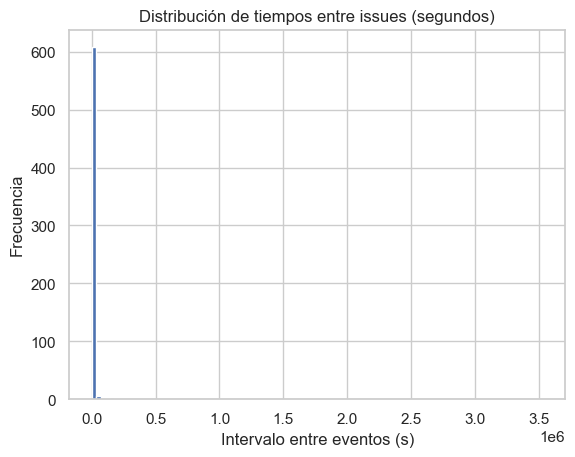

Media: 9855.71 segundos
Desviación estándar: 145613.42
Coeficiente de variación (CV): 14.77


In [107]:
import matplotlib.pyplot as plt

df_sorted = df.sort_values('datetime')
dt = df_sorted['datetime'].diff().dt.total_seconds().dropna()

plt.hist(dt, bins=100)
plt.title('Distribución de tiempos entre issues (segundos)')
plt.xlabel('Intervalo entre eventos (s)')
plt.ylabel('Frecuencia')
plt.show()

print("Media:", round(dt.mean(), 2), "segundos")
print("Desviación estándar:", round(dt.std(), 2))
print("Coeficiente de variación (CV):", round(dt.std()/dt.mean(), 2))

In [108]:
import numpy as np

def proportion_preceded(df, type_a, type_b, window_s=300):
    """
    Devuelve la proporción de eventos de tipo B que tienen al menos un A
    en los window_s segundos anteriores.
    """
    t0 = df['datetime'].min()
    df['t'] = (df['datetime'] - t0).dt.total_seconds()

    A_times = df.loc[df['type'] == type_a, 't'].values
    B_times = df.loc[df['type'] == type_b, 't'].values

    count_preceded = 0
    for tb in B_times:
        if np.any((A_times < tb) & (A_times > tb - window_s)):
            count_preceded += 1

    return count_preceded / len(B_times) if len(B_times) > 0 else np.nan

In [109]:
types = ['changeRanking', 'athleteTime', 'importAthletes', 'athleteSwap']

for t in types:
    prop = proportion_preceded(df_changes, t, 'changeStatus', window_s=300)
    print(f"{t} → changeStatus: {prop:.2%}")

changeRanking → changeStatus: 29.41%
athleteTime → changeStatus: 11.76%
importAthletes → changeStatus: 0.00%
athleteSwap → changeStatus: 0.00%


In [114]:
import pandas as pd

# --- CONFIGURACIÓN ---
window_s = 300  # ventana de 5 minutos
target_type = 'changeStatus'
reference_types = ['changeRanking', 'athleteTime', 'importAthletes', 'athleteSwap']

# Asegurar orden temporal
df_changes = df_changes.sort_values('datetime').reset_index(drop=True)

# --- Filtrar solo los changeStatus ---
target_events = df_changes[df_changes['type'] == target_type].copy()

# Detectar si el valor del changeStatus contiene retired/disqualified
target_events['status_value'] = target_events['valor'].astype(str).str.lower()

# --- Calcular precedentes ---
results = []

for status in ['disqualified']:
    targets = target_events[target_events['status_value'].str.contains(status, na=False)]
    
    for ref_type in reference_types:
        ref_events = df_changes[df_changes['type'] == ref_type]
        
        for _, target in targets.iterrows():
            nearby = ref_events[
                (ref_events['datetime'] <= target['datetime']) &
                (ref_events['datetime'] >= target['datetime'] - pd.Timedelta(seconds=window_s))
            ]
            for _, nb in nearby.iterrows():
                results.append({
                    'status': status,
                    'changeStatus_id': target['id'],
                    'preceding_type': ref_type,
                    'preceding_variable': nb['variable'],
                    'preceding_valor': nb['valor'],
                    'time_diff_s': (target['datetime'] - nb['datetime']).total_seconds()
                })

df_prox = pd.DataFrame(results)

# --- Agregar estadísticas ---
summary_vars = (
    df_prox.groupby(['status', 'preceding_type', 'preceding_variable'])
    .size()
    .reset_index(name='count')
)

summary_time = (
    df_prox.groupby(['status', 'preceding_type', 'preceding_variable'])['time_diff_s']
    .mean()
    .reset_index(name='avg_seconds_before')
)

# Unir y ordenar
summary = (
    summary_vars.merge(summary_time, on=['status', 'preceding_type', 'preceding_variable'])
    .sort_values(['status', 'avg_seconds_before', 'count'], ascending=[True, True, False])
    .reset_index(drop=True)
)

print("=== Variables precedentes antes de cada tipo de changeStatus (ordenadas) ===")
print(summary.head(30))

# --- (Opcional) Análisis de valores numéricos precedentes ---
numeric_subset = df_prox[
    pd.to_numeric(df_prox['preceding_valor'], errors='coerce').notnull()
].copy()
numeric_subset['preceding_valor'] = numeric_subset['preceding_valor'].astype(float)

mean_values = (
    numeric_subset.groupby(['status', 'preceding_variable'])['preceding_valor']
    .mean()
    .reset_index()
    .sort_values(['status', 'preceding_valor'], ascending=[True, False])
)

print("\n=== Valores promedio de variables que preceden a cada tipo de changeStatus ===")
print(mean_values.head(20))

=== Variables precedentes antes de cada tipo de changeStatus (ordenadas) ===
         status preceding_type                  preceding_variable  count  \
0  disqualified  changeRanking           data_events_auto_category      1   
1  disqualified  changeRanking                     data_statusNote      1   
2  disqualified    athleteTime          data_events_times_20K_time      1   
3  disqualified    athleteTime          data_events_times_15K_time      1   
4  disqualified  changeRanking                 data_events_gunTime      2   
5  disqualified  changeRanking  data_events_gunTimeModeConfig_wave      2   
6  disqualified  changeRanking                        data_surname      1   
7  disqualified  changeRanking               data_events_auto_chip      1   

   avg_seconds_before  
0              6.1950  
1              6.1950  
2             99.5930  
3            111.0310  
4            112.4925  
5            112.4925  
6            122.2960  
7            181.5730  

=== Valores 

🧭 Manual: Cómo estudiar las causas de los changeStatus
🎯 Objetivo

Queremos entender por qué se produce un cambio de estado (changeStatus) en un atleta, especialmente los que ocurren post-carrera, como “disqualified”, “retired”, etc.

El propósito es detectar qué variables o eventos previos pueden haber provocado ese cambio:
por ejemplo, si un atleta fue descalificado por una anomalía en su tiempo, una penalización, o una corrección posterior.

1️⃣ Qué datos vamos a usar

Tenemos varias tablas (dataframes):

df_exploded: contiene los issues o incidencias detectadas (por ejemplo athleteTime, changeStatus, etc.), junto con el momento (datetime), el atleta afectado y la variable implicada.

athletes_times_df: tiene los tiempos del atleta en diferentes puntos de la carrera (5K, 10K, meta, etc.).

athletes_events_df: tiene los datos generales del atleta en la competición (posición, estado, penalizaciones, etc.).

(Opcionalmente) otras tablas, como penalizaciones o atributos del atleta.

2️⃣ Filtrar los changeStatus relevantes

Solo analizamos los changeStatus post-carrera, porque son los que reflejan decisiones finales y no ajustes intermedios.
Estos suelen indicar descalificaciones, retiradas o correcciones del resultado final.

3️⃣ Consultar la información del atleta antes del cambio

Para cada atleta que tiene un changeStatus, buscamos cómo estaban sus datos durante la carrera, es decir:

Sus tiempos en athletes_times_df

Sus posiciones, estados o penalizaciones en athletes_events_df

Esto nos da el contexto: por ejemplo, si un atleta fue descalificado, podemos ver si tenía tiempos extraños, estaba muy atrás o tenía penalizaciones previas.

4️⃣ Analizar los issues anteriores cercanos en el tiempo

También es importante ver si antes del changeStatus hubo otros issues que pudieran estar relacionados, por ejemplo:

Un athleteTime justo antes (cambio o corrección de tiempo)

Un changeRanking (cambio en la clasificación)

O varios issues seguidos en el mismo atleta

La idea es mirar una ventana temporal corta (por ejemplo, 5 o 10 minutos antes del changeStatus) y comprobar si ocurrieron otros issues en ese periodo.

De esta forma podemos ver patrones como:

“Los atletas descalificados suelen tener un cambio en su tiempo pocos minutos antes”.

5️⃣ Construir una tabla resumen para el análisis

Una vez recogida la información anterior, se puede preparar una tabla (DataFrame) con una fila por cada atleta con changeStatus.
En esa tabla pondremos:

El athlete_id

El tipo de changeStatus (por ejemplo “disqualified”, “retired”)

Los tiempos que tenía (5K, 10K, meta, etc.)

Si tenía penalizaciones

Cuántos issues tuvo antes del cambio

Qué tipo de issues tuvo antes (por ejemplo, athleteTime, changeRanking, etc.)

Así podremos comparar visualmente y estadísticamente las características de cada caso.

6️⃣ Analizar las relaciones o correlaciones

Una vez tenemos esa tabla resumen:

Si las variables son numéricas (por ejemplo tiempos, posiciones, etc.), podemos estudiar correlaciones para ver si ciertos valores extremos están asociados a ciertos changeStatus.

Si las variables son categóricas (por ejemplo tipo de estado o penalización), podemos usar tablas de frecuencias para ver qué combinaciones son más comunes.

El objetivo es encontrar patrones del tipo:

“Los atletas con tiempos irregulares en los últimos 5K suelen tener un cambio de estado”.

“Las descalificaciones post-carrera se concentran en atletas que tuvieron un cambio de tiempo justo antes”.

### Análisis adicionales

In [11]:
# --- Código principal ---
print("📋 VARIABLES POR DATAFRAME:\n")
for nombre, df in dfs_final.items():
    print(f"➡️ {nombre}:")
    if df.empty:
        print("   ⚠️ DataFrame vacío\n")
    else:
        columnas = df.columns.tolist()
        print(f"   {len(columnas)} columnas")
        print("   Variables:", columnas, "\n")

📋 VARIABLES POR DATAFRAME:

➡️ athletes_df:
   17 columnas
   Variables: ['Licencia', 'TIEMPO ESTIMADO', 'athlete_id', 'birthdate', 'club', 'color', 'featured', 'fullName', 'gender', 'id', 'importId', 'name', 'nationality', 'race_id', 'statusNote', 'surname', 'user_id'] 

➡️ athletes_events_df:
   62 columnas
   Variables: ['athlete_id', 'attributes_Discapacitado intelectual', 'attributes_Discapacitado visual', 'attributes_Sillas', 'auto_category', 'auto_chip', 'calculatedTimes_10K_net', 'calculatedTimes_10K_official', 'calculatedTimes_15K_net', 'calculatedTimes_15K_official', 'calculatedTimes_20K_net', 'calculatedTimes_20K_official', 'calculatedTimes_5K_net', 'calculatedTimes_5K_official', 'calculatedTimes_Meta_net', 'calculatedTimes_Meta_official', 'category', 'commentatorTimes_10K', 'commentatorTimes_15K', 'commentatorTimes_20K', 'commentatorTimes_5K', 'commentatorTimes_Meta', 'commentatorTimes_Salida', 'distance', 'dorsal', 'event', 'event_id', 'gunTime', 'gunTimeMode', 'gunTimeMod

In [15]:
athletes_df = dfs_final['athletes_df']
athletes_events_df = dfs_final['athletes_events_df']
athletes_time_df = dfs_final['athletes_time_df']

In [22]:
df_base = (
    athletes_time_df.merge(athletes_events_df, on=['athlete_id', 'race_id'], how='left', suffixes=('_time', '_event'))
         .merge(athletes_df, on='athlete_id', how='left')
)

In [23]:
df_base

athlete_id  average  distance_time event_id_time incidence isBackup  \
0              31  0.00000              0         Mitja       NaN      NaN   
1              31  0.17876           5000         Mitja       NaN      NaN   
2             159  0.00000              0         Mitja       NaN      NaN   
3             159  0.21763           5000         Mitja       NaN      NaN   
4             159  0.21633          10000         Mitja       NaN      NaN   
...           ...      ...            ...           ...       ...      ...   
162738   168758C2  0.28797           5000         Mitja       NaN      NaN   
162739   168758C2  0.27847          10000         Mitja       NaN      NaN   
162740   168758C2  0.27513          15000         Mitja       NaN      NaN   
162741   168758C2  0.27566          20000         Mitja       NaN      NaN   
162742   168758C2  0.27534          21097         Mitja       NaN      NaN   

       location  netTime  offset  order  ...                  fullName  \
0                      0     NaN      1  ...       Abdezaliz Merzougui   
1                 891230     NaN      2  ...       Abdezaliz Merzougui   
2                      0     NaN      1  ...              Floriane Hot   
3                1081165     NaN      2  ...              Floriane Hot   
4                2156349     NaN      3  ...              Floriane Hot   
...         ...      ...     ...    ...  ...                       ...   
162738           1384781     NaN      2  ...  Baltasar Barberán Esteve   
162739           2729600     NaN      3  ...  Baltasar Barberán Esteve   
162740           4071865     NaN      4  ...  Baltasar Barberán Esteve   
162741           5458158     NaN      5  ...  Baltasar Barberán Esteve   
162742           5753716     NaN      6  ...  Baltasar Barberán Esteve   

        gender        id                              importId       name  \
0         male        31  aae3f350-e853-11ef-8d89-09ba8cee1a95  Abdezaliz   
1         male        31  aae3f350-e853-11ef-8d89-09ba8cee1a95  Abdezaliz   
2       female       159  aae3f350-e853-11ef-8d89-09ba8cee1a95   Floriane   
3       female       159  aae3f350-e853-11ef-8d89-09ba8cee1a95   Floriane   
4       female       159  aae3f350-e853-11ef-8d89-09ba8cee1a95   Floriane   
...        ...       ...                                   ...        ...   
162738    male  168758C2  aad4d820-e853-11ef-a149-eb364f5bb657   Baltasar   
162739    male  168758C2  aad4d820-e853-11ef-a149-eb364f5bb657   Baltasar   
162740    male  168758C2  aad4d820-e853-11ef-a149-eb364f5bb657   Baltasar   
162741    male  168758C2  aad4d820-e853-11ef-a149-eb364f5bb657   Baltasar   
162742    male  168758C2  aad4d820-e853-11ef-a149-eb364f5bb657   Baltasar   

       nationality                             race_id_y statusNote  \
0               es  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
1               es  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
2               FR  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
3               FR  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
4               FR  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
...            ...                                   ...        ...   
162738          ES  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
162739          ES  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
162740          ES  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
162741          ES  1a83229e-2547-42a3-b5b4-36c7425c4d8f              
162742          ES  1a83229e-2547-42a3-b5b4-36c7425c4d8f              

                surname  user_id  
0             Merzougui        0  
1             Merzougui        0  
2                   Hot        0  
3                   Hot        0  
4                   Hot        0  
...                 ...      ...  
162738  Barberán Esteve        0  
162739  Barberán Esteve        0  
162740  Barberán Esteve        0  
162741  Barberán Esteve        0  
162742  Barberán E

Filas con nulos en netTime, gender, category, distance, age o split se eliminan.

Split de salida se excluye porque no aporta variabilidad.

Tests aplicados por split

Gender vs netTime: Mann–Whitney U (no paramétrico).

Category vs netTime: Kruskal–Wallis (no paramétrico).

Distance vs netTime: Spearman (correlación de rangos).

Age vs netTime: Spearman (correlación de rangos).

Supuestos

Observaciones independientes dentro de cada split y grupo.

No se requiere normalidad (tests no paramétricos).

Suficiente variabilidad en las variables; si todos los valores son iguales, se omite el test.

In [35]:
import pandas as pd

# merge básico con las claves comunes
merged_df = (
    athletes_time_df
    .merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')
    .merge(athletes_events_df[['athlete_id', 'category']], on='athlete_id', how='left')
)

In [38]:
race_date = pd.Timestamp("2025-02-16")

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal, spearmanr

df = merged_df.copy()

# --- Fecha de la carrera (ajústala según corresponda) ---
race_date = pd.Timestamp("2025-02-16")

# --- Calcular edad en el momento de la carrera ---
df["age"] = ((race_date - df["birthdate"]).dt.days / 365.25).round(1)

# --- Variables relevantes ---
vars_to_keep = ["netTime", "gender", "category", "distance", "age", "split"]

# --- Limpiar datos ---
df_clean = df.dropna(subset=vars_to_keep)
print(f"Filas iniciales: {len(df)}")
print(f"Filas tras eliminar nulos: {len(df_clean)}")

# --- Excluir el split de salida ---
# (ajusta el valor según cómo se codifique: 0, 'start', etc.)
df_clean = df_clean[df_clean["split"] != 0]

# --- Análisis por split ---
results = []

for split_name, subset in df_clean.groupby("split"):
    print(f"\n🔹 Análisis para split: {split_name}")

    # --- Gender vs netTime ---
    male = subset[subset["gender"] == "male"]["netTime"]
    female = subset[subset["gender"] == "female"]["netTime"]

    if len(male) > 5 and len(female) > 5:
        stat, p_gender = mannwhitneyu(male, female, alternative="two-sided")
        print(f"  Gender vs netTime → Mann-Whitney U: p={p_gender:.4f}")
    else:
        print("  ⚠️ No hay suficientes datos en alguna categoría de gender.")

    # --- Category vs netTime ---
    groups = [g["netTime"] for _, g in subset.groupby("category") if len(g) > 5]

    # Evita error si todos los tiempos son iguales
    if len(groups) > 1 and any(g.nunique() > 1 for g in groups):
        stat, p_category = kruskal(*groups)
        print(f"  Category vs netTime → Kruskal-Wallis: p={p_category:.4f}")
    else:
        print("  ⚠️ No hay variabilidad suficiente en los tiempos.")

    # --- Distance vs netTime (Spearman) ---
    if subset["distance"].nunique() > 1:
        corr_dist, p_dist = spearmanr(subset["distance"], subset["netTime"])
        print(f"  Distance–netTime → Spearman ρ={corr_dist:.3f}, p={p_dist:.4f}")
    else:
        print("  ⚠️ Distance constante, se omite correlación.")

    # --- Age vs netTime (Spearman) ---
    if subset["age"].nunique() > 1:
        corr_age, p_age = spearmanr(subset["age"], subset["netTime"])
        print(f"  Age–netTime → Spearman ρ={corr_age:.3f}, p={p_age:.4f}")
    else:
        print("  ⚠️ Age constante, se omite correlación.")

Filas iniciales: 162743
Filas tras eliminar nulos: 162625

🔹 Análisis para split: 10K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.029, p=0.0000

🔹 Análisis para split: 15K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.034, p=0.0000

🔹 Análisis para split: 20K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.040, p=0.0000

🔹 Análisis para split: 5K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.025, p=0.0000

🔹 Análisis para split: Meta
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category 

C:\Users\mario\AppData\Local\Temp\ipykernel_11920\144542155.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_age, p_age = spearmanr(subset["age"], subset["netTime"])


Gender vs netTime: diferencias significativas en todos los splits excepto Salida → género influye en los tiempos parciales.

Category vs netTime: diferencias significativas en todos los splits excepto Salida → categoría influye en los tiempos parciales.

Age vs netTime: correlación muy débil pero significativa (ρ≈0.025–0.040) → edad tiene efecto mínimo sobre los tiempos.

Split de salida: tiempos constantes → no aporta información para estas comparaciones.

Propuesta de índice para el análisis exploratorio de carreras deportivas
I. Introducción

Objetivos del análisis

Tipos de carreras incluidas (media maratón, maratón completa, ciclismo, etc.)

Consideraciones sobre la comparabilidad de carreras

II. Preparación y revisión de los datos

Carga y revisión inicial

Revisión de columnas complejas (listas, diccionarios)

Identificación de DataFrames vacíos

Resumen numérico básico

Conteo de carreras, atletas y issues únicos

Tabla resumen de cada DataFrame

Conversión de columnas temporales y de duración

Identificación de columnas de fecha y duración

Normalización a datetime y timedelta

Tratamiento especial de columnas wave y gunTime

Identificación de valores faltantes

Heatmaps por DataFrame

Conteo de valores nulos por columna

Descripción detallada de columnas

Tipos de datos

Valores nulos y vacíos

Ejemplos representativos de valores

Homogeneización de columnas con tipos mixtos

Reglas de conversión por tipo

Protección de columnas clave

Reporte de cambios

Detección de duplicados

Por atleta

Por registro exacto en otros DataFrames

III. Análisis descriptivo de atletas

Identificación y limpieza de nombres

Duplicados y errores de importación

Técnica: fuzzy matching / Levenshtein

Género

Validación lógica frente a nombre y categorías de participación

Fecha de nacimiento

Cálculo de edad

Detección de valores extremos o imposibles

Club y nacionalidad

Homogeneización, frecuencias, errores textuales

Geolocalización de outliers

IV. Análisis de eventos y tiempos de carrera

Salida de atletas

Por oleada: tiempos esperados vs. reales

Porcentaje de salidas tempranas/tardías

Distribución de llegada a meta

Status de carrera

Distribución de status por categoría

Identificación de inconsistencias

Splits

Tiempos por split: outliers y distribuciones

Velocidad por split y comparación con 1/average

Conteo de splits saltados y análisis por atleta

Registros válidos, manuales e incidencias por split

V. Análisis de issues (incidencias)

Conteo y clasificación

Por tipo y fase temporal (pre, in, post)

Mapa de calor de variables modificadas

Agrupación y co-ocurrencias

Dendogramas de variables frecuentes en el mismo issue

Pares de variables y correlaciones

Efecto de issues sobre atletas

Correlación con variables de atleta

Impacto de issues en tiempos, descalificaciones y splits faltantes

Estudio temporal de relaciones entre issues

VI. Análisis comparativo entre carreras

Comparabilidad de métricas clave (edad, género, tiempos promedio)

Distribución de splits y velocidad entre tipos de carrera

Comparación de issues comunes y su frecuencia relativa

Visualización de diferencias de desempeño por tipo de carrera

VII. Conclusiones y recomendaciones

Hallazgos principales

Variables críticas para calidad de datos

Limitaciones del análisis por tipo de carrera

Recomendaciones para futuras limpiezas y análisis

Sugerencias de mejoras y análisis adicionales

Añadir visualizaciones dinámicas interactivas para splits y issues (plotly, bokeh)

Incorporar análisis de correlación entre velocidad media y posición final

Análisis de clusters de atletas según desempeño y perfil

Validación cruzada de datos entre diferentes tipos de carrera para detectar inconsistencias

Evaluación de outliers combinando splits intra-atleta e inter-atleta

Mapas geográficos de clubs/nacionalidades para detectar patrones regionales